In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyrosm
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pyproj import Transformer
import plotly.graph_objects as go
import json
import heapq
from collections import defaultdict
from scipy.spatial import ConvexHull
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')
print("✅ All dependencies imported")


✅ All dependencies imported


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class QuantumParticle:
    """Quantum-inspired particle for PSO"""
    
    def __init__(self, bounds):
        """
        Initialize particle with random position within bounds
        bounds: list of (min, max) tuples for each dimension
        """
        self.position = np.array([np.random.uniform(low, high) 
                                  for low, high in bounds])
        self.velocity = np.zeros(len(bounds))
        self.best_position = self.position.copy()
        self.best_value = float('inf')
        self.value = float('inf')
        
class QuantumPSO:
    """Quantum-Inspired Particle Swarm Optimization"""
    
    def __init__(self, fitness_func, bounds, n_particles=30, max_iters=300):
        """
        fitness_func: function to minimize
        bounds: list of (min, max) tuples for each dimension
        n_particles: number of particles in swarm
        max_iters: maximum iterations
        """
        self.fitness_func = fitness_func
        self.bounds = bounds
        self.n_particles = n_particles
        self.max_iters = max_iters
        self.dim = len(bounds)
        
        # Initialize particles
        self.particles = [QuantumParticle(bounds) for _ in range(n_particles)]
        
        # Global best
        self.gbest_position = None
        self.gbest_value = float('inf')
        
        # PSO parameters (quantum-inspired)
        self.w_max = 0.9  # Maximum inertia weight
        self.w_min = 0.4  # Minimum inertia weight
        self.c1 = 2.0     # Cognitive coefficient
        self.c2 = 2.0     # Social coefficient
        self.beta = 0.5   # Quantum parameter (contraction-expansion)
        
        # History tracking
        self.history = {
            'gbest_values': [],
            'mean_values': [],
            'iterations': []
        }
        
    def optimize(self, verbose=True):
        """Run the optimization process"""
        
        # Evaluate initial positions
        for particle in self.particles:
            particle.value = self.fitness_func(particle.position)
            particle.best_value = particle.value
            particle.best_position = particle.position.copy()
            
            # Update global best
            if particle.value < self.gbest_value:
                self.gbest_value = particle.value
                self.gbest_position = particle.position.copy()
        
        if verbose:
            print(f"{'Iter':<8} {'Best Cost':<15} {'Mean Cost':<15} {'Std Cost':<15}")
            print("-" * 55)
        
        # Main optimization loop
        for iteration in range(self.max_iters):
            # Linearly decreasing inertia weight
            w = self.w_max - (self.w_max - self.w_min) * iteration / self.max_iters
            
            # Calculate mean best position (mbest) - quantum behavior
            mbest = np.mean([p.best_position for p in self.particles], axis=0)
            
            for particle in self.particles:
                # Quantum-inspired position update
                phi = np.random.uniform(0, 1, self.dim)
                p_i = phi * particle.best_position + (1 - phi) * self.gbest_position
                
                # Random point following quantum distribution
                u = np.random.uniform(0, 1, self.dim)
                
                # Quantum delta potential well
                sign = np.where(np.random.rand(self.dim) > 0.5, 1, -1)
                particle.position = p_i + sign * self.beta * np.abs(mbest - particle.position) * np.log(1.0 / u)
                
                # Apply bounds
                particle.position = np.clip(particle.position, 
                                           [b[0] for b in self.bounds],
                                           [b[1] for b in self.bounds])
                
                # Evaluate fitness
                particle.value = self.fitness_func(particle.position)
                
                # Update personal best
                if particle.value < particle.best_value:
                    particle.best_value = particle.value
                    particle.best_position = particle.position.copy()
                    
                    # Update global best
                    if particle.value < self.gbest_value:
                        self.gbest_value = particle.value
                        self.gbest_position = particle.position.copy()
            
            # Track history
            mean_value = np.mean([p.value for p in self.particles])
            std_value = np.std([p.value for p in self.particles])
            
            self.history['gbest_values'].append(self.gbest_value)
            self.history['mean_values'].append(mean_value)
            self.history['iterations'].append(iteration)
            
            # Print progress
            if verbose and (iteration % 50 == 0 or iteration == self.max_iters - 1):
                print(f"{iteration:<8} {self.gbest_value:<15.4f} {mean_value:<15.4f} {std_value:<15.4f}")
        
        return self.gbest_position, self.gbest_value
    
    def plot_convergence(self):
        """Plot convergence curve"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['iterations'], self.history['gbest_values'], 
                'b-', linewidth=2, label='Best Cost')
        plt.plot(self.history['iterations'], self.history['mean_values'], 
                'r--', linewidth=1, alpha=0.7, label='Mean Cost')
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Cost', fontsize=12)
        plt.title('QPSO Convergence Curve', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


class QPSOPathPlanner:
    """Quantum-Inspired PSO for 3D path planning"""
    
    def __init__(self, env, start, goal, n_waypoints=10):
        """
        env: DroneEnvironment3D object
        start: (x, y, z) starting position
        goal: (x, y, z) goal position
        n_waypoints: number of intermediate waypoints
        """
        self.env = env
        self.start = np.array(start, dtype=float)
        self.goal = np.array(goal, dtype=float)
        self.n_waypoints = n_waypoints
        self.dimension = n_waypoints * 3  # x, y, z for each waypoint
        
    def fitness_function(self, waypoints):
        """
        Calculate path cost (lower is better)
        """
        # Reshape waypoints into (n_waypoints, 3) array
        waypoints = np.array(waypoints).reshape(self.n_waypoints, 3)
        
        # Create complete path: start -> waypoints -> goal
        path = np.vstack([self.start, waypoints, self.goal])
        
        # Calculate total cost
        cost = 0.0
        
        # 1. Path length cost
        path_length = 0
        for i in range(len(path) - 1):
            distance = np.linalg.norm(path[i+1] - path[i])
            path_length += distance
        cost += path_length
        
        # 2. Collision penalty
        collision_penalty = 0
        for i in range(len(path)):
            point = path[i]
            if self.env.is_collision(point):
                collision_penalty += 10000  # Heavy penalty for direct collision
            
            # Check intermediate points between waypoints
            if i < len(path) - 1:
                n_checks = 10
                for j in range(1, n_checks):
                    t = j / n_checks
                    intermediate = path[i] + t * (path[i+1] - path[i])
                    if self.env.is_collision(intermediate):
                        collision_penalty += 5000
        
        cost += collision_penalty
        
        # 3. Smoothness penalty (penalize sharp turns)
        smoothness_penalty = 0
        for i in range(1, len(path) - 1):
            v1 = path[i] - path[i-1]
            v2 = path[i+1] - path[i]
            
            # Calculate angle between vectors
            if np.linalg.norm(v1) > 0 and np.linalg.norm(v2) > 0:
                cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
                cos_angle = np.clip(cos_angle, -1, 1)
                angle = np.arccos(cos_angle)
                smoothness_penalty += angle * 5
        
        cost += smoothness_penalty
        
        # 4. Altitude preference (prefer maintaining consistent altitude when possible)
        altitude_penalty = 0
        for i in range(len(path) - 1):
            altitude_change = abs(path[i+1][2] - path[i][2])
            altitude_penalty += altitude_change * 0.5
        
        cost += altitude_penalty
        
        return cost
    
    def plan_path(self, n_particles=40, max_iters=250):
        """
        Run QPSO to find optimal path
        """
        print(f"\n{'='*60}")
        print(f"Starting Quantum-Inspired PSO Path Planning")
        print(f"{'='*60}")
        print(f"Start: {self.start}")
        print(f"Goal: {self.goal}")
        print(f"Waypoints: {self.n_waypoints}")
        print(f"Particles: {n_particles}")
        print(f"Max Iterations: {max_iters}")
        print(f"{'='*60}\n")
        
        # Define bounds for each waypoint coordinate
        bounds = []
        for _ in range(self.n_waypoints):
            bounds.append((0, self.env.x_max))  # x
            bounds.append((0, self.env.y_max))  # y
            bounds.append((0, self.env.z_max))  # z
        
        # Run QPSO optimization
        optimizer = QuantumPSO(
            fitness_func=self.fitness_function,
            bounds=bounds,
            n_particles=n_particles,
            max_iters=max_iters
        )
        
        best_waypoints_flat, best_cost = optimizer.optimize(verbose=True)
        
        # Extract best path
        best_waypoints = np.array(best_waypoints_flat).reshape(self.n_waypoints, 3)
        best_path = np.vstack([self.start, best_waypoints, self.goal])
        
        print(f"\n{'='*60}")
        print(f"Optimization Complete!")
        print(f"Final Cost: {best_cost:.2f}")
        print(f"Path Length: {self._calculate_path_length(best_path):.2f} meters")
        print(f"{'='*60}\n")
        
        # Plot convergence
        optimizer.plot_convergence()
        
        return best_path
    
    def _calculate_path_length(self, path):
        """Calculate total path length"""
        length = 0
        for i in range(len(path) - 1):
            length += np.linalg.norm(path[i+1] - path[i])
        return length


In [ ]:
import pyrosm
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


class BerlinDroneEnvironment:
    """
    3D drone environment from real Berlin OpenStreetMap data
    
    Features:
    - Loads real building data from OSM PBF files
    - Converts to 3D occupancy grid for collision detection
    - Supports path visualization
    """
    
    def __init__(self, osm_file_path, center_lat=52.520008, center_lon=13.404954, 
                 radius_km=2.0, grid_resolution=10):
        """
        Initialize Berlin drone environment from OSM data
        
        Args:
            osm_file_path: Path to OSM PBF file (e.g., 'berlin-250930.osm.pbf')
            center_lat: Center latitude (default: Brandenburg Gate)
            center_lon: Center longitude (default: Brandenburg Gate)
            radius_km: Extraction radius in kilometers
            grid_resolution: Meters per grid cell (lower = higher detail)
        """
        self.osm_file = osm_file_path
        self.center_lat = center_lat
        self.center_lon = center_lon
        self.radius_km = radius_km
        self.resolution = grid_resolution
        # ==== MULTI-DRONE ENHANCEMENTS ====
        self.drone_paths = {}
        self.drone_safety_radius = 10.0
        
        print(f"\n{'='*60}")
        print(f"Loading Berlin OSM data from: {osm_file_path}")
        print(f"{'='*60}")
        
        try:
            self.osm = pyrosm.OSM(osm_file_path)
        except FileNotFoundError:
            raise FileNotFoundError(
                f"OSM file not found: {osm_file_path}\n"
                f"Please download Berlin OSM data from: https://download.geofabrik.de/"
            )
        
        # Extract buildings and create 3D environment
        self._load_buildings()
        self._create_3d_grid()
        
        print(f"{'='*60}\n")

    # NEW METHOD 1
    def add_drone_path(self, drone_id, path):
        self.drone_paths[drone_id] = np.array(path)
        print(f"  ✓ Registered path for Drone {drone_id} ({len(path)} waypoints)")
    
    # NEW METHOD 2
    def is_drone_collision(self, position, exclude_drone=None):
        position = np.array(position)
        for drone_id, path in self.drone_paths.items():
            if drone_id == exclude_drone:
                continue
            for waypoint in path:
                distance = np.linalg.norm(position - waypoint)
                if distance < self.drone_safety_radius:
                    return True
        return False
    
    # NEW METHOD 3
    def is_collision_combined(self, position, drone_id=None):
        if self.is_collision(position):
            return True
        if self.is_drone_collision(position, exclude_drone=drone_id):
            return True
        return False    
        
    def _load_buildings(self):
        """Extract buildings from OSM data"""
        print("Extracting buildings from Berlin...")
        
        # Create bounding box around center point
        bbox = self._get_bounding_box()
        
        # Get buildings within bounding box
        try:
            self.buildings_gdf = self.osm.get_buildings(custom_filter={
                'building': True
            })
        except Exception as e:
            print(f"Warning: Error loading buildings: {e}")
            self.buildings_gdf = gpd.GeoDataFrame()
            return
        
        if self.buildings_gdf is None or len(self.buildings_gdf) == 0:
            print("Warning: No buildings found in OSM data")
            self.buildings_gdf = gpd.GeoDataFrame()
            return
        
        # Filter to bounding box
        self.buildings_gdf = self.buildings_gdf.cx[
            bbox['minx']:bbox['maxx'],
            bbox['miny']:bbox['maxy']
        ]
        
        # Extract building heights from OSM tags
        self._extract_building_heights()
        
        # Convert to local coordinate system (meters from center)
        self._convert_to_local_coords()
        
        print(f"✓ Loaded {len(self.buildings_gdf)} buildings")
        print(f"✓ Height range: {self.buildings_gdf['height'].min():.1f}m - "
              f"{self.buildings_gdf['height'].max():.1f}m")
        
    def _get_bounding_box(self):
        """Calculate bounding box from center and radius"""
        # Approximate conversion (1 degree ≈ 111km at equator)
        # Adjust for latitude using cosine
        lat_offset = self.radius_km / 111.0
        lon_offset = self.radius_km / (111.0 * np.cos(np.radians(self.center_lat)))
        
        return {
            'minx': self.center_lon - lon_offset,
            'maxx': self.center_lon + lon_offset,
            'miny': self.center_lat - lat_offset,
            'maxy': self.center_lat + lat_offset
        }
    
    def _extract_building_heights(self):
        """Extract or estimate building heights from OSM tags"""
        heights = []
        
        for idx, row in self.buildings_gdf.iterrows():
            height = None
            
            # Method 1: Direct height tag (most accurate)
            if 'height' in row and row['height'] is not None:
                try:
                    height_str = str(row['height']).replace('m', '').strip()
                    height = float(height_str)
                except (ValueError, AttributeError):
                    pass
            
            # Method 2: building:levels tag (estimate 3.5m per level)
            if height is None and 'building:levels' in row and row['building:levels'] is not None:
                try:
                    levels = float(row['building:levels'])
                    height = levels * 3.5  # Average floor height in Berlin
                except (ValueError, TypeError):
                    pass
            
            # Method 3: Estimate based on building type
            if height is None or height <= 0:
                building_type = row.get('building', 'yes')
                height = self._estimate_height_by_type(building_type)
            
            # Ensure positive height
            height = max(3.0, height)  # Minimum 3m
            heights.append(height)
        
        self.buildings_gdf['height'] = heights
        
    def _estimate_height_by_type(self, building_type):
        """Estimate building height based on OSM building type"""
        height_mapping = {
            'house': 6.0,
            'residential': 12.0,
            'apartments': 18.0,
            'detached': 8.0,
            'terrace': 9.0,
            'commercial': 15.0,
            'retail': 8.0,
            'office': 20.0,
            'industrial': 10.0,
            'warehouse': 8.0,
            'church': 25.0,
            'cathedral': 40.0,
            'chapel': 12.0,
            'mosque': 20.0,
            'temple': 15.0,
            'synagogue': 18.0,
            'tower': 50.0,
            'skyscraper': 80.0,
            'hotel': 25.0,
            'hospital': 20.0,
            'school': 12.0,
            'university': 18.0,
            'public': 15.0,
            'government': 20.0,
            'yes': 10.0,  # Default
        }
        return height_mapping.get(str(building_type).lower(), 10.0)
    
    def _convert_to_local_coords(self):
        """Convert lat/lon to meters from center point"""
        from pyproj import Transformer
        
        # WGS84 (lat/lon) to UTM Zone 33N (Berlin's projection zone)
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:32633", always_xy=True)
        
        # Transform center point to UTM
        center_x, center_y = transformer.transform(self.center_lon, self.center_lat)
        
        # Transform all building geometries to UTM
        self.buildings_gdf = self.buildings_gdf.to_crs("EPSG:32633")
        
        # Create local coordinates (relative to center point)
        self.buildings_gdf['local_geom'] = self.buildings_gdf.geometry.translate(
            xoff=-center_x, 
            yoff=-center_y
        )
        
        # Store center in local coordinates (0, 0)
        self.center_x = 0
        self.center_y = 0
        
    def _create_3d_grid(self):
        """Create 3D occupancy grid from buildings"""
        if len(self.buildings_gdf) == 0:
            print("Warning: No buildings to create grid from")
            self.grid_size = (100, 100, 100)
            self.grid = np.zeros(self.grid_size, dtype=np.uint8)  # Use uint8 to save memory
            self.x_min = -500
            self.y_min = -500
            self.z_min = 0
            return
        
        # Calculate grid bounds from building extents
        bounds = self.buildings_gdf['local_geom'].total_bounds
        x_min, y_min, x_max, y_max = bounds
        
        # Add padding around buildings
        padding = 100  # meters
        x_min -= padding
        y_min -= padding
        x_max += padding
        y_max += padding
        
        # Calculate grid dimensions
        x_cells = int((x_max - x_min) / self.resolution)
        y_cells = int((y_max - y_min) / self.resolution)
        
        # Z dimension based on tallest building + safety margin
        z_max = max(100, self.buildings_gdf['height'].max() + 50)
        z_cells = int(z_max / self.resolution)
        
        self.grid_size = (x_cells, y_cells, z_cells)
        self.grid = np.zeros(self.grid_size, dtype=np.uint8)  # Save memory with uint8
        
        self.x_min = x_min
        self.y_min = y_min
        self.z_min = 0
        
        print(f"✓ Created 3D grid: {x_cells} x {y_cells} x {z_cells} cells")
        print(f"✓ Physical size: {x_max-x_min:.0f}m × {y_max-y_min:.0f}m × {z_max:.0f}m")
        print(f"✓ Resolution: {self.resolution}m per cell")
        
        # Fill grid with buildings
        self._rasterize_buildings()
        
    def _rasterize_buildings(self):
        """Convert building polygons to 3D grid occupancy"""
        print("Rasterizing buildings into 3D grid...")
        
        for idx, row in self.buildings_gdf.iterrows():
            geom = row['local_geom']
            height = row['height']
            
            # Get building bounds
            minx, miny, maxx, maxy = geom.bounds
            
            # Convert to grid coordinates
            x_start = int((minx - self.x_min) / self.resolution)
            x_end = int((maxx - self.x_min) / self.resolution) + 1
            y_start = int((miny - self.y_min) / self.resolution)
            y_end = int((maxy - self.y_min) / self.resolution) + 1
            z_end = int(height / self.resolution)
            
            # Clip to grid bounds (safety check)
            x_start = max(0, min(x_start, self.grid_size[0] - 1))
            x_end = max(0, min(x_end, self.grid_size[0]))
            y_start = max(0, min(y_start, self.grid_size[1] - 1))
            y_end = max(0, min(y_end, self.grid_size[1]))
            z_end = max(0, min(z_end, self.grid_size[2]))
            
            # Mark cells as occupied
            if x_end > x_start and y_end > y_start and z_end > 0:
                self.grid[x_start:x_end, y_start:y_end, 0:z_end] = 1
        
        # Calculate and report occupancy
        occupied_cells = np.sum(self.grid)
        total_cells = np.prod(self.grid_size)
        occupancy_percent = 100 * occupied_cells / total_cells
        
        print(f"✓ Grid occupancy: {occupied_cells:,}/{total_cells:,} cells "
              f"({occupancy_percent:.2f}%)")
    
    def world_to_grid(self, position):
        """
        Convert world coordinates (meters) to grid indices
        
        Args:
            position: (x, y, z) in meters relative to center
            
        Returns:
            (x, y, z) grid indices
        """
        x = int((position[0] - self.x_min) / self.resolution)
        y = int((position[1] - self.y_min) / self.resolution)
        z = int(position[2] / self.resolution)
        return (x, y, z)
    
    def grid_to_world(self, grid_pos):
        """
        Convert grid indices to world coordinates (meters)
        
        Args:
            grid_pos: (x, y, z) grid indices
            
        Returns:
            numpy array [x, y, z] in meters
        """
        x = grid_pos[0] * self.resolution + self.x_min
        y = grid_pos[1] * self.resolution + self.y_min
        z = grid_pos[2] * self.resolution
        return np.array([x, y, z])
    
    def is_collision(self, position):
        """
        Check if position collides with building or is out of bounds
        
        Args:
            position: (x, y, z) in meters relative to center
            
        Returns:
            True if collision detected, False otherwise
        """
        grid_pos = self.world_to_grid(position)
        x, y, z = grid_pos
        
        # Check bounds
        if (x < 0 or x >= self.grid_size[0] or
            y < 0 or y >= self.grid_size[1] or
            z < 0 or z >= self.grid_size[2]):
            return True
        
        # Check occupancy
        return self.grid[x, y, z] == 1
    
    def visualize(self, path=None, show_all_buildings=False):
        """
        Visualize Berlin buildings and drone path
        
        Args:
            path: Optional path array to visualize
            show_all_buildings: If True, shows all buildings (slower)
        """
        fig = plt.figure(figsize=(16, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Determine sampling rate for buildings
        if show_all_buildings:
            sample_rate = 1
        else:
            sample_rate = max(1, len(self.buildings_gdf) // 500)
        
        print(f"Visualizing {len(self.buildings_gdf[::sample_rate])} buildings...")
        
        # Plot buildings
        for idx, row in self.buildings_gdf[::sample_rate].iterrows():
            geom = row['local_geom']
            height = row['height']
            
            # Get building footprint coordinates
            if geom.geom_type == 'Polygon':
                coords = list(geom.exterior.coords)
                xs = [c[0] for c in coords]
                ys = [c[1] for c in coords]
                
                # Draw building as vertical prism
                ax.plot(xs, ys, [0]*len(xs), 'k-', linewidth=0.5, alpha=0.3)
                ax.plot(xs, ys, [height]*len(xs), 'gray', linewidth=0.5, alpha=0.3)
                
                # Draw vertical edges (sample 4 corners)
                for i in [0, len(xs)//4, len(xs)//2, 3*len(xs)//4]:
                    if i < len(xs):
                        ax.plot([xs[i], xs[i]], [ys[i], ys[i]], 
                               [0, height], 'gray', linewidth=0.3, alpha=0.2)
        
        # Plot drone path if provided
        if path is not None:
            path = np.array(path)
            
            # Draw path line
            ax.plot(path[:, 0], path[:, 1], path[:, 2], 
                   'b-', linewidth=4, label='Drone Path', zorder=10)
            
            # Draw waypoint markers
            ax.scatter(path[1:-1, 0], path[1:-1, 1], path[1:-1, 2],
                      c='blue', marker='.', s=80, alpha=0.7, zorder=11)
            
            # Start marker
            ax.scatter(path[0, 0], path[0, 1], path[0, 2], 
                      c='green', marker='o', s=400, label='Start', 
                      edgecolors='darkgreen', linewidths=3, zorder=12)
            
            # Goal marker
            ax.scatter(path[-1, 0], path[-1, 1], path[-1, 2], 
                      c='red', marker='*', s=600, label='Goal',
                      edgecolors='darkred', linewidths=3, zorder=12)
        
        # Labels and styling
        ax.set_xlabel('X (meters)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Y (meters)', fontsize=12, fontweight='bold')
        ax.set_zlabel('Altitude (meters)', fontsize=12, fontweight='bold')
        ax.set_title('🚁 Drone Path Planning - Real Berlin Buildings (OSM)', 
                     fontsize=15, fontweight='bold')
        ax.legend(fontsize=11, loc='upper right')
        ax.grid(True, alpha=0.3)
        
        # Set viewing angle
        ax.view_init(elev=25, azim=45)
        
        plt.tight_layout()
        plt.show()



if __name__ == "__main__":
    # Create Berlin environment
    berlin_env = BerlinDroneEnvironment(
        osm_file_path='berlin-250930.osm.pbf',
        center_lat=52.520008,  # Brandenburg Gate
        center_lon=13.404954,
        radius_km=2.0,
        grid_resolution=10  # 10 meters per grid cell
    )
    
    # Visualize environment
    berlin_env.visualize()



Loading Berlin OSM data from: berlin-250930.osm.pbf
Extracting buildings from Berlin...


In [ ]:
class BerlinQPSOPathPlanner_FixedAltitude(QPSOPathPlanner):
    """
    Optimized QPSO Path Planner for Berlin drone navigation
    
    Features:
    - Direct routing with minimal detours
    - STRICT altitude band maintenance (multi-drone support)
    - Intelligent obstacle avoidance (buildings + other drones)
    - Search corridor optimization
    - Dynamic waypoint support (4-15 waypoints based on complexity)
    """
    
    def __init__(self, env, start, goal, drone_id=0, n_waypoints=6, 
                 flight_altitude=50, altitude_tolerance=5):
        """
        Initialize Berlin-optimized path planner with multi-drone support
        
        Args:
            env: BerlinDroneEnvironment object (with drone tracking)
            start: (x, y, z) starting position in meters from center
            goal: (x, y, z) goal position in meters from center
            drone_id: Unique drone identifier (for collision avoidance)
            n_waypoints: Number of intermediate waypoints (dynamic 4-15)
            flight_altitude: Center of altitude band in meters
            altitude_tolerance: ±tolerance for altitude band (meters)
        """
        self.env = env
        self.start = np.array(start, dtype=float)
        self.goal = np.array(goal, dtype=float)
        self.drone_id = drone_id  # NEW: Drone identification
        self.n_waypoints = n_waypoints
        self.flight_altitude = flight_altitude
        self.dimension = n_waypoints * 3
        
        # NEW: Strict altitude band enforcement
        self.altitude_tolerance = altitude_tolerance
        self.altitude_min = flight_altitude - altitude_tolerance
        self.altitude_max = flight_altitude + altitude_tolerance
        
        print(f"\n🚁 Planner initialized for Drone {drone_id}")
        print(f"   Altitude band: {self.altitude_min:.1f}-{self.altitude_max:.1f}m "
              f"(center: {flight_altitude}m)")
        
    def fitness_function(self, waypoints):
        """
        ENHANCED fitness function with multi-drone support
        
        Priority order (UPDATED):
        1. Building collision (CRITICAL) - 200,000x weight (was 100k)
        2. Drone collision (CRITICAL) - 150,000x weight (NEW)
        3. Altitude band violation (STRICT) - 500x per meter (NEW)
        4. Path directness (HIGH) - 3x path length + directness reward
        5. Vertical movement (STRICT) - 300x per meter (was 30x)
        6. Altitude deviation (MEDIUM) - 200x (was 50x)
        7. Path smoothness (LOW) - Only very sharp turns
        
        Returns:
            float: Total cost (lower is better)
        """
        # Reshape waypoints into path segments
        waypoints = np.array(waypoints).reshape(self.n_waypoints, 3)
        
        # Create complete path: start → waypoints → goal
        path = np.vstack([self.start, waypoints, self.goal])
        
        cost = 0.0
        collision_detected = False
        
        # === 1. PATH LENGTH (HIGH - 3x weight) ===
        path_length = 0.0
        for i in range(len(path) - 1):
            distance = np.linalg.norm(path[i+1] - path[i])
            path_length += distance
        
        # High weight (3.0x) prioritizes shorter paths
        cost += path_length * 3.0
        
        # === 2. BUILDING & DRONE COLLISION (CRITICAL - ENHANCED) ===
        collision_penalty = 0
        
        for i in range(len(path)):
            point = path[i]
            
            # ENHANCED: Check both building AND drone collisions
            # Direct waypoint collision check
            if self.env.is_collision(point):
                collision_penalty += 200000  # INCREASED from 100k
                collision_detected = True
            
            # NEW: Drone-to-drone collision check
            if self.env.is_drone_collision(point, exclude_drone=self.drone_id):
                collision_penalty += 150000  # NEW penalty
                collision_detected = True
            
            # Segment collision checking (between waypoints)
            if i < len(path) - 1:
                n_checks = 25  # INCREASED from 20 for better detection
                for j in range(1, n_checks):
                    t = j / n_checks
                    intermediate = path[i] + t * (path[i+1] - path[i])
                    
                    # Building collision
                    if self.env.is_collision(intermediate):
                        collision_penalty += 100000  # INCREASED from 50k
                        collision_detected = True
                    
                    # NEW: Drone collision on segments
                    if self.env.is_drone_collision(intermediate, 
                                                   exclude_drone=self.drone_id):
                        collision_penalty += 75000  # NEW
                        collision_detected = True
                    
                    # Safety margin check (3 meters horizontal clearance)
                    for offset in [(-3, 0), (3, 0), (0, -3), (0, 3)]:
                        safe_check = intermediate + np.array([offset[0], offset[1], 0])
                        if self.env.is_collision(safe_check):
                            collision_penalty += 2000  # Warning penalty
        
        cost += collision_penalty
        
        # === 3. ALTITUDE BAND VIOLATION (NEW - CRITICAL) ===
        altitude_band_violation = 0
        
        for point in path:
            if point[2] < self.altitude_min:
                # Below minimum altitude
                violation = self.altitude_min - point[2]
                altitude_band_violation += violation * 500  # NEW: 500x per meter
            elif point[2] > self.altitude_max:
                # Above maximum altitude
                violation = point[2] - self.altitude_max
                altitude_band_violation += violation * 500  # NEW: 500x per meter
        
        cost += altitude_band_violation

        # === 4. PATH DIRECTNESS (Penalize unnecessary detours) ===
        straight_line_distance = np.linalg.norm(self.goal - self.start)
        
        # Avoid division by zero
        if straight_line_distance > 1e-6:
            detour_ratio = path_length / straight_line_distance
            
            # Only penalize detours when no collisions present
            if not collision_detected and detour_ratio > 1.05:
                # Penalize paths >5% longer than straight line
                directness_penalty = (detour_ratio - 1.0) * 2000
                cost += directness_penalty
        
        # === 5. ALTITUDE DEVIATION FROM CENTER (ENHANCED) ===
        altitude_penalty = 0
        
        # Check all intermediate waypoints (exclude start/goal)
        for point in path[1:-1]:
            altitude_deviation = abs(point[2] - self.flight_altitude)
            altitude_penalty += altitude_deviation * 200  # INCREASED from 50x
        
        cost += altitude_penalty
        
        # === 6. VERTICAL MOVEMENT PENALTY (ENHANCED - 10x STRONGER) ===
        altitude_change_penalty = 0
        for i in range(len(path) - 1):
            z_change = abs(path[i+1][2] - path[i][2])
            altitude_change_penalty += z_change * 300  # INCREASED from 30x
        
        cost += altitude_change_penalty
        
        # === 7. SMOOTHNESS (Only very sharp turns) ===
        smoothness_penalty = 0
        
        for i in range(1, len(path) - 1):
            # Calculate vectors (XY plane only)
            v1 = path[i][:2] - path[i-1][:2]
            v2 = path[i+1][:2] - path[i][:2]
            
            # Check for valid vectors
            norm1 = np.linalg.norm(v1)
            norm2 = np.linalg.norm(v2)
            
            if norm1 > 1e-6 and norm2 > 1e-6:
                # Calculate turn angle
                cos_angle = np.dot(v1, v2) / (norm1 * norm2)
                cos_angle = np.clip(cos_angle, -1, 1)  # Numerical stability
                angle = np.arccos(cos_angle)
                
                # Only penalize very sharp turns (>120°)
                if angle > 2 * np.pi / 3:
                    smoothness_penalty += (angle - 2 * np.pi / 3) * 15
        
        cost += smoothness_penalty

        # === 8. WAYPOINT CLUSTERING (Avoid bunched waypoints) ===
        clustering_penalty = 0
        
        for i in range(len(path) - 1):
            segment_distance = np.linalg.norm(path[i+1] - path[i])
            
            # Penalize waypoints too close together (<20m)
            if segment_distance < 20:
                clustering_penalty += (20 - segment_distance) * 50
        
        cost += clustering_penalty
        
        # === 9. VERTICAL ZIGZAG (Prevent oscillating altitude) ===
        vertical_zigzag = 0
        
        for i in range(1, len(path) - 1):
            z_change_before = path[i][2] - path[i-1][2]
            z_change_after = path[i+1][2] - path[i][2]
            
            # Detect direction reversals (up→down or down→up)
            if z_change_before * z_change_after < 0:
                vertical_zigzag += (abs(z_change_before) + abs(z_change_after)) * 100
        
        cost += vertical_zigzag
        
        return cost
    
    def plan_path(self, n_particles=50, max_iters=250):
        """
        Execute quantum-inspired path planning optimization with multi-drone support
        
        Args:
            n_particles: Number of PSO particles (default: 50)
            max_iters: Maximum optimization iterations (default: 500)
            
        Returns:
            numpy.ndarray: Optimized path as (n_points, 3) array
        """
        # Display planning parameters
        print(f"\n{'='*70}")
        print(f"🚁 Multi-Drone Route Planning - Drone {self.drone_id}")
        print(f"{'='*70}")
        print(f"Start Position:    {self.start}")
        print(f"Goal Position:     {self.goal}")
        print(f"Altitude Band:     {self.altitude_min:.1f}-{self.altitude_max:.1f}m "
              f"(center: {self.flight_altitude}m)")
        print(f"Waypoints:         {self.n_waypoints}")
        print(f"Strategy:          Direct routing + Multi-drone avoidance")
        
        # Check how many other drones are already planned
        n_other_drones = len(self.env.drone_paths)
        if n_other_drones > 0:
            print(f"Other Drones:      {n_other_drones} (avoiding their paths)")
        
        # Calculate search corridor (restricts waypoint bounds)
        x_corridor_min = min(self.start[0], self.goal[0]) - 200
        x_corridor_max = max(self.start[0], self.goal[0]) + 200
        y_corridor_min = min(self.start[1], self.goal[1]) - 200
        y_corridor_max = max(self.start[1], self.goal[1]) + 200
        
        print(f"Search Corridor:   X:[{x_corridor_min:.0f}, {x_corridor_max:.0f}] "
              f"Y:[{y_corridor_min:.0f}, {y_corridor_max:.0f}]")
        print(f"{'='*70}\n")
        
        # Get environment bounds
        env_x_min = self.env.x_min
        env_y_min = self.env.y_min
        env_x_max = env_x_min + self.env.grid_size[0] * self.env.resolution
        env_y_max = env_y_min + self.env.grid_size[1] * self.env.resolution
        env_z_max = self.env.grid_size[2] * self.env.resolution
        
        # Clip corridor to environment bounds (safety)
        x_corridor_min = max(x_corridor_min, env_x_min)
        x_corridor_max = min(x_corridor_max, env_x_max)
        y_corridor_min = max(y_corridor_min, env_y_min)
        y_corridor_max = min(y_corridor_max, env_y_max)
        
        # Define optimization bounds for each waypoint
        bounds = []
        
        for _ in range(self.n_waypoints):
            bounds.append((x_corridor_min, x_corridor_max))  # X corridor
            bounds.append((y_corridor_min, y_corridor_max))  # Y corridor
            # STRICT altitude bounds (use band limits)
            bounds.append((
                max(25, self.altitude_min),  # Min altitude (safety floor at 25m)
                min(env_z_max - 10, self.altitude_max)  # Max altitude
            ))
        
        # Initialize quantum PSO optimizer
        optimizer = QuantumPSO(
            fitness_func=self.fitness_function,
            bounds=bounds,
            n_particles=n_particles,
            max_iters=max_iters
        )
        
        # Set quantum parameter (exploration vs exploitation balance)
        optimizer.beta = 0.6
        
        # Run optimization
        best_waypoints_flat, best_cost = optimizer.optimize(verbose=True)
        
        # Reconstruct final path
        best_waypoints = np.array(best_waypoints_flat).reshape(self.n_waypoints, 3)
        best_path = np.vstack([self.start, best_waypoints, self.goal])
        
        # Calculate performance metrics
        path_length = self._calculate_path_length(best_path)
        straight_distance = np.linalg.norm(self.goal - self.start)
        detour_percent = ((path_length / straight_distance) - 1.0) * 100 if straight_distance > 0 else 0
        
        altitudes = best_path[:, 2]
        altitude_std = np.std(altitudes)
        altitude_range = np.max(altitudes) - np.min(altitudes)
        
        # Check altitude band compliance
        violations = np.sum((altitudes < self.altitude_min) | (altitudes > self.altitude_max))
        
        # Display results
        print(f"\n{'='*70}")
        print(f"✅ Route Planning Complete - Drone {self.drone_id}")
        print(f"{'='*70}")
        print(f"Final Cost:           {best_cost:.2f}")
        print(f"Path Length:          {path_length:.1f} meters")
        print(f"Straight-Line Dist:   {straight_distance:.1f} meters")
        print(f"Detour:               +{detour_percent:.1f}%")
        print(f"\nAltitude Statistics:")
        print(f"  Target Band:        {self.altitude_min:.1f}-{self.altitude_max:.1f}m")
        print(f"  Center:             {self.flight_altitude}m")
        print(f"  Actual Mean:        {np.mean(altitudes):.1f}m")
        print(f"  Std Dev:            {altitude_std:.1f}m")
        print(f"  Range:              {altitude_range:.1f}m "
              f"({np.min(altitudes):.1f}-{np.max(altitudes):.1f}m)")
        print(f"  Band Violations:    {violations}/{len(altitudes)} points")
        
        # Evaluate path quality
        if violations == 0:
            print(f"\n✅ Excellent! All waypoints within altitude band")
        else:
            print(f"\n⚠️  Warning: {violations} waypoints outside altitude band")
        
        if detour_percent < 10:
            print(f"🎯 Near-optimal path (detour < 10%)")
        elif detour_percent < 30:
            print(f"✓ Good path with necessary obstacle avoidance")
        else:
            print(f"⚠️  High detour - significant obstacles detected")
        
        print(f"{'='*70}\n")
        
        # Plot convergence curve
        optimizer.plot_convergence()
        
        return best_path
    
    def _calculate_path_length(self, path):
        """
        Calculate total 3D Euclidean path length
        
        Args:
            path: (n_points, 3) array of waypoints
            
        Returns:
            float: Total path length in meters
        """
        length = 0.0
        for i in range(len(path) - 1):
            length += np.linalg.norm(path[i+1] - path[i])
        return length
    
    def visualize_with_altitude_profile(self, path):
        """
        Create comprehensive 4-panel visualization with altitude band overlay
        
        Args:
            path: (n_points, 3) array of waypoints to visualize
        """
        fig = plt.figure(figsize=(18, 10))
        
        # Sample buildings for performance
        sample_rate = max(1, len(self.env.buildings_gdf) // 500)
        
        # === PANEL 1: 3D View ===
        ax1 = fig.add_subplot(221, projection='3d')
        
        # Draw building wireframes
        for idx, row in self.env.buildings_gdf[::sample_rate].iterrows():
            geom = row['local_geom']
            height = row['height']
            
            if geom.geom_type == 'Polygon':
                coords = list(geom.exterior.coords)
                xs = [c[0] for c in coords]
                ys = [c[1] for c in coords]
                
                # Ground and roof outlines
                ax1.plot(xs, ys, [0]*len(xs), 'k-', linewidth=0.5, alpha=0.3)
                ax1.plot(xs, ys, [height]*len(xs), 'gray', linewidth=0.5, alpha=0.3)
        
        # Draw drone path
        path = np.array(path)
        ax1.plot(path[:, 0], path[:, 1], path[:, 2], 
                'b-', linewidth=4, label=f'Drone {self.drone_id} Path', zorder=10)
        
        # Start marker (green circle)
        ax1.scatter(path[0, 0], path[0, 1], path[0, 2], 
                   c='green', marker='o', s=400, label='Start', 
                   edgecolors='darkgreen', linewidths=3, zorder=15)
        
        # Goal marker (red star)
        ax1.scatter(path[-1, 0], path[-1, 1], path[-1, 2], 
                   c='red', marker='*', s=600, label='Goal',
                   edgecolors='darkred', linewidths=3, zorder=15)
        
        # Intermediate waypoints (blue dots)
        ax1.scatter(path[1:-1, 0], path[1:-1, 1], path[1:-1, 2],
                   c='blue', marker='.', s=80, alpha=0.7, zorder=12)
        
        ax1.set_xlabel('X (meters)', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Y (meters)', fontsize=11, fontweight='bold')
        ax1.set_zlabel('Altitude (meters)', fontsize=11, fontweight='bold')
        ax1.set_title(f'3D View - Drone {self.drone_id} Route', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.2)
        
        # === PANEL 2: Top-Down View (XY) ===
        ax2 = fig.add_subplot(222)
        
        # Draw building footprints
        for idx, row in self.env.buildings_gdf[::sample_rate].iterrows():
            geom = row['local_geom']
            if geom.geom_type == 'Polygon':
                coords = list(geom.exterior.coords)
                xs = [c[0] for c in coords]
                ys = [c[1] for c in coords]
                ax2.fill(xs, ys, color='gray', alpha=0.4, 
                        edgecolor='black', linewidth=0.5)
        
        # Draw actual path
        ax2.plot(path[:, 0], path[:, 1], 'b-', linewidth=3, 
                label='Actual Path', zorder=10)
        
        # Draw straight-line comparison
        ax2.plot([path[0, 0], path[-1, 0]], 
                [path[0, 1], path[-1, 1]], 
                'g--', linewidth=2, alpha=0.5, 
                label='Direct Line', zorder=5)
        
        # Markers
        ax2.scatter(path[0, 0], path[0, 1], c='green', marker='o', 
                   s=300, label='Start', zorder=15, 
                   edgecolors='darkgreen', linewidths=2)
        ax2.scatter(path[-1, 0], path[-1, 1], c='red', marker='*', 
                   s=400, label='Goal', zorder=15, 
                   edgecolors='darkred', linewidths=2)
        ax2.scatter(path[1:-1, 0], path[1:-1, 1], c='blue', marker='.', 
                   s=60, alpha=0.6, zorder=12)
        
        ax2.set_xlabel('X (meters)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Y (meters)', fontsize=11, fontweight='bold')
        ax2.set_title('Top-Down View (XY Plane)', fontsize=13, fontweight='bold')
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3)
        ax2.axis('equal')
        
        # === PANEL 3: Altitude Profile ===
        ax3 = fig.add_subplot(223)
        
        # Calculate cumulative distance along path
        path_distances = [0]
        for i in range(1, len(path)):
            dist = np.linalg.norm(path[i] - path[i-1])
            path_distances.append(path_distances[-1] + dist)
        
        # Plot altitude profile
        ax3.plot(path_distances, path[:, 2], 'b-', linewidth=3, 
                label='Actual Altitude')
        
        # NEW: Show altitude band as shaded region
        ax3.axhspan(self.altitude_min, self.altitude_max, 
                   alpha=0.2, color='green', label='Allowed Band')
        ax3.axhline(y=self.flight_altitude, color='green', linestyle='--', 
                   linewidth=2, label=f'Target ({self.flight_altitude}m)', alpha=0.7)
        ax3.fill_between(path_distances, 0, path[:, 2], alpha=0.2, color='blue')
        
        ax3.set_xlabel('Distance Along Path (meters)', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Altitude (meters)', fontsize=11, fontweight='bold')
        ax3.set_title(f'Altitude Profile - Drone {self.drone_id}', 
                     fontsize=13, fontweight='bold')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim(0, max(path[:, 2]) + 20)
        
        # === PANEL 4: Side View (XZ) ===
        ax4 = fig.add_subplot(224)
        
        ax4.plot(path[:, 0], path[:, 2], 'b-', linewidth=3, label='Path Profile')
        ax4.scatter(path[0, 0], path[0, 2], c='green', marker='o', 
                   s=300, label='Start', zorder=10, 
                   edgecolors='darkgreen', linewidths=2)
        ax4.scatter(path[-1, 0], path[-1, 2], c='red', marker='*', 
                   s=400, label='Goal', zorder=10, 
                   edgecolors='darkred', linewidths=2)
        
        # NEW: Show altitude band
        x_range = [path[:, 0].min(), path[:, 0].max()]
        ax4.fill_between(x_range, self.altitude_min, self.altitude_max, 
                        alpha=0.2, color='green', label='Allowed Band')
        ax4.axhline(y=self.flight_altitude, color='green', linestyle='--', 
                   linewidth=2, alpha=0.5)
        ax4.fill_between(path[:, 0], 0, path[:, 2], alpha=0.2, color='blue')
        
        ax4.set_xlabel('X (meters)', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Altitude (meters)', fontsize=11, fontweight='bold')
        ax4.set_title('Side View (XZ Plane)', fontsize=13, fontweight='bold')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        
        # Overall title
        plt.suptitle(f'🚁 Drone {self.drone_id} - Berlin Route Analysis (Multi-Drone QPSO)', 
                    fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


print("BerlinQPSOPathPlanner_FixedAltitude enhanced for multi-drone support!")
print("Key changes: drone_id, altitude bands, enhanced penalties, drone collision detection")


BerlinQPSOPathPlanner_FixedAltitude enhanced for multi-drone support!
Key changes: drone_id, altitude bands, enhanced penalties, drone collision detection


In [ ]:
import numpy as np
from scipy.spatial import ConvexHull


class DynamicWaypointCalculator:
    """
    Calculates optimal waypoint count based on path complexity
    
    Features:
    - Analyzes obstacle density in flight corridor
    - Considers path distance
    - Returns adaptive waypoint count (4-15 range)
    """
    
    def __init__(self, env):
        """
        Initialize calculator with environment
        
        Args:
            env: BerlinDroneEnvironment object
        """
        self.env = env
        self.min_waypoints = 4
        self.max_waypoints = 15
        
    def calculate_waypoints(self, start, goal, corridor_width=400):
        """
        Calculate optimal number of waypoints for path
        
        Args:
            start: Starting position (x, y, z)
            goal: Goal position (x, y, z)
            corridor_width: Search corridor width in meters
            
        Returns:
            int: Optimal waypoint count (4-15)
        """
        print(f"\n{'='*60}")
        print("🔢 Dynamic Waypoint Calculation")
        print(f"{'='*60}")
        
        # 1. Distance factor
        straight_distance = np.linalg.norm(np.array(goal) - np.array(start))
        distance_factor = int(np.ceil(straight_distance / 500))
        
        # 2. Obstacle density in corridor
        corridor_obstacles = self._count_corridor_obstacles(start, goal, corridor_width)
        corridor_area = straight_distance * corridor_width
        obstacle_density = corridor_obstacles / max(corridor_area, 1.0)
        
        # 3. Path complexity (rough estimate)
        complexity_score = self._estimate_path_complexity(start, goal)
        
        # Combine factors
        complexity_factor = int(obstacle_density * 10000 * complexity_score)
        
        total_waypoints = self.min_waypoints + distance_factor + complexity_factor
        
        # Clamp to limits
        final_count = max(self.min_waypoints, min(total_waypoints, self.max_waypoints))
        
        print(f"Distance:           {straight_distance:.0f}m → +{distance_factor} waypoints")
        print(f"Obstacles:          {corridor_obstacles} in corridor")
        print(f"Density:            {obstacle_density:.6f}")
        print(f"Complexity:         {complexity_score:.2f} → +{complexity_factor} waypoints")
        print(f"{'─'*60}")
        print(f"Final Waypoints:    {final_count}")
        print(f"{'='*60}\n")
        
        return final_count
    
    def _count_corridor_obstacles(self, start, goal, width):
        """Count buildings in path corridor"""
        start_2d = np.array(start[:2])
        goal_2d = np.array(goal[:2])
        direction = goal_2d - start_2d
        length = np.linalg.norm(direction)
        
        if length < 1e-6:
            return 0
            
        direction = direction / length
        perpendicular = np.array([-direction[1], direction[0]])
        
        obstacle_count = 0
        
        # Sample along corridor
        for t in np.linspace(0, 1, 50):
            center_point = start_2d + t * (goal_2d - start_2d)
            
            # Check width on both sides
            for offset in np.linspace(-width/2, width/2, 10):
                check_point = center_point + offset * perpendicular
                check_3d = np.array([check_point[0], check_point[1], start[2]])
                
                if self.env.is_collision(check_3d):
                    obstacle_count += 1
                    
        return obstacle_count
    
    def _estimate_path_complexity(self, start, goal):
        """Estimate how many turns required (higher = more complex)"""
        # Simple heuristic: sample line and count obstacle hits
        hits = 0
        samples = 20
        
        for t in np.linspace(0, 1, samples):
            point = np.array(start) + t * (np.array(goal) - np.array(start))
            if self.env.is_collision(point):
                hits += 1
                
        complexity = hits / samples  # Ratio of blocked path
        return max(complexity, 0.1)  # Minimum complexity


print("✓ DynamicWaypointCalculator class loaded")
print("  Calculates optimal waypoint count (4-15) based on:")
print("  • Path distance (1 waypoint per 500m)")
print("  • Obstacle density in corridor")
print("  • Path complexity (straight-line blockage)")


✓ DynamicWaypointCalculator class loaded
  Calculates optimal waypoint count (4-15) based on:
  • Path distance (1 waypoint per 500m)
  • Obstacle density in corridor
  • Path complexity (straight-line blockage)


In [ ]:
class AltitudeSegregationManager:
    """
    Assigns non-overlapping altitude bands to drones

    Features:
    - Automatic altitude band assignment (default)
    - Supports explicit altitude assignment per drone
    - Ensures minimum vertical separation (configurable)
    - Tracks altitude assignments per drone
    """

    def __init__(self, base_altitude=40, separation=15):
        """
        Initialize altitude manager

        Args:
            base_altitude: Starting altitude for first drone (meters)
            separation: Vertical separation between drones (meters)
        """
        self.base_altitude = float(base_altitude)
        self.separation = float(separation)
        self.assignments = {}

    def assign_altitude(self, drone_id, center_altitude=None, tolerance=None):
        """
        Assign altitude band to drone.

        Backwards-compatible:
          - If center_altitude is None, uses base_altitude + drone_id * separation.
          - If tolerance is None, defaults to 5 meters.

        Args:
            drone_id: Unique drone identifier (int)
            center_altitude: Optional explicit center altitude (meters)
            tolerance: Optional tolerance (meters)

        Returns:
            dict: Altitude assignment with center, min, max, tolerance
        """
        if center_altitude is None:
            altitude = self.base_altitude + int(drone_id) * self.separation
        else:
            altitude = float(center_altitude)

        if tolerance is None:
            tol = 5.0
        else:
            tol = float(tolerance)

        self.assignments[int(drone_id)] = {
            'center': altitude,
            'min': altitude - tol,
            'max': altitude + tol,
            'tolerance': tol
        }

        return self.assignments[int(drone_id)]

    def get_altitude_info(self, drone_id):
        """
        Get altitude assignment for drone

        Args:
            drone_id: Drone identifier

        Returns:
            dict: Altitude information or None if not assigned
        """
        return self.assignments.get(int(drone_id), None)

    def print_summary(self):
        """Display altitude assignments for all drones"""
        print("\n" + "=" * 70)
        print("📐 ALTITUDE SEGREGATION SUMMARY")
        print("=" * 70)
        print(f"Base Altitude:       {self.base_altitude}m")
        print(f"Vertical Separation: {self.separation}m")
        print(f"Total Drones:        {len(self.assignments)}")
        print("─" * 70)

        for drone_id, info in sorted(self.assignments.items()):
            print(f"Drone {drone_id}: {info['center']:>5.1f}m "
                  f"(band: {info['min']:>5.1f}m - {info['max']:>5.1f}m, tol: {info['tolerance']}m)")

        print("=" * 70 + "\n")


# Informational load message (reflects defaults)
print("✓ AltitudeSegregationManager class loaded")
print("  Default assignment pattern: base_altitude + drone_id * separation")
print(f"  Defaults -> base_altitude={40}m, separation={15}m, default tolerance=5m")


✓ AltitudeSegregationManager class loaded
  Default assignment pattern: base_altitude + drone_id * separation
  Defaults -> base_altitude=40m, separation=15m, default tolerance=5m


In [ ]:
class MultiDroneCoordinator:
    """
    Coordinates path planning for multiple drones

    Features:
    - Sequential planning (each drone sees previous paths)
    - Automatic altitude segregation (respects per-config altitudes if present)
    - Dynamic waypoint allocation
    - Collision-free coordination
    """

    def __init__(self, env, drone_configs):
        """
        Initialize multi-drone coordinator

        Args:
            env: BerlinDroneEnvironment object
            drone_configs: List of dicts with 'start' and 'goal' for each drone
                          Example: [{'start': [x,y,z], 'goal': [x,y,z]}, ...]
        """
        self.env = env
        self.drone_configs = drone_configs
        self.n_drones = len(drone_configs)

        # Initialize managers
        self.altitude_manager = AltitudeSegregationManager(
            base_altitude=40,
            separation=15
        )

        self.waypoint_calculator = DynamicWaypointCalculator(env)

        self.planned_paths = {}
        self.planners = {}

        print(f"\n{'='*70}")
        print("🚁 MULTI-DRONE COORDINATOR INITIALIZED")
        print(f"{'='*70}")
        print(f"Total Drones:       {self.n_drones}")
        print(f"Planning Strategy:  Sequential with Altitude Segregation")
        print(f"Safety Radius:      {env.drone_safety_radius}m")
        print(f"{'='*70}\n")

    def plan_all_paths(self, n_particles=50, max_iters=500):
        """
        Execute sequential path planning for all drones.

        This implementation:
        - Uses the altitude from drone_configs[i]['start'][2] when available
          (numpy arrays or lists supported).
        - Falls back to automatic assignment if no start.z is provided.
        - Plans drones sequentially, registering each planned path in env.
        - Saves planned paths to a compressed NumPy .npz archive at the end.
        """
        import numpy as np

        print(f"\n{'='*70}")
        print("🚀 STARTING MULTI-DRONE PATH PLANNING")
        print(f"{'='*70}\n")

        # --- 1) Assign altitudes, preferring drone_configs start.z when available ---
        for drone_id in range(self.n_drones):
            cfg = self.drone_configs[drone_id]
            cfg_alt = None

            # Accept numpy arrays or lists for 'start'
            start_val = cfg.get('start', None)
            if start_val is not None:
                try:
                    if hasattr(start_val, 'tolist'):
                        start_list = start_val.tolist()
                    else:
                        start_list = list(start_val)
                    if len(start_list) >= 3:
                        cfg_alt = float(start_list[2])
                except Exception:
                    cfg_alt = None

            if cfg_alt is not None:
                # Use explicit altitude while preserving tolerance (or default 5)
                existing = self.altitude_manager.get_altitude_info(drone_id)
                tol = existing['tolerance'] if (existing and 'tolerance' in existing) else 5.0
                self.altitude_manager.assign_altitude(drone_id, center_altitude=cfg_alt, tolerance=tol)
            else:
                # fallback to automatic assignment
                self.altitude_manager.assign_altitude(drone_id)

        # Print summary of assigned altitudes
        self.altitude_manager.print_summary()

        # --- 2) Plan each drone sequentially ---
        for drone_id in range(self.n_drones):
            print(f"\n{'='*70}")
            print(f"🚁 PLANNING DRONE {drone_id}")
            print(f"{'='*70}")

            config = self.drone_configs[drone_id]
            altitude_info = self.altitude_manager.get_altitude_info(drone_id)

            print(f"Start Position:     {config['start']}")
            print(f"Goal Position:      {config['goal']}")
            print(f"Assigned Altitude:  {altitude_info['center']}m "
                  f"(band: {altitude_info['min']}-{altitude_info['max']}m)")

            # Calculate optimal waypoints
            n_waypoints = self.waypoint_calculator.calculate_waypoints(
                config['start'],
                config['goal']
            )

            # Create planner with strict altitude band
            planner = BerlinQPSOPathPlanner_FixedAltitude(
                self.env,
                config['start'],
                config['goal'],
                drone_id=drone_id,
                n_waypoints=n_waypoints,
                flight_altitude=altitude_info['center'],
                altitude_tolerance=altitude_info['tolerance']
            )

            # Execute planning (ensure QuantumPSO exists and works as expected)
            path = planner.plan_path(n_particles=n_particles, max_iters=max_iters)

            # Register path in environment (for next drones to avoid)
            self.env.add_drone_path(drone_id, path)

            # Store results
            self.planned_paths[drone_id] = path
            self.planners[drone_id] = planner

            print(f"\n✅ Drone {drone_id} planning complete")
            print(f"   Path length: {self._calculate_path_length(path):.2f}m")
            print(f"   Waypoints: {len(path)}")
            print(f"   Altitude: {path[:, 2].mean():.1f}m (mean)")

        print(f"\n{'='*70}")
        print("✅ ALL DRONES PLANNED SUCCESSFULLY")
        print(f"{'='*70}")

        self._print_summary()

        # --- 3) Save multi-drone paths safely (compressed .npz) ---
        try:
            np.savez_compressed('multi_drone_paths.npz', **{f'drone_{k}': v for k, v in self.planned_paths.items()})
            print("  ✓ Saved: multi_drone_paths.npz (NumPy .npz compressed format)")
        except Exception as e:
            print(f"  ⚠️ Warning: failed to save .npz ({e}). You can fallback to pickle if needed.")

        return self.planned_paths

    def _calculate_path_length(self, path):
        """Calculate total path length"""
        import numpy as np
        length = 0.0
        for i in range(len(path) - 1):
            length += np.linalg.norm(path[i+1] - path[i])
        return length

    def _print_summary(self):
        """Print summary of all planned paths"""
        import numpy as np
        print(f"\n{'='*70}")
        print("📊 MULTI-DRONE PLANNING SUMMARY")
        print(f"{'='*70}")

        for drone_id in range(self.n_drones):
            path = self.planned_paths[drone_id]
            length = self._calculate_path_length(path)
            altitude_info = self.altitude_manager.get_altitude_info(drone_id)

            print(f"\nDrone {drone_id}:")
            print(f"  Altitude Band:    {altitude_info['min']:.1f}-{altitude_info['max']:.1f}m")
            print(f"  Path Length:      {length:.1f}m")
            print(f"  Waypoints:        {len(path)}")
            print(f"  Mean Altitude:    {path[:, 2].mean():.1f}m")
            print(f"  Altitude Range:   {path[:, 2].min():.1f}-{path[:, 2].max():.1f}m")

        print(f"\n{'='*70}\n")

    def visualize_all(self):
        """Visualize all drone paths together (3D)"""
        import numpy as np
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

        if not self.planned_paths:
            print("No planned paths to visualize. Run plan_all_paths() first.")
            return

        fig = plt.figure(figsize=(18, 12))
        ax = fig.add_subplot(111, projection='3d')

        # Plot buildings (sampled for speed)
        sample_rate = max(1, len(self.env.buildings_gdf) // 500) if hasattr(self.env, 'buildings_gdf') else 1
        if hasattr(self.env, 'buildings_gdf') and len(self.env.buildings_gdf) > 0:
            for idx, row in self.env.buildings_gdf[::sample_rate].iterrows():
                geom = row.get('local_geom', None)
                height = row.get('height', 0)
                if geom is None:
                    continue
                if geom.geom_type == 'Polygon':
                    coords = list(geom.exterior.coords)
                    xs = [c[0] for c in coords]
                    ys = [c[1] for c in coords]
                    # Ground and roof outlines (light)
                    ax.plot(xs, ys, [0]*len(xs), linewidth=0.4, alpha=0.25)
                    ax.plot(xs, ys, [height]*len(xs), linewidth=0.4, alpha=0.2)

        # Color cycle for drones
        colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

        for drone_id, path in self.planned_paths.items():
            c = colors[drone_id % len(colors)]
            path = np.array(path)
            ax.plot(path[:, 0], path[:, 1], path[:, 2], '-', linewidth=3, color=c, label=f'Drone {drone_id}')
            ax.scatter(path[0, 0], path[0, 1], path[0, 2], marker='o', s=120, color=c, edgecolors='k', label=f'Start {drone_id}')
            ax.scatter(path[-1, 0], path[-1, 1], path[-1, 2], marker='*', s=160, color=c, edgecolors='k', label=f'Goal {drone_id}')

        ax.set_xlabel('X (meters)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Y (meters)', fontsize=12, fontweight='bold')
        ax.set_zlabel('Altitude (meters)', fontsize=12, fontweight='bold')
        ax.set_title('Multi-Drone Paths', fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()



🚁 MULTI-DRONE PATH PLANNING — Scenario_1_HeadOn_Central_Crossing

📋 Defining drone missions...
✓ Configured 4 drone missions
  Drone 0: [-800 -600] → [900 800]
  Drone 1: [-700  700] → [ 800 -700]
  Drone 2: [ 850 -850] → [-850  850]
  Drone 3: [800 800] → [-800 -800]

🎯 Initializing Multi-Drone Coordinator...

🚁 MULTI-DRONE COORDINATOR INITIALIZED
Total Drones:       4
Planning Strategy:  Sequential with Altitude Segregation
Safety Radius:      10.0m

✓ Coordinator ready

🚀 Starting coordinated path planning...


🚀 STARTING MULTI-DRONE PATH PLANNING


📐 ALTITUDE SEGREGATION SUMMARY
Base Altitude:       40.0m
Vertical Separation: 15.0m
Total Drones:        4
──────────────────────────────────────────────────────────────────────
Drone 0:  40.0m (band:  35.0m -  45.0m, tol: 5.0m)
Drone 1:  40.0m (band:  35.0m -  45.0m, tol: 5.0m)
Drone 2:  40.0m (band:  35.0m -  45.0m, tol: 5.0m)
Drone 3:  40.0m (band:  35.0m -  45.0m, tol: 5.0m)


🚁 PLANNING DRONE 0
Start Position:     [-800 -600   40]

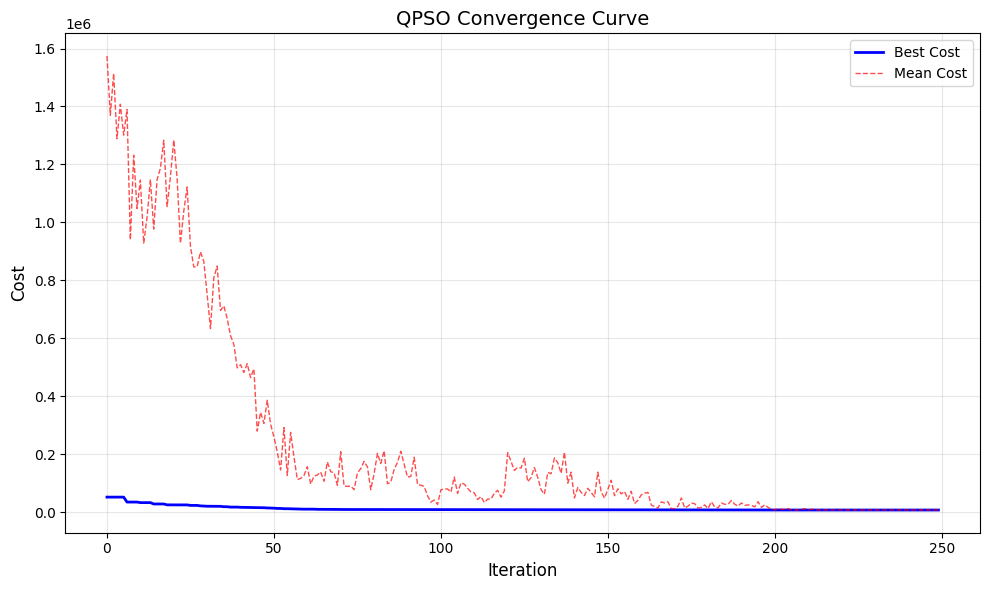

  ✓ Registered path for Drone 0 (11 waypoints)

✅ Drone 0 planning complete
   Path length: 2225.00m
   Waypoints: 11
   Altitude: 40.0m (mean)

🚁 PLANNING DRONE 1
Start Position:     [-700  700   40]
Goal Position:      [ 800 -700   40]
Assigned Altitude:  40.0m (band: 35.0-45.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2052m → +5 waypoints
Obstacles:          10 in corridor
Density:            0.000012
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 1
   Altitude band: 35.0-45.0m (center: 40.0m)

🚁 Multi-Drone Route Planning - Drone 1
Start Position:    [-700.  700.   40.]
Goal Position:     [ 800. -700.   40.]
Altitude Band:     35.0-45.0m (center: 40.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      1 (avoiding their paths)
Search Corridor:   X:[-900, 1000] Y:[-900, 900]

Iter     Best Cost       Mean Cost      

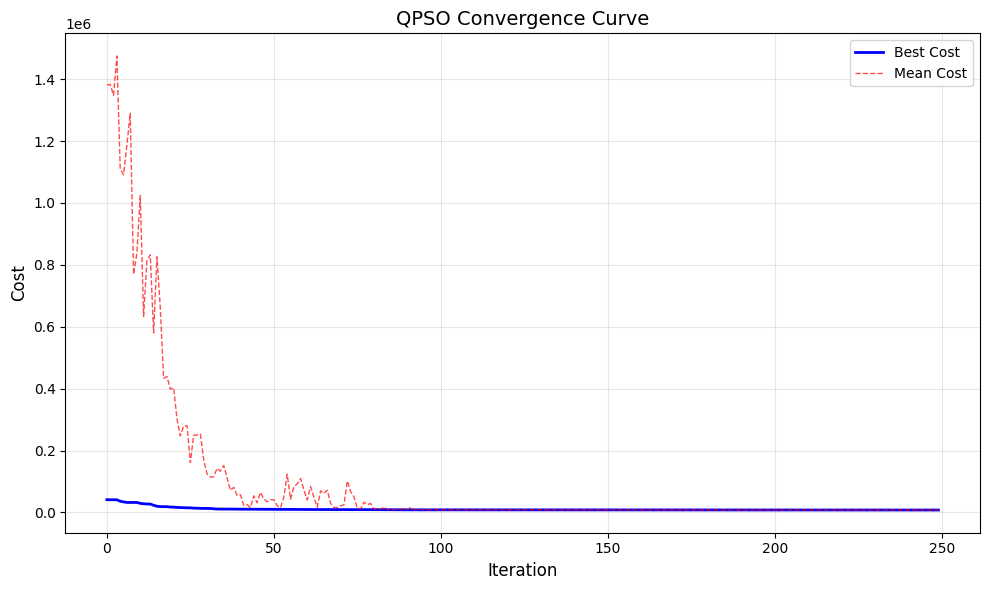

  ✓ Registered path for Drone 1 (11 waypoints)

✅ Drone 1 planning complete
   Path length: 2496.90m
   Waypoints: 11
   Altitude: 40.0m (mean)

🚁 PLANNING DRONE 2
Start Position:     [ 850 -850   40]
Goal Position:      [-850  850   40]
Assigned Altitude:  40.0m (band: 35.0-45.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2404m → +5 waypoints
Obstacles:          10 in corridor
Density:            0.000010
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 2
   Altitude band: 35.0-45.0m (center: 40.0m)

🚁 Multi-Drone Route Planning - Drone 2
Start Position:    [ 850. -850.   40.]
Goal Position:     [-850.  850.   40.]
Altitude Band:     35.0-45.0m (center: 40.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      2 (avoiding their paths)
Search Corridor:   X:[-1050, 1050] Y:[-1050, 1050]

Iter     Best Cost       Mean Cost   

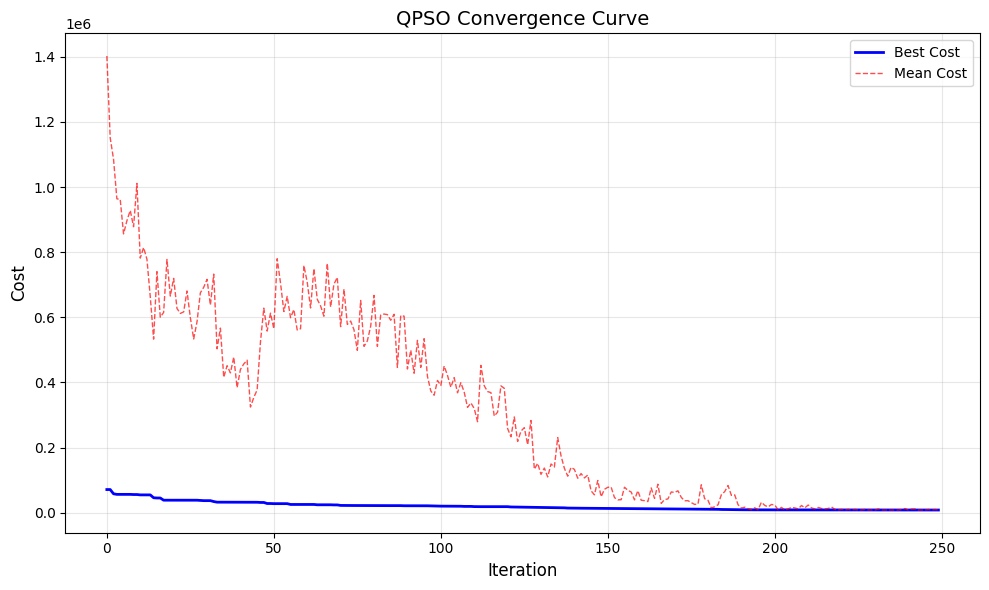

  ✓ Registered path for Drone 2 (11 waypoints)

✅ Drone 2 planning complete
   Path length: 2575.32m
   Waypoints: 11
   Altitude: 40.0m (mean)

🚁 PLANNING DRONE 3
Start Position:     [800 800  40]
Goal Position:      [-800 -800   40]
Assigned Altitude:  40.0m (band: 35.0-45.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2263m → +5 waypoints
Obstacles:          19 in corridor
Density:            0.000021
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 3
   Altitude band: 35.0-45.0m (center: 40.0m)

🚁 Multi-Drone Route Planning - Drone 3
Start Position:    [800. 800.  40.]
Goal Position:     [-800. -800.   40.]
Altitude Band:     35.0-45.0m (center: 40.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      3 (avoiding their paths)
Search Corridor:   X:[-1000, 1000] Y:[-1000, 1000]

Iter     Best Cost       Mean Cost       St

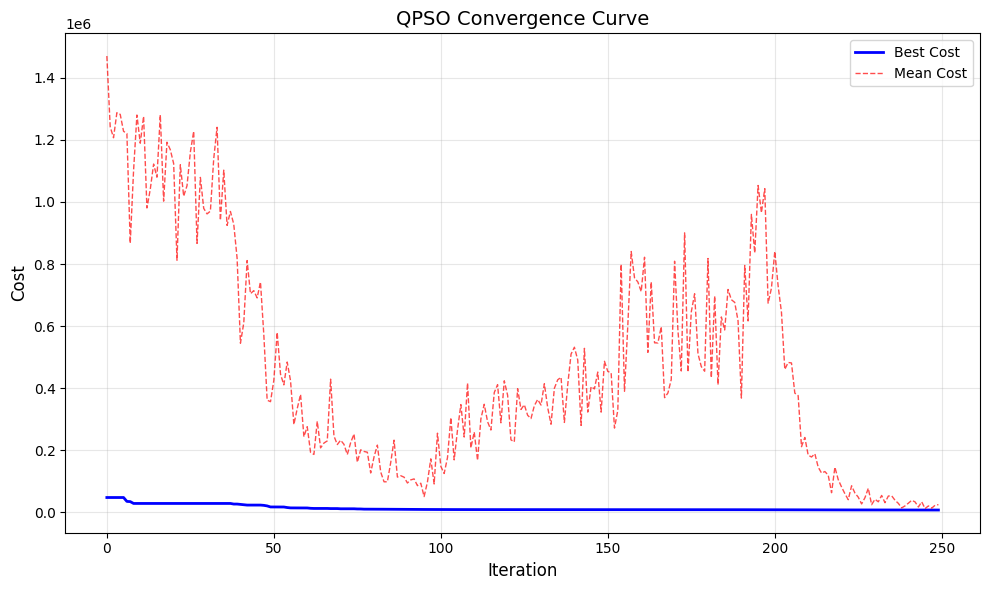

  ✓ Registered path for Drone 3 (11 waypoints)

✅ Drone 3 planning complete
   Path length: 2458.05m
   Waypoints: 11
   Altitude: 40.1m (mean)

✅ ALL DRONES PLANNED SUCCESSFULLY

📊 MULTI-DRONE PLANNING SUMMARY

Drone 0:
  Altitude Band:    35.0-45.0m
  Path Length:      2225.0m
  Waypoints:        11
  Mean Altitude:    40.0m
  Altitude Range:   40.0-40.1m

Drone 1:
  Altitude Band:    35.0-45.0m
  Path Length:      2496.9m
  Waypoints:        11
  Mean Altitude:    40.0m
  Altitude Range:   40.0-40.0m

Drone 2:
  Altitude Band:    35.0-45.0m
  Path Length:      2575.3m
  Waypoints:        11
  Mean Altitude:    40.0m
  Altitude Range:   40.0-40.1m

Drone 3:
  Altitude Band:    35.0-45.0m
  Path Length:      2458.1m
  Waypoints:        11
  Mean Altitude:    40.1m
  Altitude Range:   40.0-40.2m


  ✓ Saved: multi_drone_paths.npz (NumPy .npz compressed format)

✅ All drone paths planned successfully!

🎨 Visualizing...


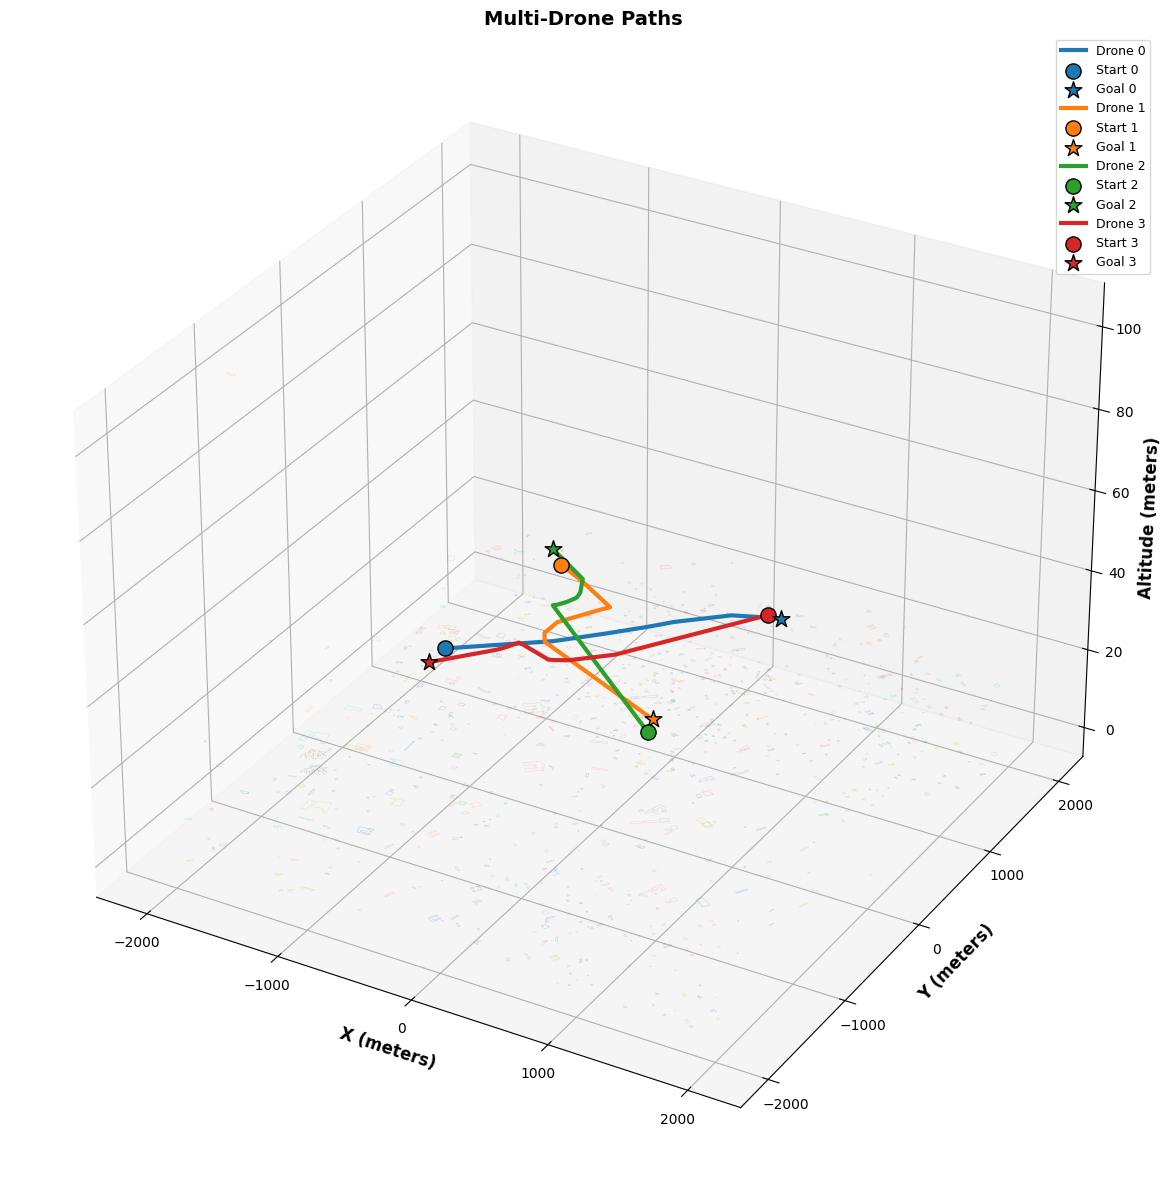

✓ Visualization complete

💾 Exporting paths...
  ✓ Saved: results/Scenario_1_HeadOn_Central_Crossing/drone_0_path.csv
  ✓ Saved: results/Scenario_1_HeadOn_Central_Crossing/drone_1_path.csv
  ✓ Saved: results/Scenario_1_HeadOn_Central_Crossing/drone_2_path.csv
  ✓ Saved: results/Scenario_1_HeadOn_Central_Crossing/drone_3_path.csv
✓ All paths exported

📊 SUMMARY — Scenario_1_HeadOn_Central_Crossing

Drone 0: Path=2225.0m | Detour=+1.0% | Altitude=40.0m

Drone 1: Path=2496.9m | Detour=+21.7% | Altitude=40.0m

Drone 2: Path=2575.3m | Detour=+7.1% | Altitude=40.0m

Drone 3: Path=2458.1m | Detour=+8.6% | Altitude=40.0m

Total Distance: 9755.3m | Avg Path: 2438.8m
Waypoints: 44 | Avg: 11.0

🔍 Checking for minimum inter-drone distances...
  Drone 0 ↔ 1: 56.3m ✅ SAFE
  Drone 0 ↔ 2: 428.7m ✅ SAFE
  Drone 0 ↔ 3: 40.9m ✅ SAFE
  Drone 1 ↔ 2: 15.1m ✅ SAFE
  Drone 1 ↔ 3: 146.6m ✅ SAFE
  Drone 2 ↔ 3: 506.2m ✅ SAFE

🎉 Scenario Complete: Scenario_1_HeadOn_Central_Crossing
📁 Results saved in: results/Sce

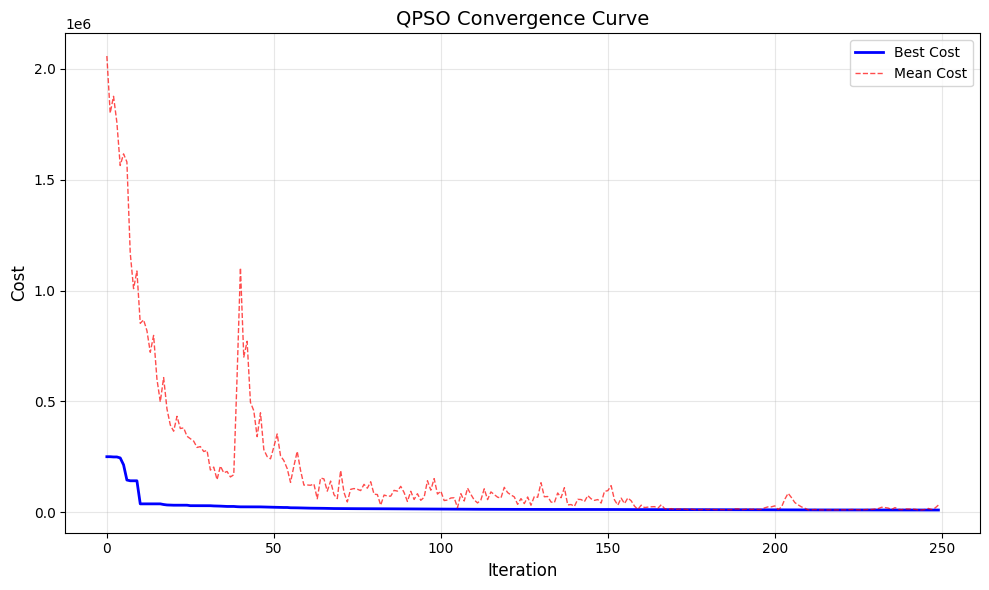

  ✓ Registered path for Drone 0 (10 waypoints)

✅ Drone 0 planning complete
   Path length: 2818.62m
   Waypoints: 10
   Altitude: 30.1m (mean)

🚁 PLANNING DRONE 1
Start Position:     [-700  700   40]
Goal Position:      [ 700 -700   40]
Assigned Altitude:  40.0m (band: 35.0-45.0m)

🔢 Dynamic Waypoint Calculation
Distance:           1980m → +4 waypoints
Obstacles:          12 in corridor
Density:            0.000015
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    8


🚁 Planner initialized for Drone 1
   Altitude band: 35.0-45.0m (center: 40.0m)

🚁 Multi-Drone Route Planning - Drone 1
Start Position:    [-700.  700.   40.]
Goal Position:     [ 700. -700.   40.]
Altitude Band:     35.0-45.0m (center: 40.0m)
Waypoints:         8
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-900, 900] Y:[-900, 900]

Iter     Best Cost       Mean Cost       

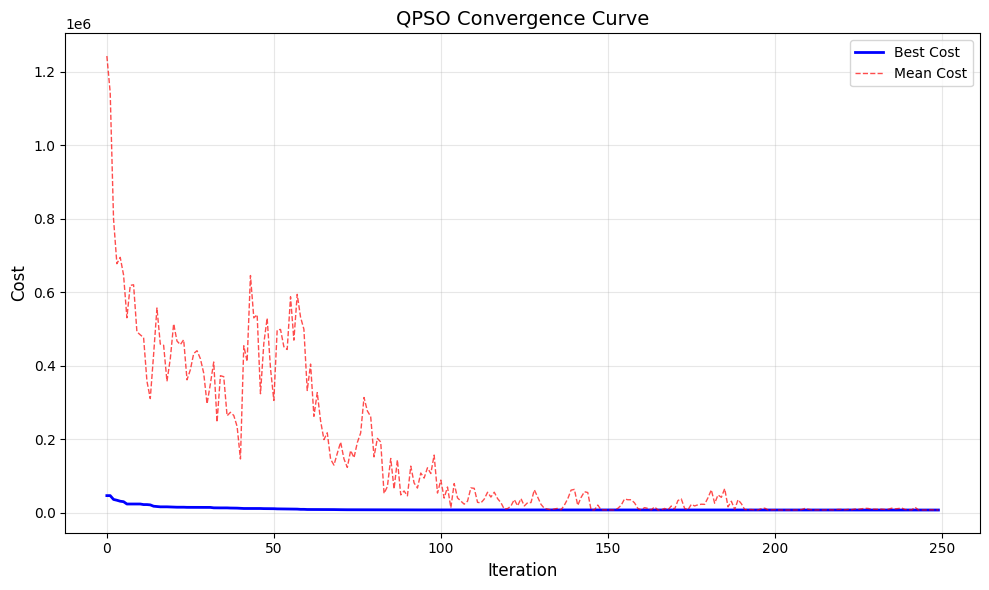

  ✓ Registered path for Drone 1 (10 waypoints)

✅ Drone 1 planning complete
   Path length: 2235.72m
   Waypoints: 10
   Altitude: 40.0m (mean)

🚁 PLANNING DRONE 2
Start Position:     [ 750 -750   50]
Goal Position:      [-750  750   35]
Assigned Altitude:  50.0m (band: 45.0-55.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2121m → +5 waypoints
Obstacles:          8 in corridor
Density:            0.000009
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 2
   Altitude band: 45.0-55.0m (center: 50.0m)

🚁 Multi-Drone Route Planning - Drone 2
Start Position:    [ 750. -750.   50.]
Goal Position:     [-750.  750.   35.]
Altitude Band:     45.0-55.0m (center: 50.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-950, 950] Y:[-950, 950]

Iter     Best Cost       Mean Cost       S

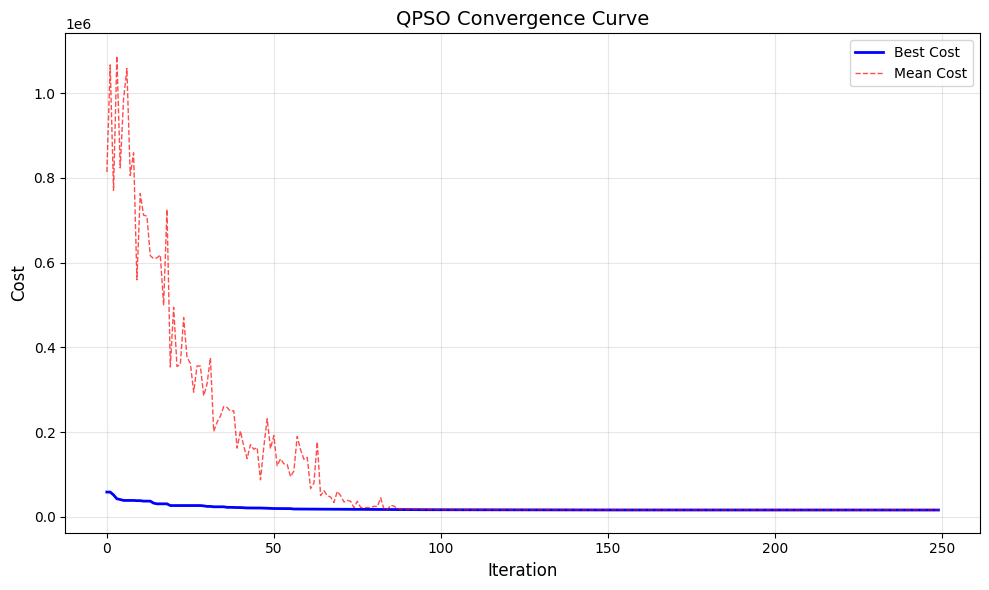

  ✓ Registered path for Drone 2 (11 waypoints)

✅ Drone 2 planning complete
   Path length: 2238.75m
   Waypoints: 11
   Altitude: 48.6m (mean)

🚁 PLANNING DRONE 3
Start Position:     [800 800  35]
Goal Position:      [-800 -800   45]
Assigned Altitude:  35.0m (band: 30.0-40.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2263m → +5 waypoints
Obstacles:          35 in corridor
Density:            0.000039
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 3
   Altitude band: 30.0-40.0m (center: 35.0m)

🚁 Multi-Drone Route Planning - Drone 3
Start Position:    [800. 800.  35.]
Goal Position:     [-800. -800.   45.]
Altitude Band:     30.0-40.0m (center: 35.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1000, 1000] Y:[-1000, 1000]

Iter     Best Cost       Mean Cost       St

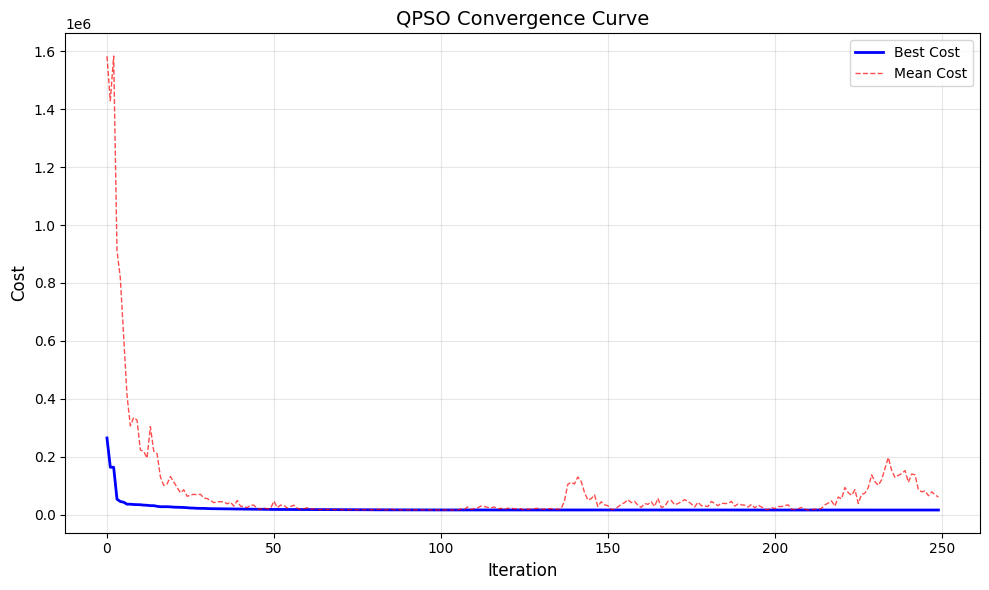

  ✓ Registered path for Drone 3 (11 waypoints)

✅ Drone 3 planning complete
   Path length: 3155.97m
   Waypoints: 11
   Altitude: 35.8m (mean)

✅ ALL DRONES PLANNED SUCCESSFULLY

📊 MULTI-DRONE PLANNING SUMMARY

Drone 0:
  Altitude Band:    25.0-35.0m
  Path Length:      2818.6m
  Waypoints:        10
  Mean Altitude:    30.1m
  Altitude Range:   30.0-30.2m

Drone 1:
  Altitude Band:    35.0-45.0m
  Path Length:      2235.7m
  Waypoints:        10
  Mean Altitude:    40.0m
  Altitude Range:   40.0-40.3m

Drone 2:
  Altitude Band:    45.0-55.0m
  Path Length:      2238.8m
  Waypoints:        11
  Mean Altitude:    48.6m
  Altitude Range:   35.0-50.0m

Drone 3:
  Altitude Band:    30.0-40.0m
  Path Length:      3156.0m
  Waypoints:        11
  Mean Altitude:    35.8m
  Altitude Range:   34.4-45.0m


  ✓ Saved: multi_drone_paths.npz (NumPy .npz compressed format)

✅ All drone paths planned successfully!

🎨 Visualizing...


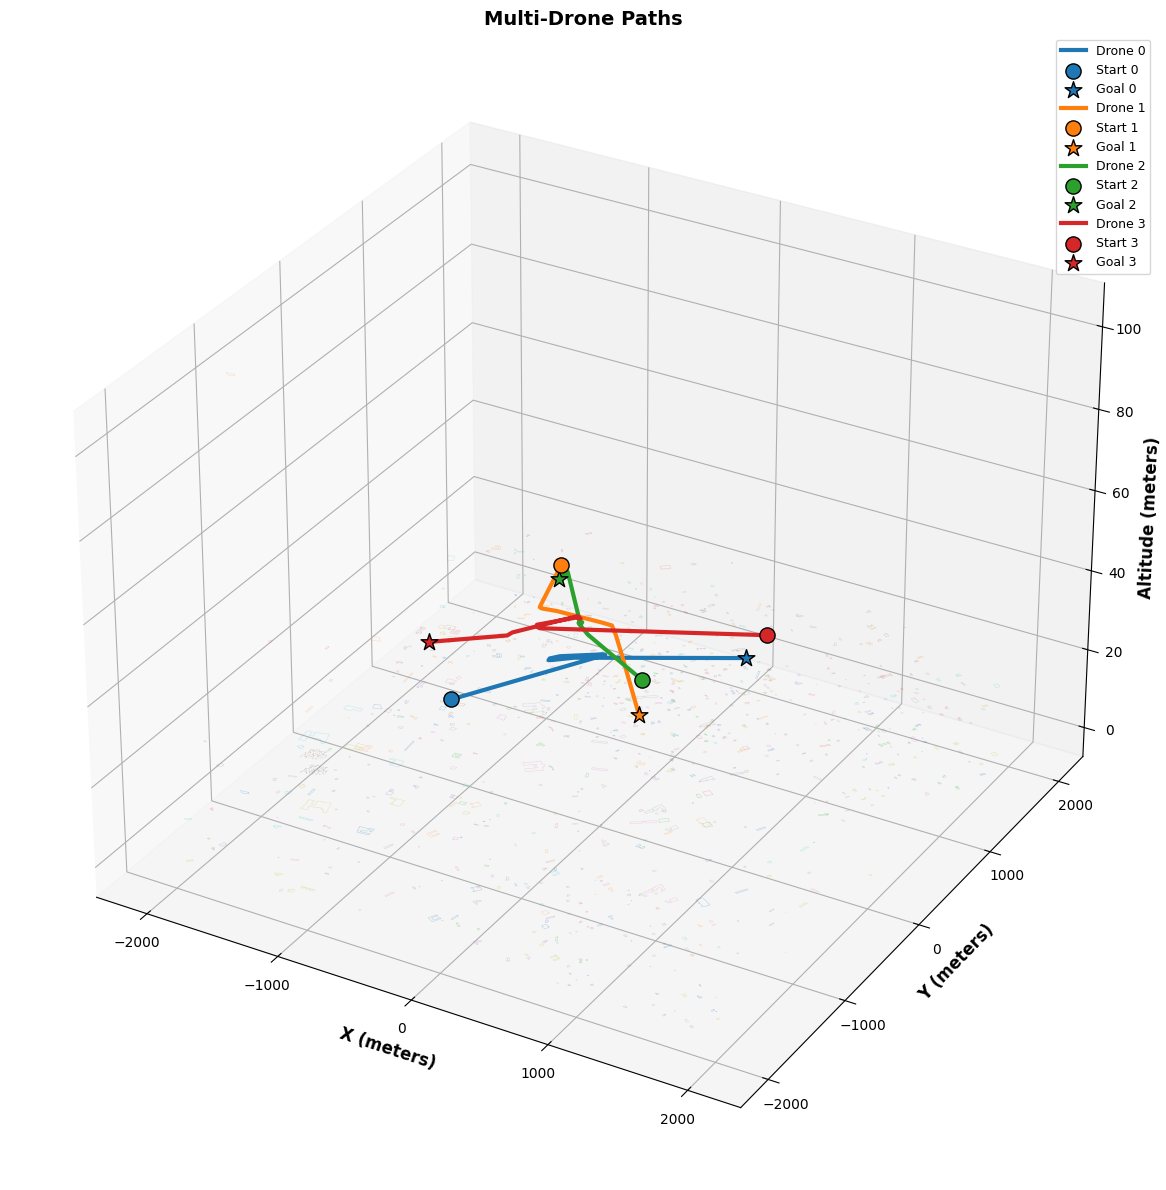

✓ Visualization complete

💾 Exporting paths...
  ✓ Saved: results/Scenario_2_Altitude_Convergence_Conflict/drone_0_path.csv
  ✓ Saved: results/Scenario_2_Altitude_Convergence_Conflict/drone_1_path.csv
  ✓ Saved: results/Scenario_2_Altitude_Convergence_Conflict/drone_2_path.csv
  ✓ Saved: results/Scenario_2_Altitude_Convergence_Conflict/drone_3_path.csv
✓ All paths exported

📊 SUMMARY — Scenario_2_Altitude_Convergence_Conflict

Drone 0: Path=2818.6m | Detour=+42.4% | Altitude=30.0m

Drone 1: Path=2235.7m | Detour=+12.9% | Altitude=40.0m

Drone 2: Path=2238.8m | Detour=+5.5% | Altitude=50.0m

Drone 3: Path=3156.0m | Detour=+39.5% | Altitude=35.0m

Total Distance: 10449.1m | Avg Path: 2612.3m
Waypoints: 42 | Avg: 10.5

🔍 Checking for minimum inter-drone distances...
  Drone 0 ↔ 1: 70.8m ✅ SAFE
  Drone 0 ↔ 2: 85.4m ✅ SAFE
  Drone 0 ↔ 3: 141.5m ✅ SAFE
  Drone 1 ↔ 2: 70.9m ✅ SAFE
  Drone 1 ↔ 3: 12.6m ✅ SAFE
  Drone 2 ↔ 3: 163.6m ✅ SAFE

🎉 Scenario Complete: Scenario_2_Altitude_Convergence_Co

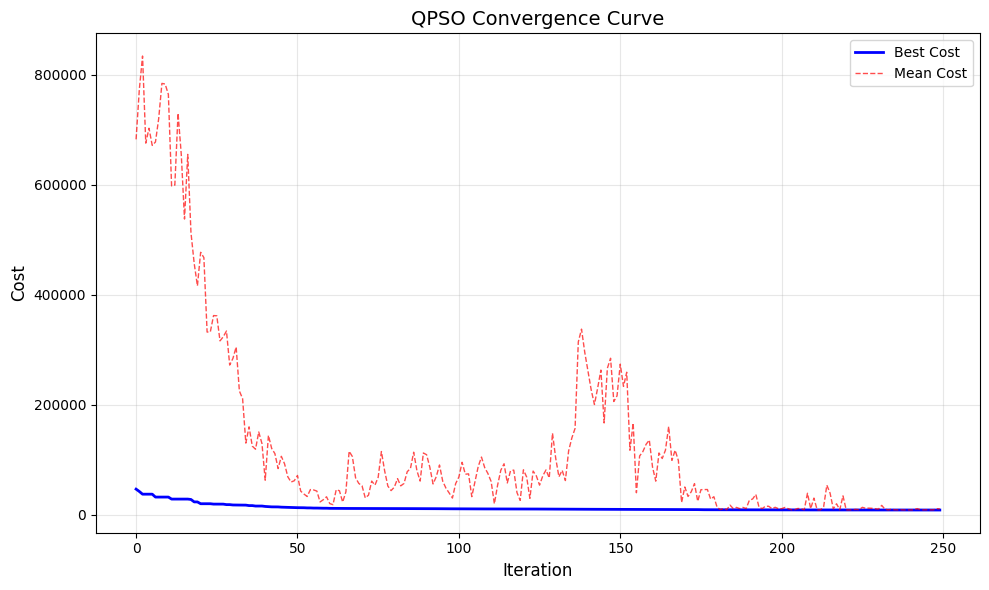

  ✓ Registered path for Drone 0 (11 waypoints)

✅ Drone 0 planning complete
   Path length: 2483.83m
   Waypoints: 11
   Altitude: 50.1m (mean)

🚁 PLANNING DRONE 1
Start Position:     [-650  750   50]
Goal Position:      [ 750 -650   50]
Assigned Altitude:  50.0m (band: 45.0-55.0m)

🔢 Dynamic Waypoint Calculation
Distance:           1980m → +4 waypoints
Obstacles:          9 in corridor
Density:            0.000011
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    8


🚁 Planner initialized for Drone 1
   Altitude band: 45.0-55.0m (center: 50.0m)

🚁 Multi-Drone Route Planning - Drone 1
Start Position:    [-650.  750.   50.]
Goal Position:     [ 750. -650.   50.]
Altitude Band:     45.0-55.0m (center: 50.0m)
Waypoints:         8
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-850, 950] Y:[-850, 950]

Iter     Best Cost       Mean Cost       S

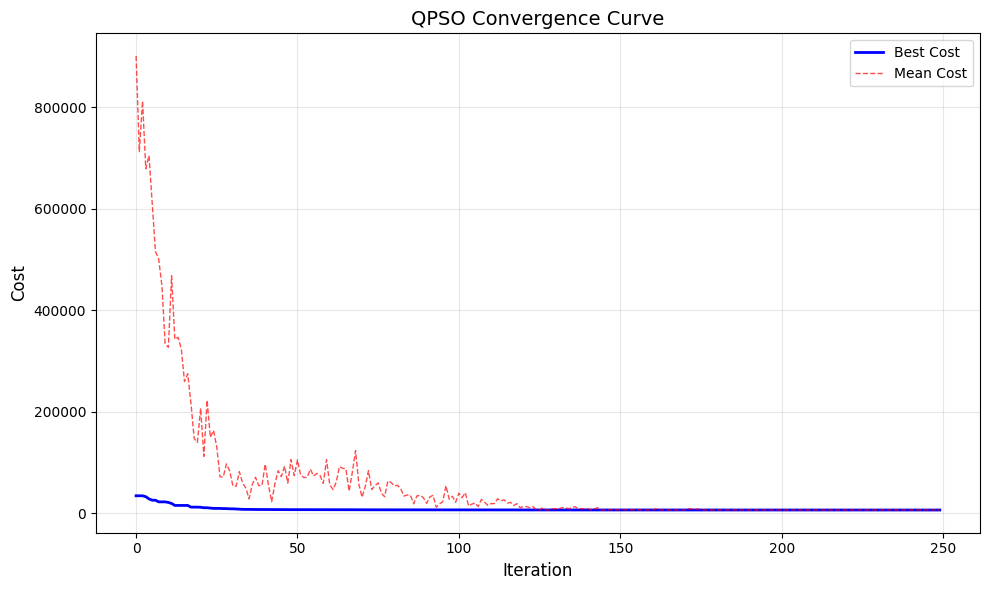

  ✓ Registered path for Drone 1 (10 waypoints)

✅ Drone 1 planning complete
   Path length: 2004.95m
   Waypoints: 10
   Altitude: 50.0m (mean)

🚁 PLANNING DRONE 2
Start Position:     [ 800 -800   55]
Goal Position:      [-800  800   55]
Assigned Altitude:  55.0m (band: 50.0-60.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2263m → +5 waypoints
Obstacles:          8 in corridor
Density:            0.000009
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 2
   Altitude band: 50.0-60.0m (center: 55.0m)

🚁 Multi-Drone Route Planning - Drone 2
Start Position:    [ 800. -800.   55.]
Goal Position:     [-800.  800.   55.]
Altitude Band:     50.0-60.0m (center: 55.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1000, 1000] Y:[-1000, 1000]

Iter     Best Cost       Mean Cost    

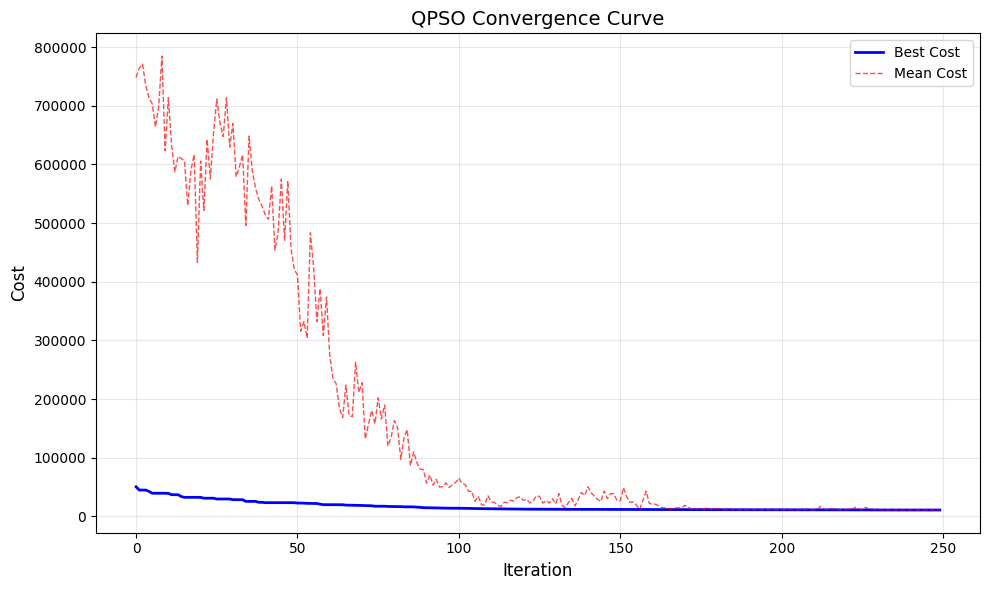

  ✓ Registered path for Drone 2 (11 waypoints)

✅ Drone 2 planning complete
   Path length: 2910.69m
   Waypoints: 11
   Altitude: 55.1m (mean)

🚁 PLANNING DRONE 3
Start Position:     [700 900  50]
Goal Position:      [-900 -700   50]
Assigned Altitude:  50.0m (band: 45.0-55.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2263m → +5 waypoints
Obstacles:          11 in corridor
Density:            0.000012
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 3
   Altitude band: 45.0-55.0m (center: 50.0m)

🚁 Multi-Drone Route Planning - Drone 3
Start Position:    [700. 900.  50.]
Goal Position:     [-900. -700.   50.]
Altitude Band:     45.0-55.0m (center: 50.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1100, 900] Y:[-900, 1100]

Iter     Best Cost       Mean Cost       Std 

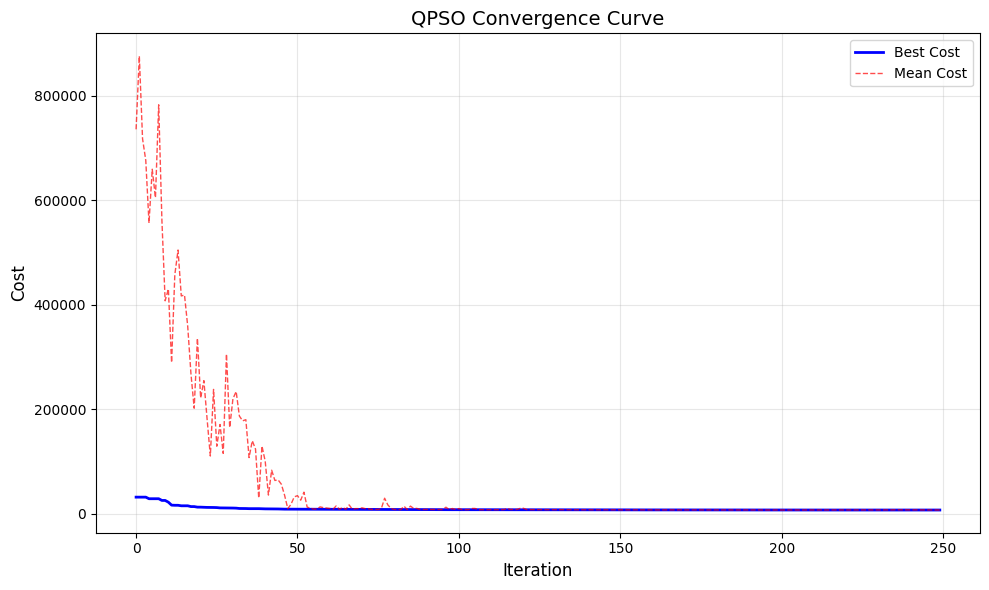

  ✓ Registered path for Drone 3 (11 waypoints)

✅ Drone 3 planning complete
   Path length: 2363.72m
   Waypoints: 11
   Altitude: 50.1m (mean)

✅ ALL DRONES PLANNED SUCCESSFULLY

📊 MULTI-DRONE PLANNING SUMMARY

Drone 0:
  Altitude Band:    45.0-55.0m
  Path Length:      2483.8m
  Waypoints:        11
  Mean Altitude:    50.1m
  Altitude Range:   50.0-50.4m

Drone 1:
  Altitude Band:    45.0-55.0m
  Path Length:      2004.9m
  Waypoints:        10
  Mean Altitude:    50.0m
  Altitude Range:   50.0-50.0m

Drone 2:
  Altitude Band:    50.0-60.0m
  Path Length:      2910.7m
  Waypoints:        11
  Mean Altitude:    55.1m
  Altitude Range:   54.7-56.0m

Drone 3:
  Altitude Band:    45.0-55.0m
  Path Length:      2363.7m
  Waypoints:        11
  Mean Altitude:    50.1m
  Altitude Range:   50.0-50.4m


  ✓ Saved: multi_drone_paths.npz (NumPy .npz compressed format)

✅ All drone paths planned successfully!

🎨 Visualizing...


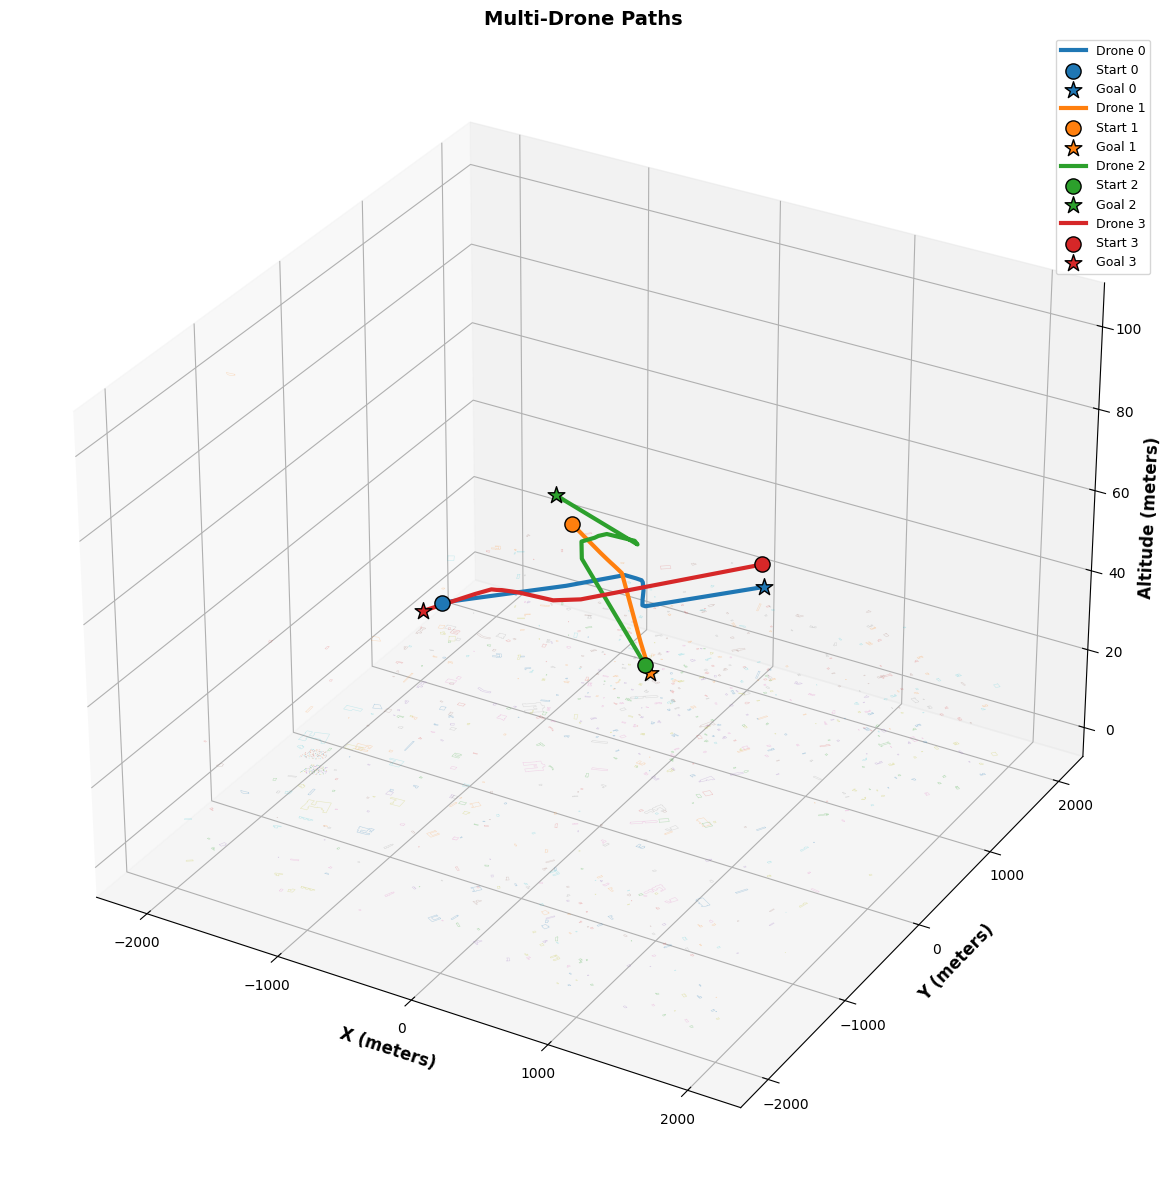

✓ Visualization complete

💾 Exporting paths...
  ✓ Saved: results/Scenario_3_Offset_Crossing_Close_Miss/drone_0_path.csv
  ✓ Saved: results/Scenario_3_Offset_Crossing_Close_Miss/drone_1_path.csv
  ✓ Saved: results/Scenario_3_Offset_Crossing_Close_Miss/drone_2_path.csv
  ✓ Saved: results/Scenario_3_Offset_Crossing_Close_Miss/drone_3_path.csv
✓ All paths exported

📊 SUMMARY — Scenario_3_Offset_Crossing_Close_Miss

Drone 0: Path=2483.8m | Detour=+19.4% | Altitude=50.0m

Drone 1: Path=2004.9m | Detour=+1.3% | Altitude=50.0m

Drone 2: Path=2910.7m | Detour=+28.6% | Altitude=55.0m

Drone 3: Path=2363.7m | Detour=+4.5% | Altitude=50.0m

Total Distance: 9763.2m | Avg Path: 2440.8m
Waypoints: 43 | Avg: 10.8

🔍 Checking for minimum inter-drone distances...
  Drone 0 ↔ 1: 51.5m ✅ SAFE
  Drone 0 ↔ 2: 142.0m ✅ SAFE
  Drone 0 ↔ 3: 158.1m ✅ SAFE
  Drone 1 ↔ 2: 14.7m ✅ SAFE
  Drone 1 ↔ 3: 310.7m ✅ SAFE
  Drone 2 ↔ 3: 259.4m ✅ SAFE

🎉 Scenario Complete: Scenario_3_Offset_Crossing_Close_Miss
📁 Results s

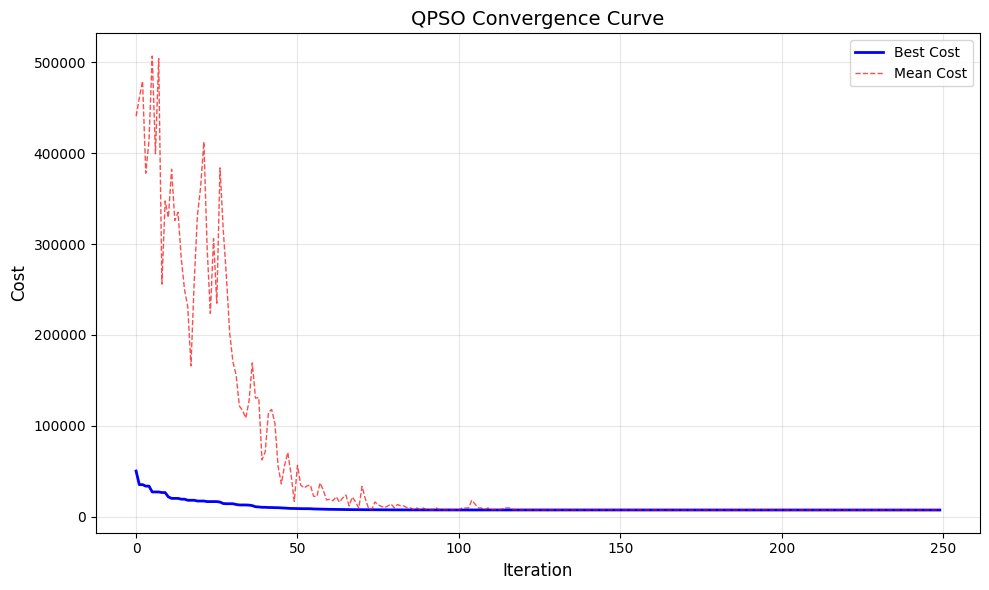

  ✓ Registered path for Drone 0 (11 waypoints)

✅ Drone 0 planning complete
   Path length: 2462.90m
   Waypoints: 11
   Altitude: 60.0m (mean)

🚁 PLANNING DRONE 1
Start Position:     [-850 -850   60]
Goal Position:      [950 950  60]
Assigned Altitude:  60.0m (band: 55.0-65.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2546m → +6 waypoints
Obstacles:          8 in corridor
Density:            0.000008
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    10


🚁 Planner initialized for Drone 1
   Altitude band: 55.0-65.0m (center: 60.0m)

🚁 Multi-Drone Route Planning - Drone 1
Start Position:    [-850. -850.   60.]
Goal Position:     [950. 950.  60.]
Altitude Band:     55.0-65.0m (center: 60.0m)
Waypoints:         10
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1050, 1150] Y:[-1050, 1150]

Iter     Best Cost       Mean Cost       S

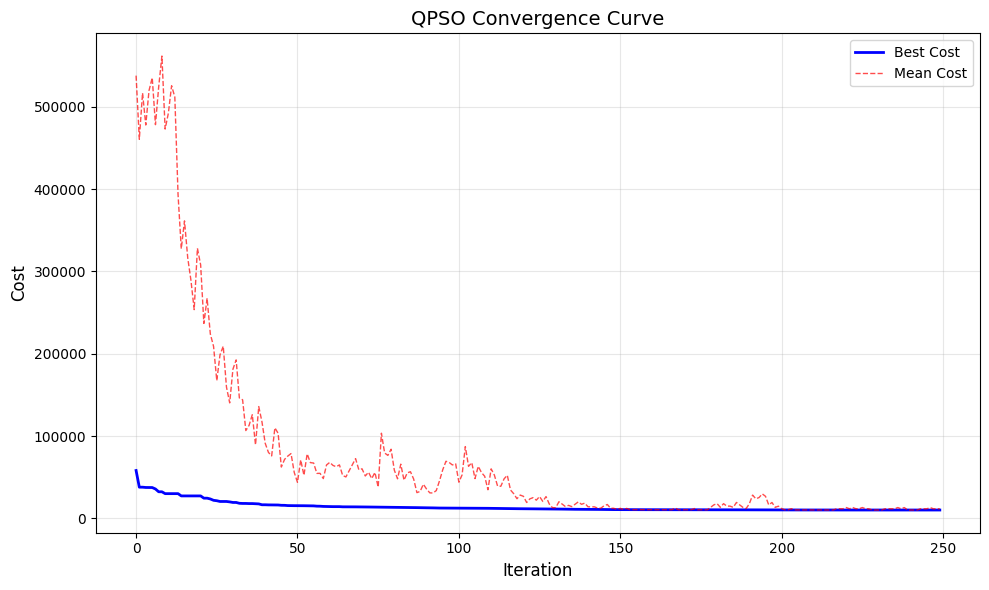

  ✓ Registered path for Drone 1 (12 waypoints)

✅ Drone 1 planning complete
   Path length: 3015.59m
   Waypoints: 12
   Altitude: 60.2m (mean)

🚁 PLANNING DRONE 2
Start Position:     [ 900 -700   65]
Goal Position:      [-900  700   65]
Assigned Altitude:  65.0m (band: 60.0-70.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2280m → +5 waypoints
Obstacles:          3 in corridor
Density:            0.000003
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 2
   Altitude band: 60.0-70.0m (center: 65.0m)

🚁 Multi-Drone Route Planning - Drone 2
Start Position:    [ 900. -700.   65.]
Goal Position:     [-900.  700.   65.]
Altitude Band:     60.0-70.0m (center: 65.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1100, 1100] Y:[-900, 900]

Iter     Best Cost       Mean Cost      

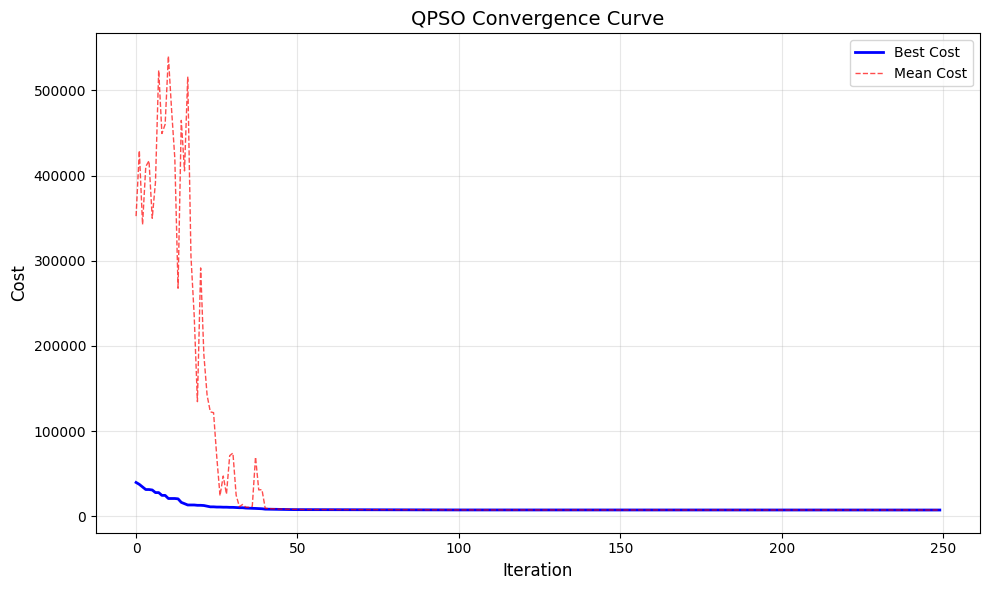

  ✓ Registered path for Drone 2 (11 waypoints)

✅ Drone 2 planning complete
   Path length: 2309.09m
   Waypoints: 11
   Altitude: 65.0m (mean)

🚁 PLANNING DRONE 3
Start Position:     [850 850  70]
Goal Position:      [-850 -850   70]
Assigned Altitude:  70.0m (band: 65.0-75.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2404m → +5 waypoints
Obstacles:          9 in corridor
Density:            0.000009
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 3
   Altitude band: 65.0-75.0m (center: 70.0m)

🚁 Multi-Drone Route Planning - Drone 3
Start Position:    [850. 850.  70.]
Goal Position:     [-850. -850.   70.]
Altitude Band:     65.0-75.0m (center: 70.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1050, 1050] Y:[-1050, 1050]

Iter     Best Cost       Mean Cost       Std

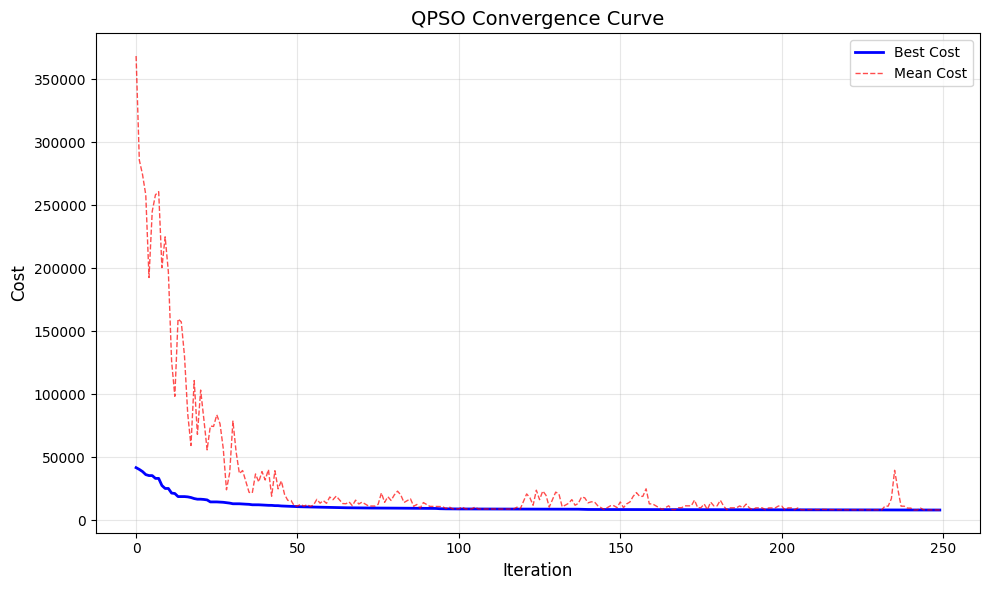

  ✓ Registered path for Drone 3 (11 waypoints)

✅ Drone 3 planning complete
   Path length: 2554.39m
   Waypoints: 11
   Altitude: 70.0m (mean)

✅ ALL DRONES PLANNED SUCCESSFULLY

📊 MULTI-DRONE PLANNING SUMMARY

Drone 0:
  Altitude Band:    55.0-65.0m
  Path Length:      2462.9m
  Waypoints:        11
  Mean Altitude:    60.0m
  Altitude Range:   60.0-60.0m

Drone 1:
  Altitude Band:    55.0-65.0m
  Path Length:      3015.6m
  Waypoints:        12
  Mean Altitude:    60.2m
  Altitude Range:   60.0-60.5m

Drone 2:
  Altitude Band:    60.0-70.0m
  Path Length:      2309.1m
  Waypoints:        11
  Mean Altitude:    65.0m
  Altitude Range:   64.6-65.0m

Drone 3:
  Altitude Band:    65.0-75.0m
  Path Length:      2554.4m
  Waypoints:        11
  Mean Altitude:    70.0m
  Altitude Range:   70.0-70.2m


  ✓ Saved: multi_drone_paths.npz (NumPy .npz compressed format)

✅ All drone paths planned successfully!

🎨 Visualizing...


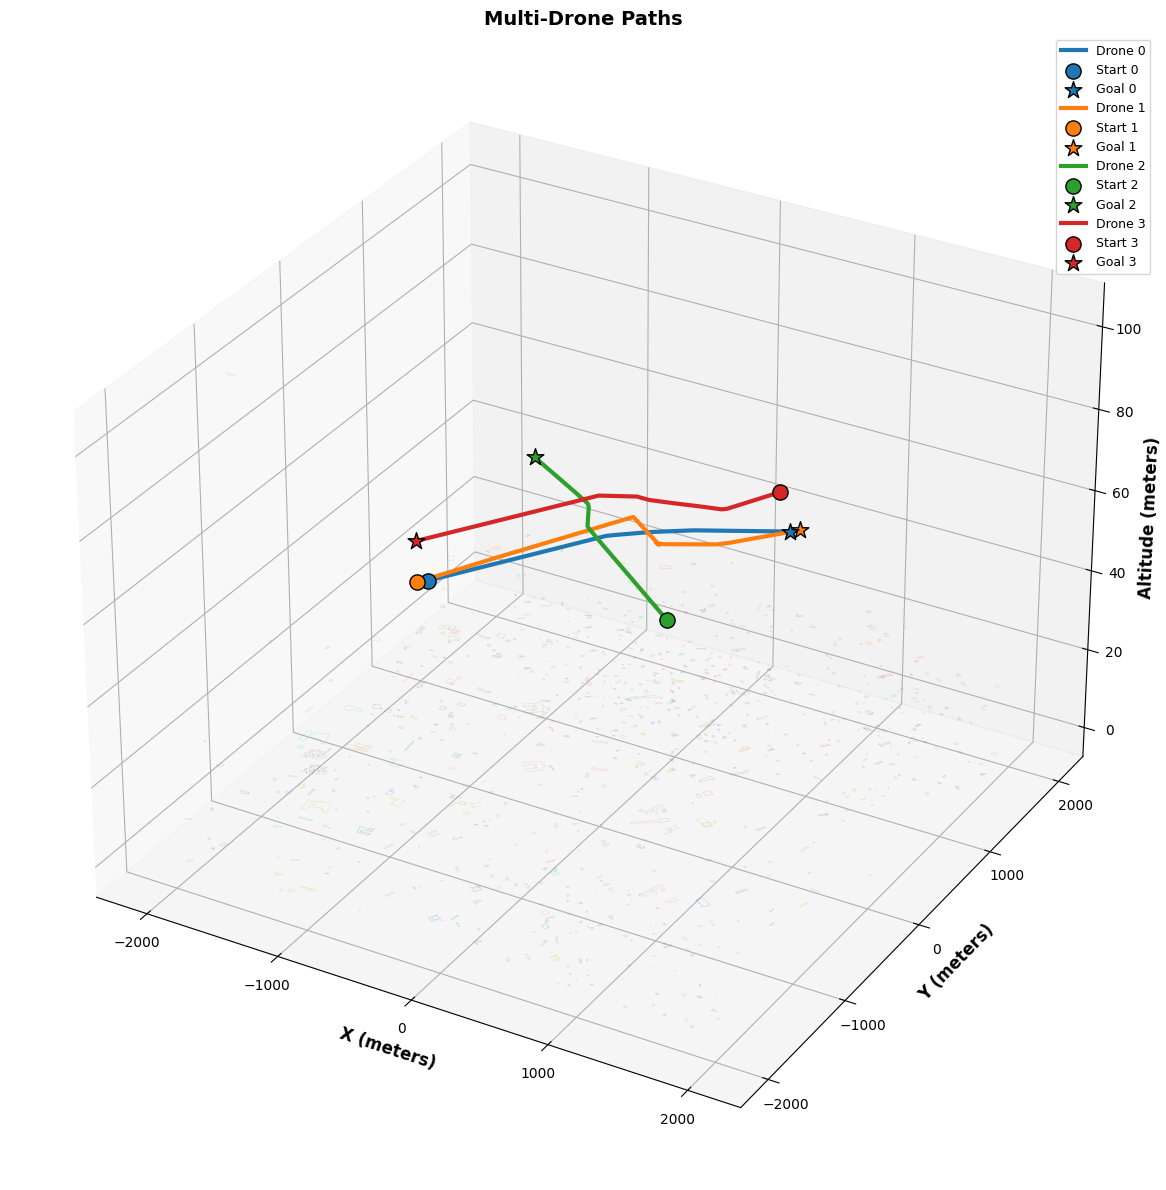

✓ Visualization complete

💾 Exporting paths...
  ✓ Saved: results/Scenario_4_MidAir_Overtake/drone_0_path.csv
  ✓ Saved: results/Scenario_4_MidAir_Overtake/drone_1_path.csv
  ✓ Saved: results/Scenario_4_MidAir_Overtake/drone_2_path.csv
  ✓ Saved: results/Scenario_4_MidAir_Overtake/drone_3_path.csv
✓ All paths exported

📊 SUMMARY — Scenario_4_MidAir_Overtake

Drone 0: Path=2462.9m | Detour=+2.4% | Altitude=60.0m

Drone 1: Path=3015.6m | Detour=+18.5% | Altitude=60.0m

Drone 2: Path=2309.1m | Detour=+1.3% | Altitude=65.0m

Drone 3: Path=2554.4m | Detour=+6.2% | Altitude=70.0m

Total Distance: 10342.0m | Avg Path: 2585.5m
Waypoints: 45 | Avg: 11.2

🔍 Checking for minimum inter-drone distances...
  Drone 0 ↔ 1: 70.7m ✅ SAFE
  Drone 0 ↔ 2: 138.6m ✅ SAFE
  Drone 0 ↔ 3: 48.6m ✅ SAFE
  Drone 1 ↔ 2: 278.5m ✅ SAFE
  Drone 1 ↔ 3: 10.0m ✅ SAFE
  Drone 2 ↔ 3: 108.7m ✅ SAFE

🎉 Scenario Complete: Scenario_4_MidAir_Overtake
📁 Results saved in: results/Scenario_4_MidAir_Overtake/


🚁 MULTI-DRONE PATH P

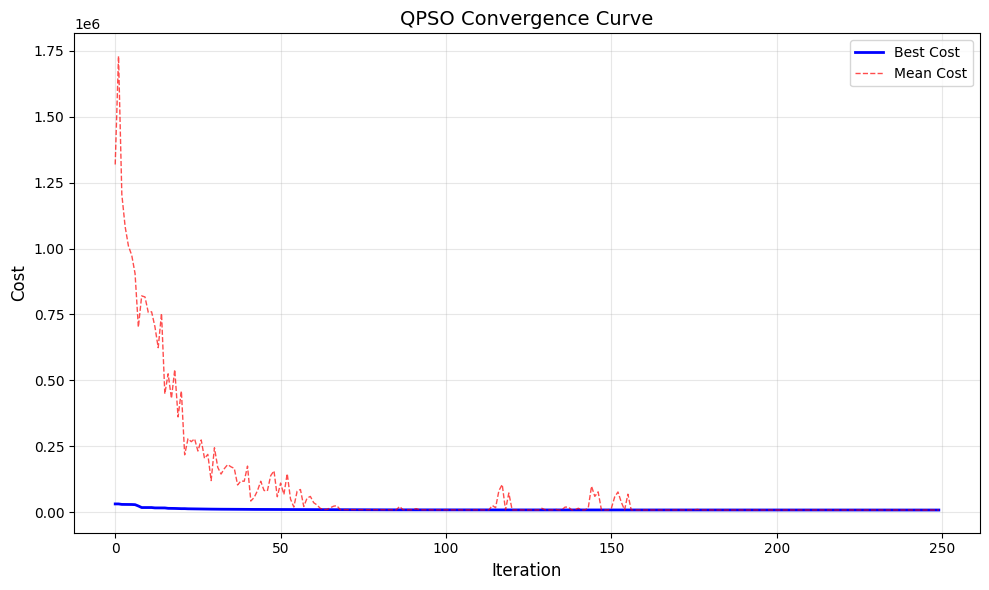

  ✓ Registered path for Drone 0 (10 waypoints)

✅ Drone 0 planning complete
   Path length: 2091.96m
   Waypoints: 10
   Altitude: 30.5m (mean)

🚁 PLANNING DRONE 1
Start Position:     [-700  700   35]
Goal Position:      [ 700 -700   40]
Assigned Altitude:  35.0m (band: 30.0-40.0m)

🔢 Dynamic Waypoint Calculation
Distance:           1980m → +4 waypoints
Obstacles:          30 in corridor
Density:            0.000038
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    8


🚁 Planner initialized for Drone 1
   Altitude band: 30.0-40.0m (center: 35.0m)

🚁 Multi-Drone Route Planning - Drone 1
Start Position:    [-700.  700.   35.]
Goal Position:     [ 700. -700.   40.]
Altitude Band:     30.0-40.0m (center: 35.0m)
Waypoints:         8
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-900, 900] Y:[-900, 900]

Iter     Best Cost       Mean Cost       

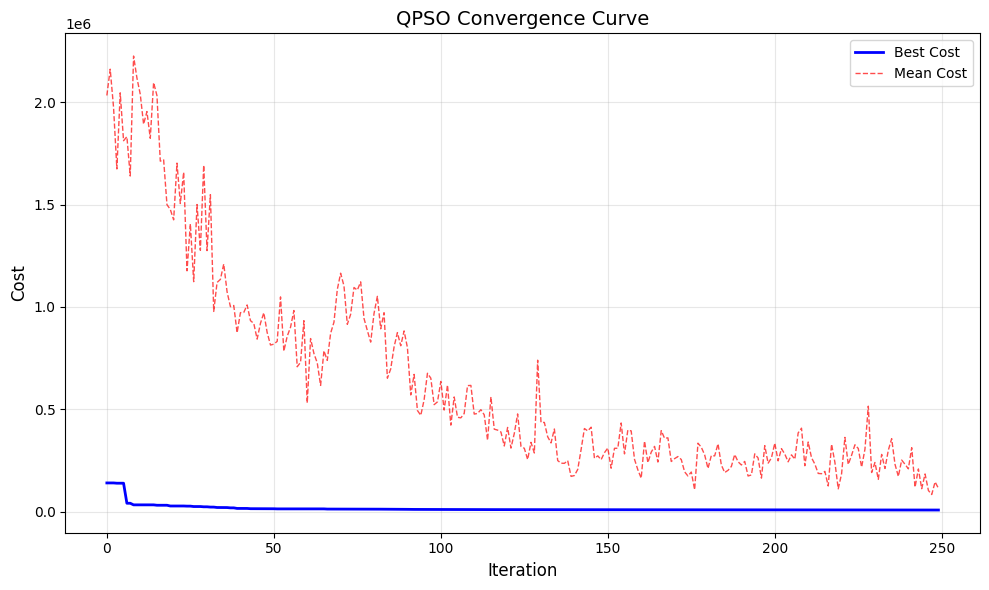

  ✓ Registered path for Drone 1 (10 waypoints)

✅ Drone 1 planning complete
   Path length: 2045.62m
   Waypoints: 10
   Altitude: 35.3m (mean)

🚁 PLANNING DRONE 2
Start Position:     [ 700 -700   40]
Goal Position:      [-700  700   30]
Assigned Altitude:  40.0m (band: 35.0-45.0m)

🔢 Dynamic Waypoint Calculation
Distance:           1980m → +4 waypoints
Obstacles:          12 in corridor
Density:            0.000015
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    8


🚁 Planner initialized for Drone 2
   Altitude band: 35.0-45.0m (center: 40.0m)

🚁 Multi-Drone Route Planning - Drone 2
Start Position:    [ 700. -700.   40.]
Goal Position:     [-700.  700.   30.]
Altitude Band:     35.0-45.0m (center: 40.0m)
Waypoints:         8
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-900, 900] Y:[-900, 900]

Iter     Best Cost       Mean Cost       

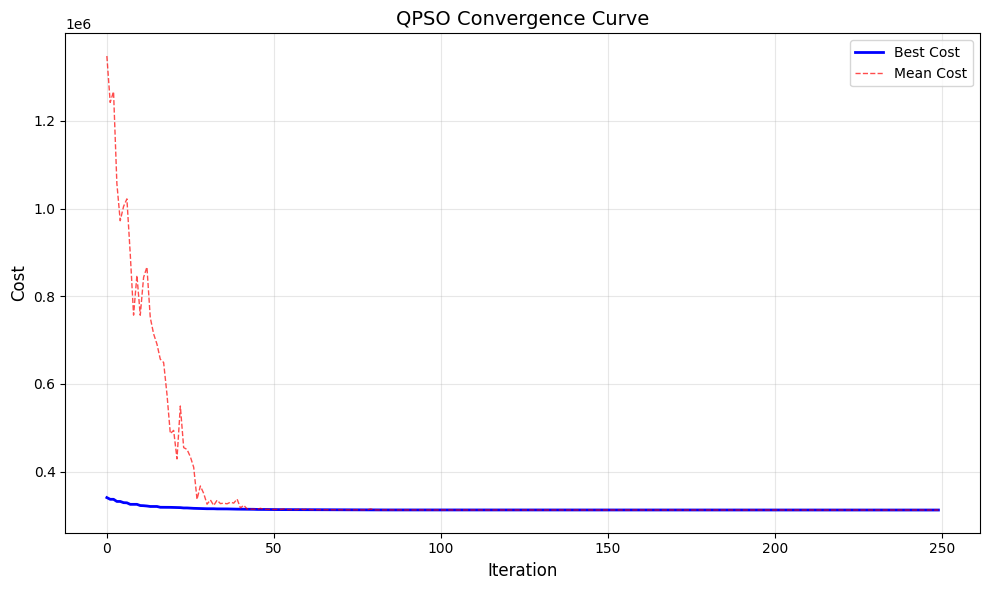

  ✓ Registered path for Drone 2 (10 waypoints)

✅ Drone 2 planning complete
   Path length: 2320.26m
   Waypoints: 10
   Altitude: 39.0m (mean)

🚁 PLANNING DRONE 3
Start Position:     [800 800  45]
Goal Position:      [-800 -800   30]
Assigned Altitude:  45.0m (band: 40.0-50.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2263m → +5 waypoints
Obstacles:          19 in corridor
Density:            0.000021
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 3
   Altitude band: 40.0-50.0m (center: 45.0m)

🚁 Multi-Drone Route Planning - Drone 3
Start Position:    [800. 800.  45.]
Goal Position:     [-800. -800.   30.]
Altitude Band:     40.0-50.0m (center: 45.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1000, 1000] Y:[-1000, 1000]

Iter     Best Cost       Mean Cost       St

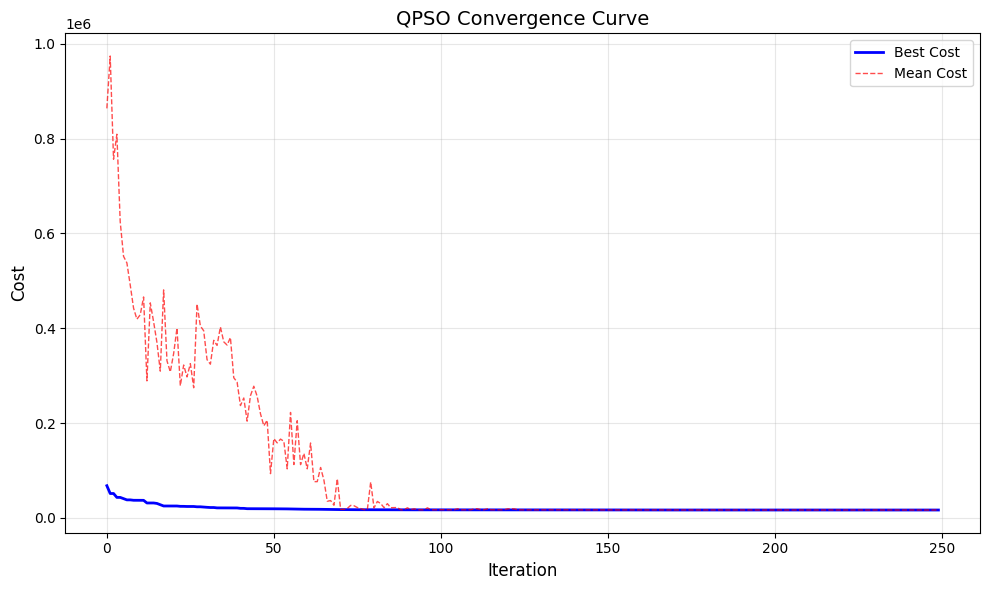

  ✓ Registered path for Drone 3 (11 waypoints)

✅ Drone 3 planning complete
   Path length: 2344.95m
   Waypoints: 11
   Altitude: 43.6m (mean)

✅ ALL DRONES PLANNED SUCCESSFULLY

📊 MULTI-DRONE PLANNING SUMMARY

Drone 0:
  Altitude Band:    25.0-35.0m
  Path Length:      2092.0m
  Waypoints:        10
  Mean Altitude:    30.5m
  Altitude Range:   30.0-35.0m

Drone 1:
  Altitude Band:    30.0-40.0m
  Path Length:      2045.6m
  Waypoints:        10
  Mean Altitude:    35.3m
  Altitude Range:   34.5-40.0m

Drone 2:
  Altitude Band:    35.0-45.0m
  Path Length:      2320.3m
  Waypoints:        10
  Mean Altitude:    39.0m
  Altitude Range:   30.0-40.2m

Drone 3:
  Altitude Band:    40.0-50.0m
  Path Length:      2345.0m
  Waypoints:        11
  Mean Altitude:    43.6m
  Altitude Range:   30.0-45.0m


  ✓ Saved: multi_drone_paths.npz (NumPy .npz compressed format)

✅ All drone paths planned successfully!

🎨 Visualizing...


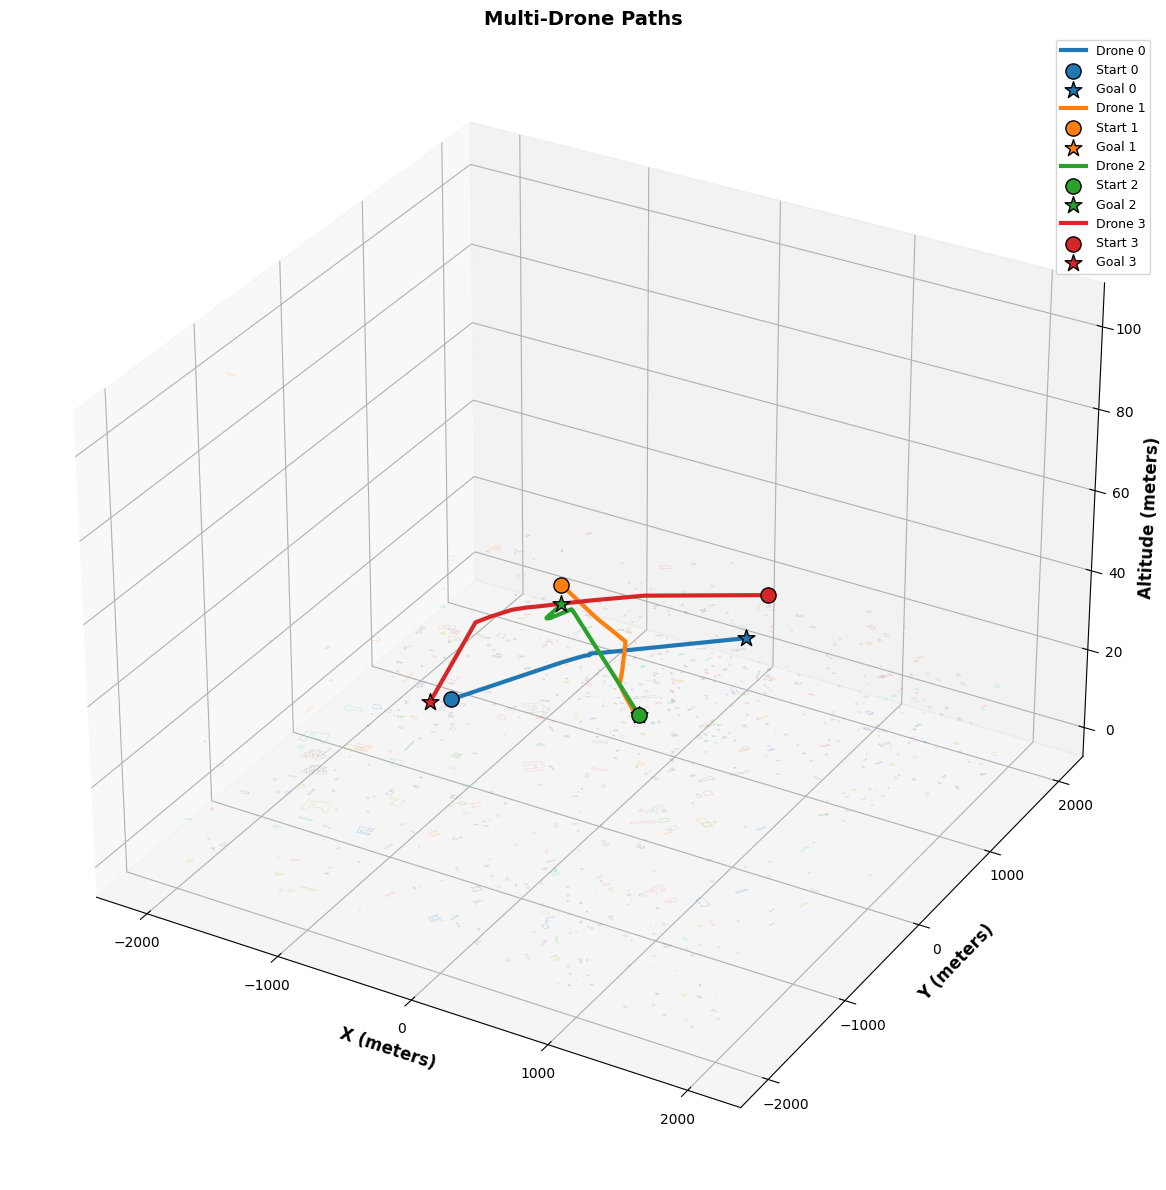

✓ Visualization complete

💾 Exporting paths...
  ✓ Saved: results/Scenario_5_MultiAltitude_Stack_Conflict/drone_0_path.csv
  ✓ Saved: results/Scenario_5_MultiAltitude_Stack_Conflict/drone_1_path.csv
  ✓ Saved: results/Scenario_5_MultiAltitude_Stack_Conflict/drone_2_path.csv
  ✓ Saved: results/Scenario_5_MultiAltitude_Stack_Conflict/drone_3_path.csv
✓ All paths exported

📊 SUMMARY — Scenario_5_MultiAltitude_Stack_Conflict

Drone 0: Path=2092.0m | Detour=+5.7% | Altitude=30.0m

Drone 1: Path=2045.6m | Detour=+3.3% | Altitude=35.0m

Drone 2: Path=2320.3m | Detour=+17.2% | Altitude=40.0m

Drone 3: Path=2345.0m | Detour=+3.6% | Altitude=45.0m

Total Distance: 8802.8m | Avg Path: 2200.7m
Waypoints: 41 | Avg: 10.2

🔍 Checking for minimum inter-drone distances...
  Drone 0 ↔ 1: 96.4m ✅ SAFE
  Drone 0 ↔ 2: 36.7m ✅ SAFE
  Drone 0 ↔ 3: 69.1m ✅ SAFE
  Drone 1 ↔ 2: 0.0m ⚠️ WARNING
  Drone 1 ↔ 3: 128.0m ✅ SAFE
  Drone 2 ↔ 3: 87.1m ✅ SAFE

🎉 Scenario Complete: Scenario_5_MultiAltitude_Stack_Conflict


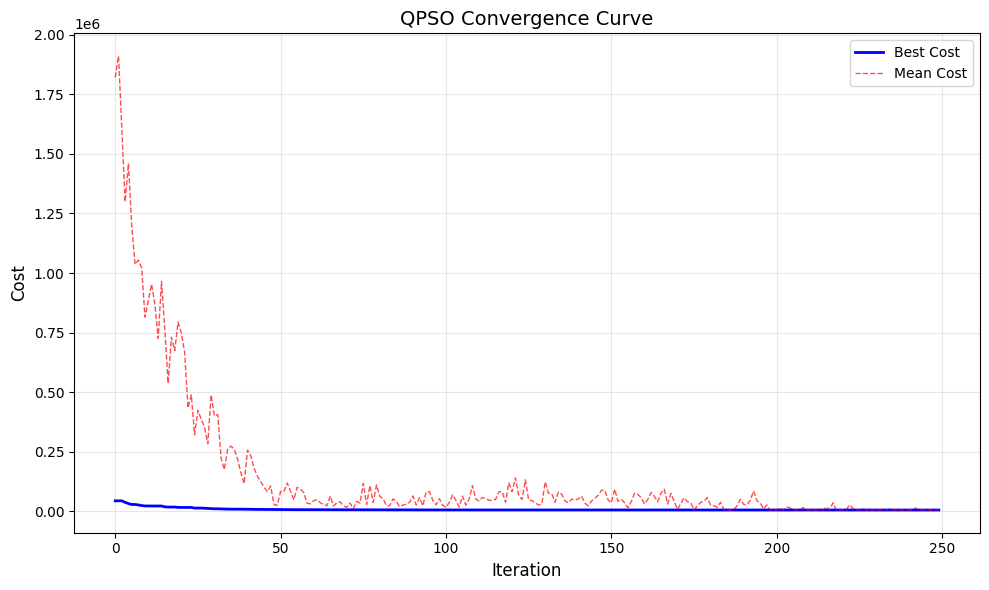

  ✓ Registered path for Drone 0 (10 waypoints)

✅ Drone 0 planning complete
   Path length: 1803.46m
   Waypoints: 10
   Altitude: 40.0m (mean)

🚁 PLANNING DRONE 1
Start Position:     [   0 -900   40]
Goal Position:      [  0 900  40]
Assigned Altitude:  40.0m (band: 35.0-45.0m)

🔢 Dynamic Waypoint Calculation
Distance:           1800m → +4 waypoints
Obstacles:          23 in corridor
Density:            0.000032
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    8


🚁 Planner initialized for Drone 1
   Altitude band: 35.0-45.0m (center: 40.0m)

🚁 Multi-Drone Route Planning - Drone 1
Start Position:    [   0. -900.   40.]
Goal Position:     [  0. 900.  40.]
Altitude Band:     35.0-45.0m (center: 40.0m)
Waypoints:         8
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-200, 200] Y:[-1100, 1100]

Iter     Best Cost       Mean Cost       Std 

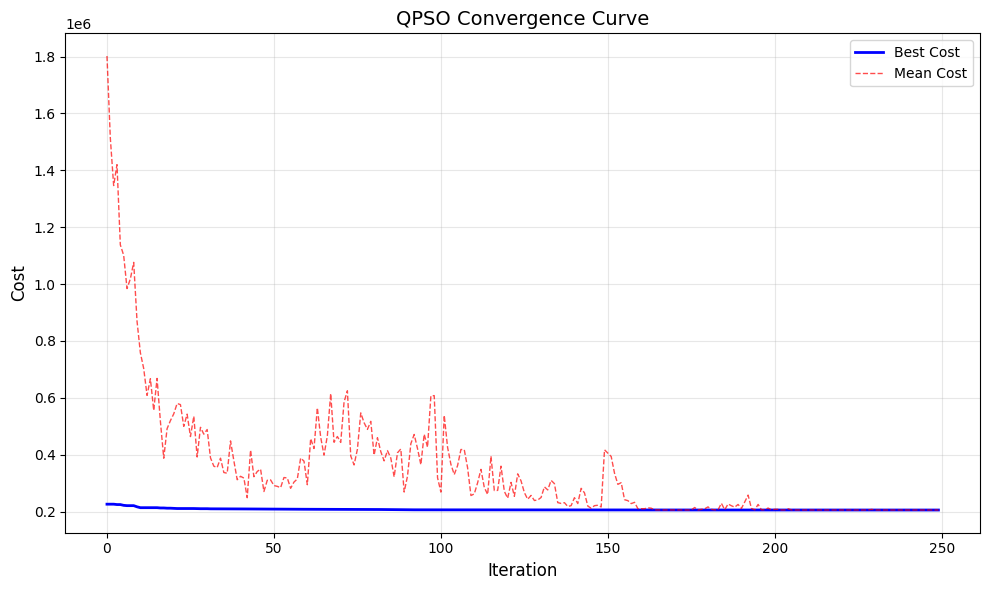

  ✓ Registered path for Drone 1 (10 waypoints)

✅ Drone 1 planning complete
   Path length: 1935.44m
   Waypoints: 10
   Altitude: 40.0m (mean)

🚁 PLANNING DRONE 2
Start Position:     [-850 -850   45]
Goal Position:      [850 850  45]
Assigned Altitude:  45.0m (band: 40.0-50.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2404m → +5 waypoints
Obstacles:          20 in corridor
Density:            0.000021
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 2
   Altitude band: 40.0-50.0m (center: 45.0m)

🚁 Multi-Drone Route Planning - Drone 2
Start Position:    [-850. -850.   45.]
Goal Position:     [850. 850.  45.]
Altitude Band:     40.0-50.0m (center: 45.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1050, 1050] Y:[-1050, 1050]

Iter     Best Cost       Mean Cost       St

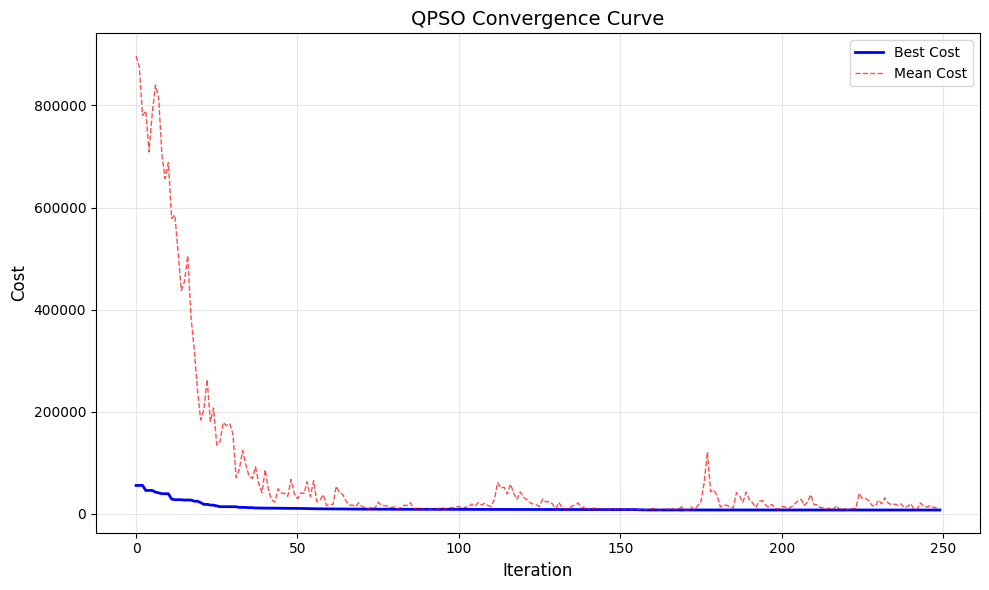

  ✓ Registered path for Drone 2 (11 waypoints)

✅ Drone 2 planning complete
   Path length: 2476.15m
   Waypoints: 11
   Altitude: 45.0m (mean)

🚁 PLANNING DRONE 3
Start Position:     [ 850 -850   45]
Goal Position:      [-850  850   45]
Assigned Altitude:  45.0m (band: 40.0-50.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2404m → +5 waypoints
Obstacles:          10 in corridor
Density:            0.000010
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 3
   Altitude band: 40.0-50.0m (center: 45.0m)

🚁 Multi-Drone Route Planning - Drone 3
Start Position:    [ 850. -850.   45.]
Goal Position:     [-850.  850.   45.]
Altitude Band:     40.0-50.0m (center: 45.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1050, 1050] Y:[-1050, 1050]

Iter     Best Cost       Mean Cost   

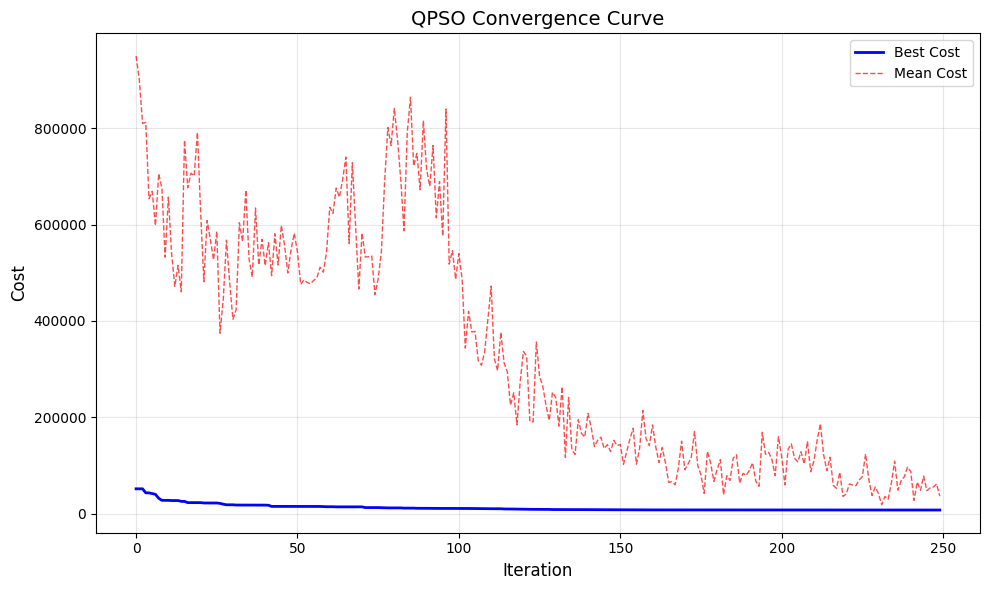

  ✓ Registered path for Drone 3 (11 waypoints)

✅ Drone 3 planning complete
   Path length: 2438.20m
   Waypoints: 11
   Altitude: 45.0m (mean)

✅ ALL DRONES PLANNED SUCCESSFULLY

📊 MULTI-DRONE PLANNING SUMMARY

Drone 0:
  Altitude Band:    35.0-45.0m
  Path Length:      1803.5m
  Waypoints:        10
  Mean Altitude:    40.0m
  Altitude Range:   40.0-40.0m

Drone 1:
  Altitude Band:    35.0-45.0m
  Path Length:      1935.4m
  Waypoints:        10
  Mean Altitude:    40.0m
  Altitude Range:   40.0-40.0m

Drone 2:
  Altitude Band:    40.0-50.0m
  Path Length:      2476.2m
  Waypoints:        11
  Mean Altitude:    45.0m
  Altitude Range:   45.0-45.1m

Drone 3:
  Altitude Band:    40.0-50.0m
  Path Length:      2438.2m
  Waypoints:        11
  Mean Altitude:    45.0m
  Altitude Range:   45.0-45.0m


  ✓ Saved: multi_drone_paths.npz (NumPy .npz compressed format)

✅ All drone paths planned successfully!

🎨 Visualizing...


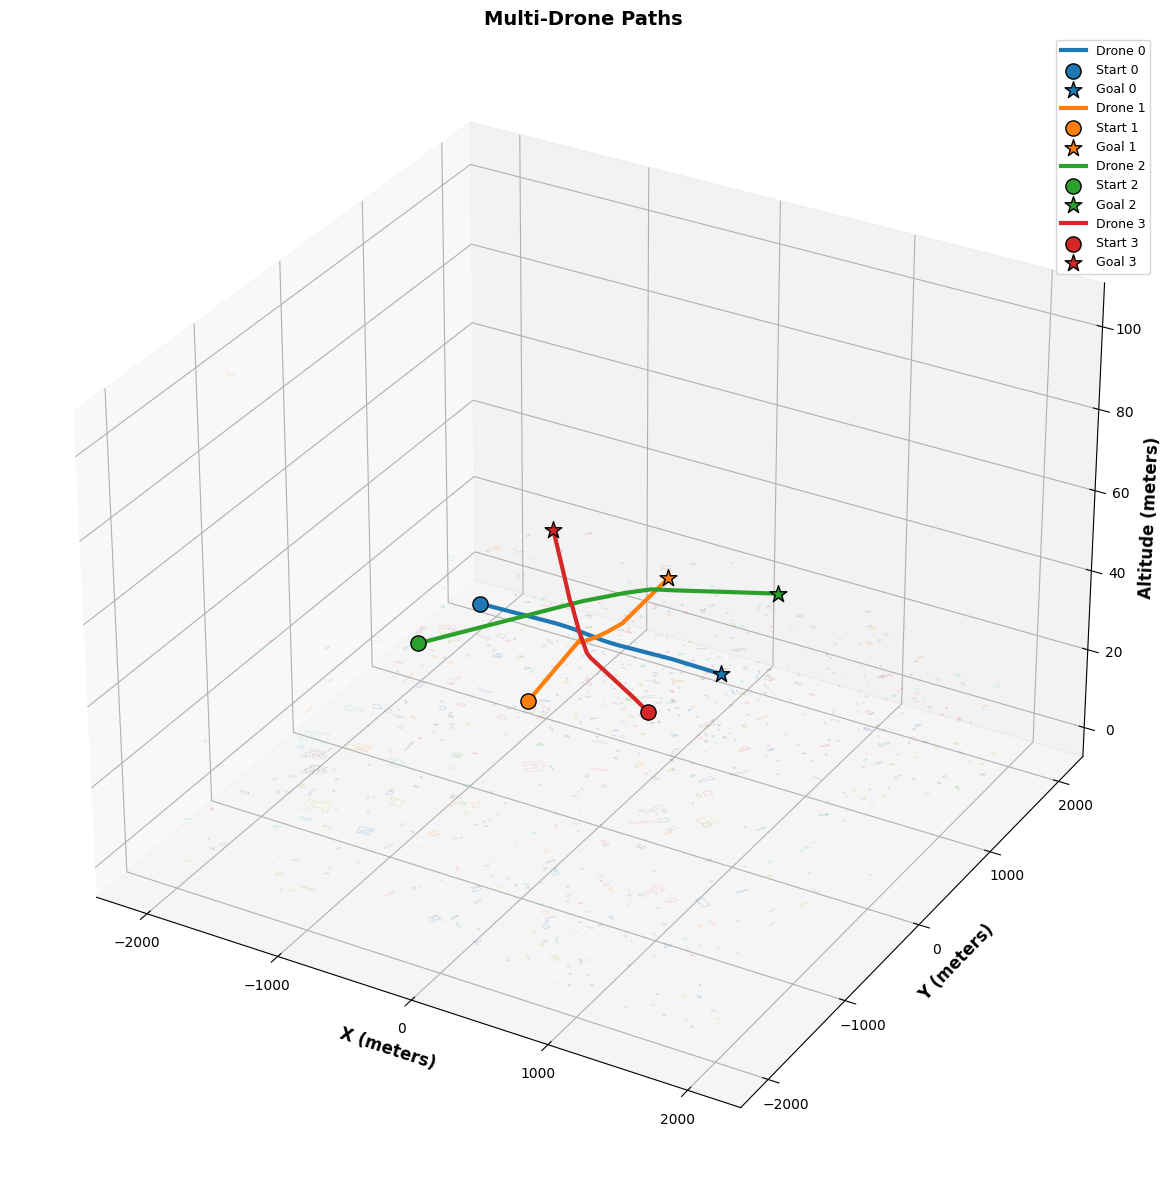

✓ Visualization complete

💾 Exporting paths...
  ✓ Saved: results/Scenario_6_FourWay_Intersection/drone_0_path.csv
  ✓ Saved: results/Scenario_6_FourWay_Intersection/drone_1_path.csv
  ✓ Saved: results/Scenario_6_FourWay_Intersection/drone_2_path.csv
  ✓ Saved: results/Scenario_6_FourWay_Intersection/drone_3_path.csv
✓ All paths exported

📊 SUMMARY — Scenario_6_FourWay_Intersection

Drone 0: Path=1803.5m | Detour=+0.2% | Altitude=40.0m

Drone 1: Path=1935.4m | Detour=+7.5% | Altitude=40.0m

Drone 2: Path=2476.2m | Detour=+3.0% | Altitude=45.0m

Drone 3: Path=2438.2m | Detour=+1.4% | Altitude=45.0m

Total Distance: 8653.3m | Avg Path: 2163.3m
Waypoints: 42 | Avg: 10.5

🔍 Checking for minimum inter-drone distances...
  Drone 0 ↔ 1: 43.7m ✅ SAFE
  Drone 0 ↔ 2: 62.2m ✅ SAFE
  Drone 0 ↔ 3: 24.6m ✅ SAFE
  Drone 1 ↔ 2: 134.8m ✅ SAFE
  Drone 1 ↔ 3: 98.3m ✅ SAFE
  Drone 2 ↔ 3: 93.4m ✅ SAFE

🎉 Scenario Complete: Scenario_6_FourWay_Intersection
📁 Results saved in: results/Scenario_6_FourWay_Inter

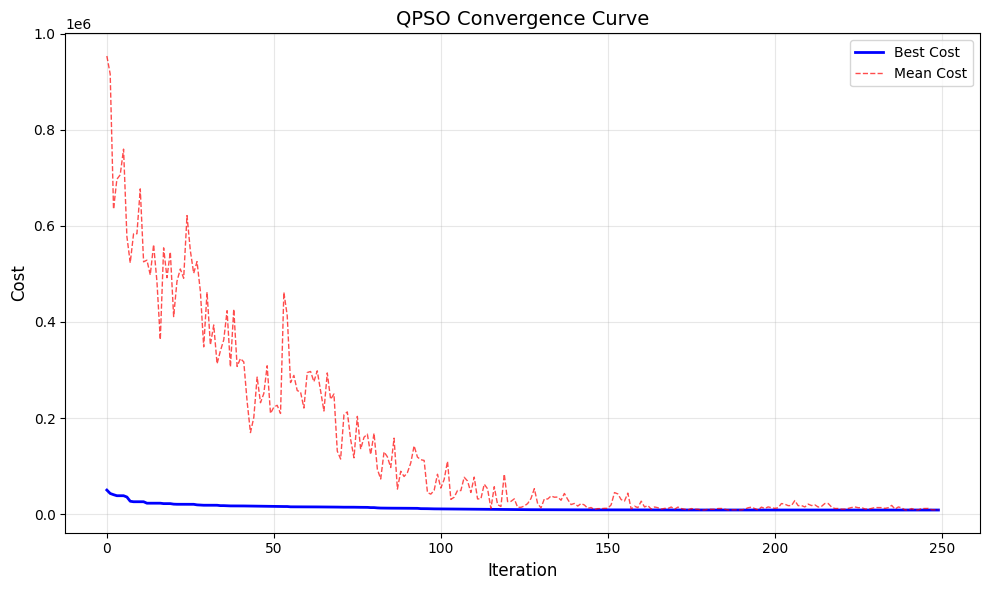

  ✓ Registered path for Drone 0 (10 waypoints)

✅ Drone 0 planning complete
   Path length: 2552.14m
   Waypoints: 10
   Altitude: 50.0m (mean)

🚁 PLANNING DRONE 1
Start Position:     [-800  800   50]
Goal Position:      [ 800 -800   50]
Assigned Altitude:  50.0m (band: 45.0-55.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2263m → +5 waypoints
Obstacles:          8 in corridor
Density:            0.000009
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 1
   Altitude band: 45.0-55.0m (center: 50.0m)

🚁 Multi-Drone Route Planning - Drone 1
Start Position:    [-800.  800.   50.]
Goal Position:     [ 800. -800.   50.]
Altitude Band:     45.0-55.0m (center: 50.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1000, 1000] Y:[-1000, 1000]

Iter     Best Cost       Mean Cost    

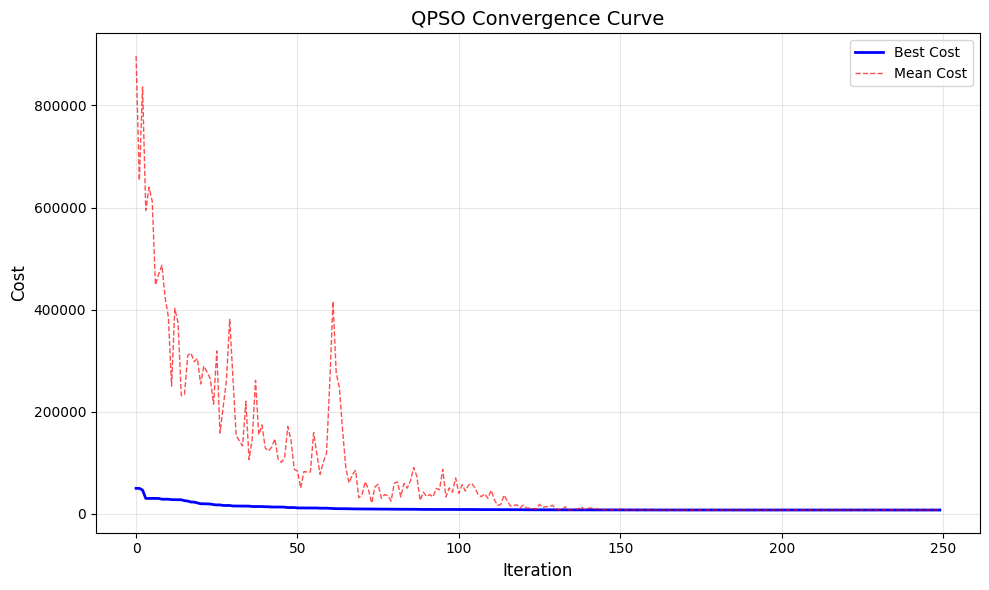

  ✓ Registered path for Drone 1 (11 waypoints)

✅ Drone 1 planning complete
   Path length: 2457.59m
   Waypoints: 11
   Altitude: 50.0m (mean)

🚁 PLANNING DRONE 2
Start Position:     [ 850 -850   70]
Goal Position:      [-850  850   40]
Assigned Altitude:  70.0m (band: 65.0-75.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2404m → +5 waypoints
Obstacles:          3 in corridor
Density:            0.000003
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 2
   Altitude band: 65.0-75.0m (center: 70.0m)

🚁 Multi-Drone Route Planning - Drone 2
Start Position:    [ 850. -850.   70.]
Goal Position:     [-850.  850.   40.]
Altitude Band:     65.0-75.0m (center: 70.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1050, 1050] Y:[-1050, 1050]

Iter     Best Cost       Mean Cost    

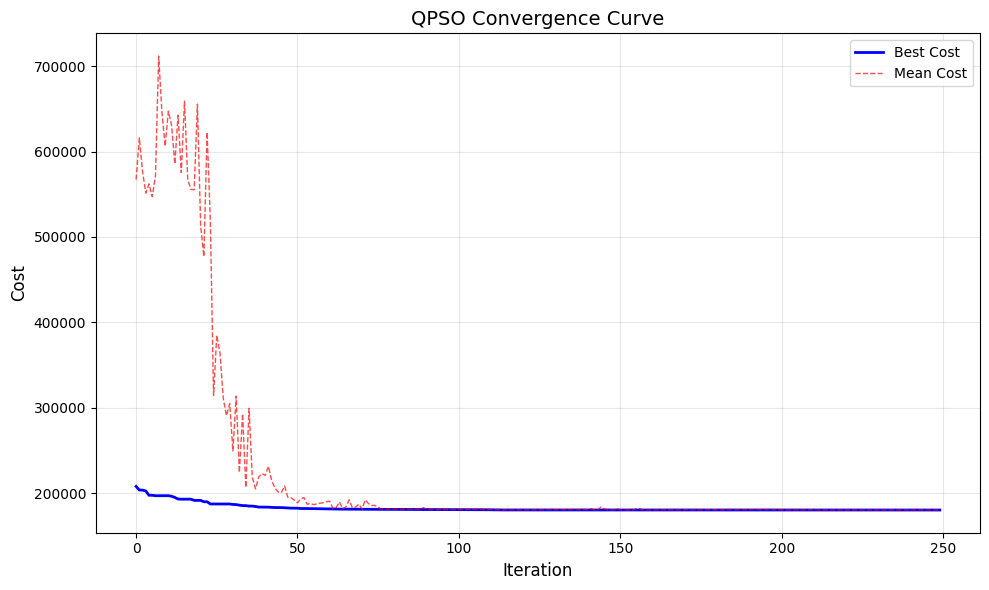

  ✓ Registered path for Drone 2 (11 waypoints)

✅ Drone 2 planning complete
   Path length: 2853.60m
   Waypoints: 11
   Altitude: 67.3m (mean)

🚁 PLANNING DRONE 3
Start Position:     [900 900  60]
Goal Position:      [-900 -900   60]
Assigned Altitude:  60.0m (band: 55.0-65.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2546m → +6 waypoints
Obstacles:          8 in corridor
Density:            0.000008
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    10


🚁 Planner initialized for Drone 3
   Altitude band: 55.0-65.0m (center: 60.0m)

🚁 Multi-Drone Route Planning - Drone 3
Start Position:    [900. 900.  60.]
Goal Position:     [-900. -900.   60.]
Altitude Band:     55.0-65.0m (center: 60.0m)
Waypoints:         10
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1100, 1100] Y:[-1100, 1100]

Iter     Best Cost       Mean Cost       S

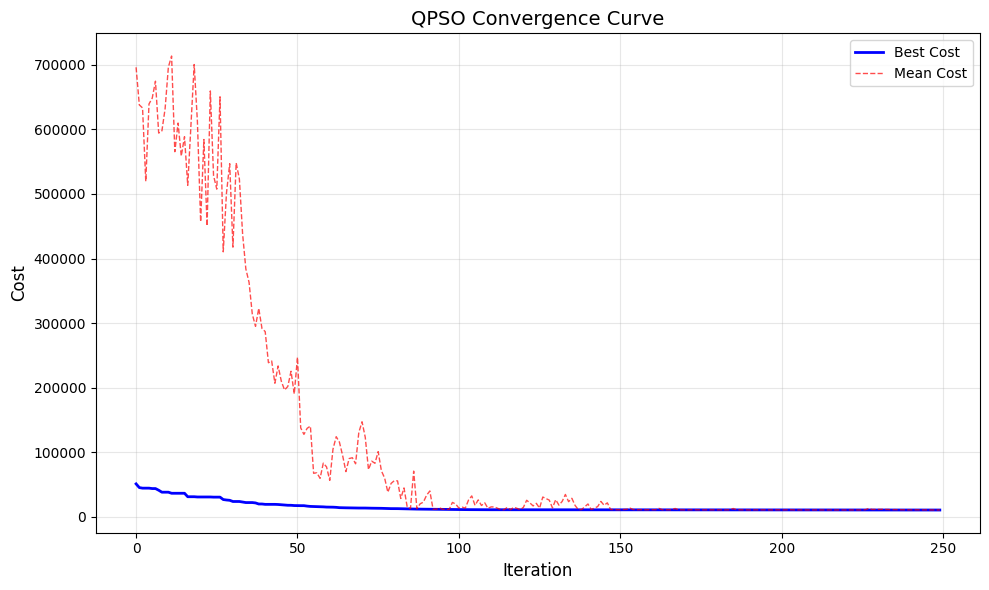

  ✓ Registered path for Drone 3 (12 waypoints)

✅ Drone 3 planning complete
   Path length: 3000.58m
   Waypoints: 12
   Altitude: 60.0m (mean)

✅ ALL DRONES PLANNED SUCCESSFULLY

📊 MULTI-DRONE PLANNING SUMMARY

Drone 0:
  Altitude Band:    45.0-55.0m
  Path Length:      2552.1m
  Waypoints:        10
  Mean Altitude:    50.0m
  Altitude Range:   50.0-50.1m

Drone 1:
  Altitude Band:    45.0-55.0m
  Path Length:      2457.6m
  Waypoints:        11
  Mean Altitude:    50.0m
  Altitude Range:   50.0-50.0m

Drone 2:
  Altitude Band:    65.0-75.0m
  Path Length:      2853.6m
  Waypoints:        11
  Mean Altitude:    67.3m
  Altitude Range:   40.0-70.0m

Drone 3:
  Altitude Band:    55.0-65.0m
  Path Length:      3000.6m
  Waypoints:        12
  Mean Altitude:    60.0m
  Altitude Range:   59.4-60.4m


  ✓ Saved: multi_drone_paths.npz (NumPy .npz compressed format)

✅ All drone paths planned successfully!

🎨 Visualizing...


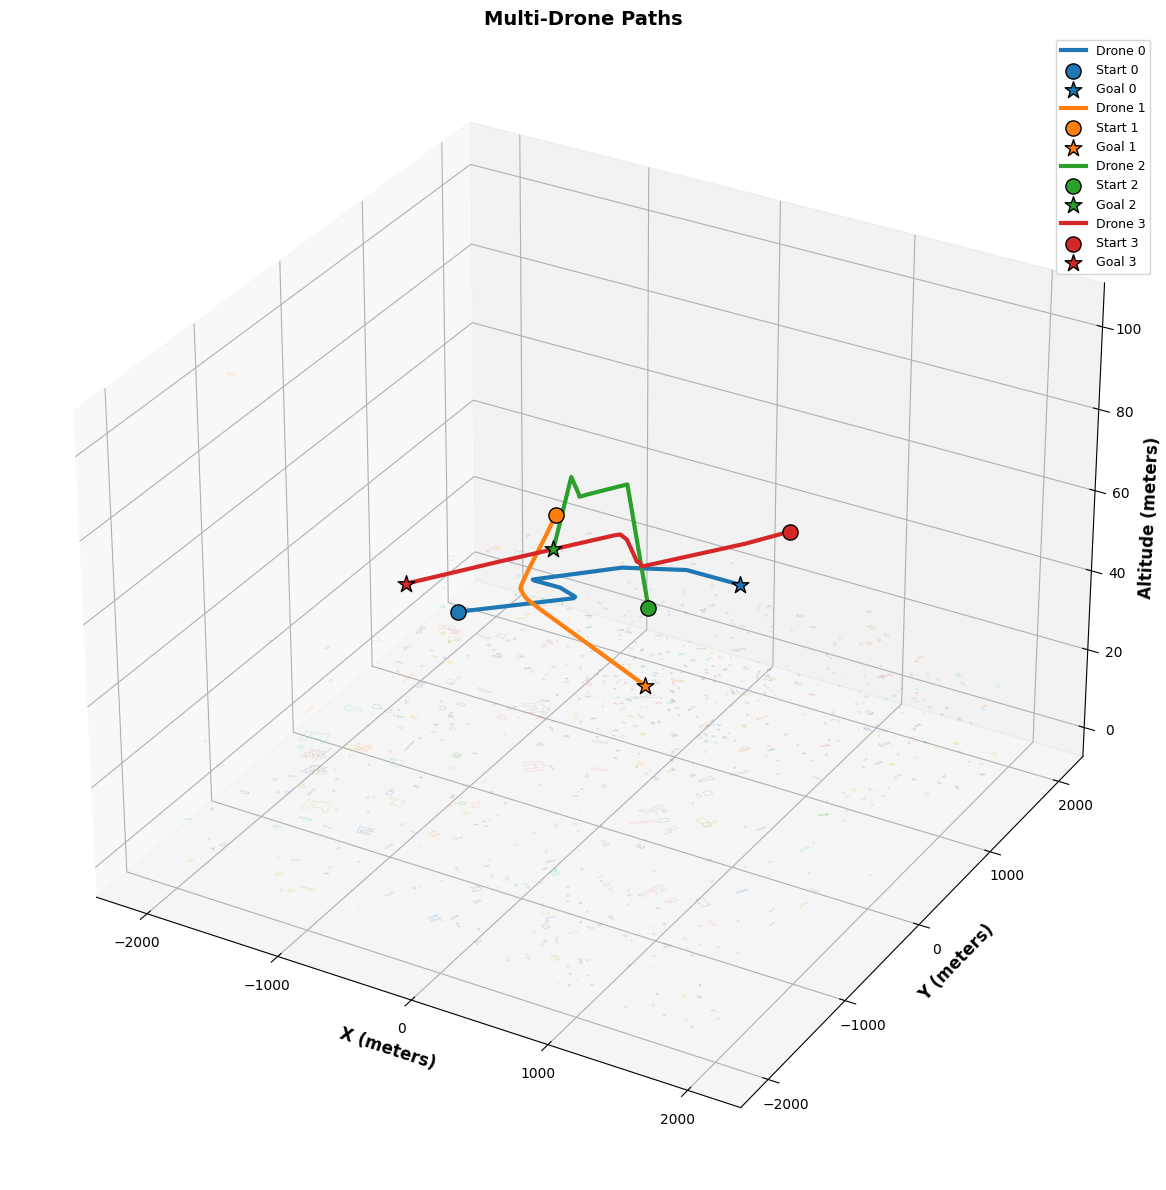

✓ Visualization complete

💾 Exporting paths...
  ✓ Saved: results/Scenario_7_Emergency_Descent_Intrusion/drone_0_path.csv
  ✓ Saved: results/Scenario_7_Emergency_Descent_Intrusion/drone_1_path.csv
  ✓ Saved: results/Scenario_7_Emergency_Descent_Intrusion/drone_2_path.csv
  ✓ Saved: results/Scenario_7_Emergency_Descent_Intrusion/drone_3_path.csv
✓ All paths exported

📊 SUMMARY — Scenario_7_Emergency_Descent_Intrusion

Drone 0: Path=2552.1m | Detour=+38.4% | Altitude=50.0m

Drone 1: Path=2457.6m | Detour=+8.6% | Altitude=50.0m

Drone 2: Path=2853.6m | Detour=+18.7% | Altitude=70.0m

Drone 3: Path=3000.6m | Detour=+17.9% | Altitude=60.0m

Total Distance: 10863.9m | Avg Path: 2716.0m
Waypoints: 44 | Avg: 11.0

🔍 Checking for minimum inter-drone distances...
  Drone 0 ↔ 1: 60.7m ✅ SAFE
  Drone 0 ↔ 2: 30.9m ✅ SAFE
  Drone 0 ↔ 3: 33.9m ✅ SAFE
  Drone 1 ↔ 2: 71.4m ✅ SAFE
  Drone 1 ↔ 3: 152.7m ✅ SAFE
  Drone 2 ↔ 3: 96.2m ✅ SAFE

🎉 Scenario Complete: Scenario_7_Emergency_Descent_Intrusion
📁 Resu

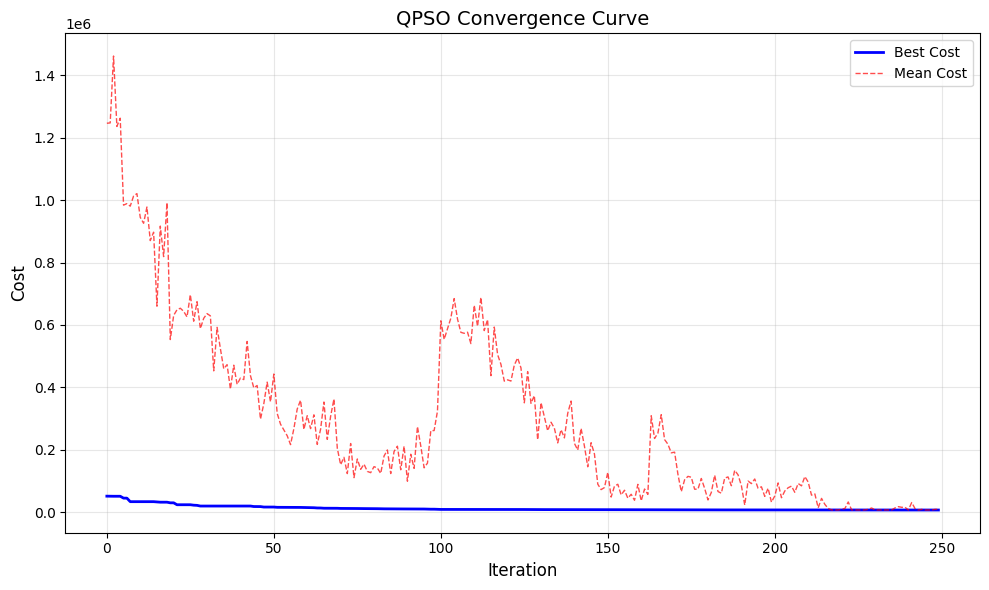

  ✓ Registered path for Drone 0 (11 waypoints)

✅ Drone 0 planning complete
   Path length: 2357.18m
   Waypoints: 11
   Altitude: 40.0m (mean)

🚁 PLANNING DRONE 1
Start Position:     [-700  700   40]
Goal Position:      [ 800 -600   40]
Assigned Altitude:  40.0m (band: 35.0-45.0m)

🔢 Dynamic Waypoint Calculation
Distance:           1985m → +4 waypoints
Obstacles:          12 in corridor
Density:            0.000015
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    8


🚁 Planner initialized for Drone 1
   Altitude band: 35.0-45.0m (center: 40.0m)

🚁 Multi-Drone Route Planning - Drone 1
Start Position:    [-700.  700.   40.]
Goal Position:     [ 800. -600.   40.]
Altitude Band:     35.0-45.0m (center: 40.0m)
Waypoints:         8
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-900, 1000] Y:[-800, 900]

Iter     Best Cost       Mean Cost      

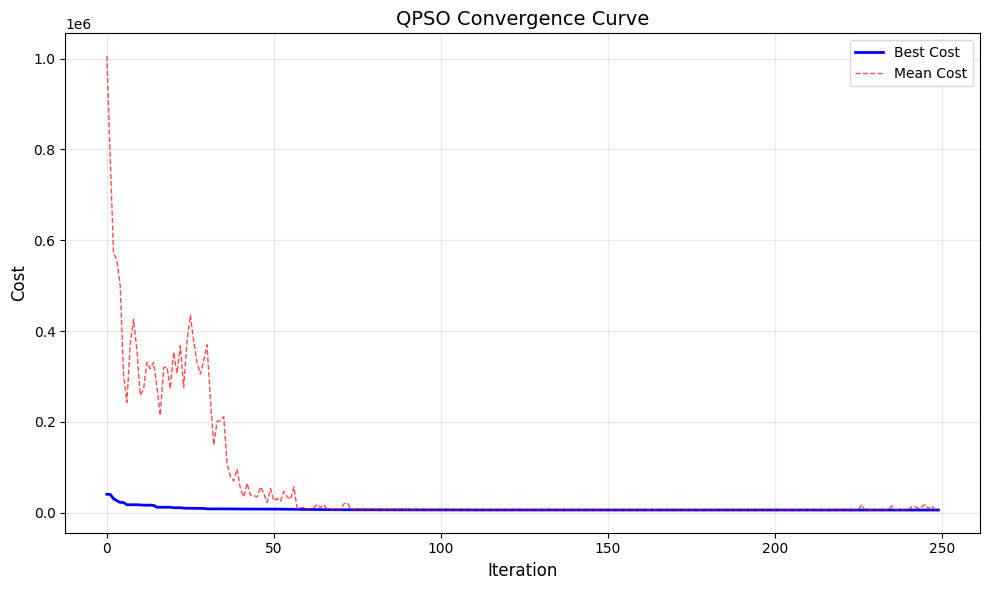

  ✓ Registered path for Drone 1 (10 waypoints)

✅ Drone 1 planning complete
   Path length: 2001.40m
   Waypoints: 10
   Altitude: 40.0m (mean)

🚁 PLANNING DRONE 2
Start Position:     [ 750 -650   45]
Goal Position:      [-750  650   45]
Assigned Altitude:  45.0m (band: 40.0-50.0m)

🔢 Dynamic Waypoint Calculation
Distance:           1985m → +4 waypoints
Obstacles:          12 in corridor
Density:            0.000015
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    8


🚁 Planner initialized for Drone 2
   Altitude band: 40.0-50.0m (center: 45.0m)

🚁 Multi-Drone Route Planning - Drone 2
Start Position:    [ 750. -650.   45.]
Goal Position:     [-750.  650.   45.]
Altitude Band:     40.0-50.0m (center: 45.0m)
Waypoints:         8
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-950, 950] Y:[-850, 850]

Iter     Best Cost       Mean Cost       

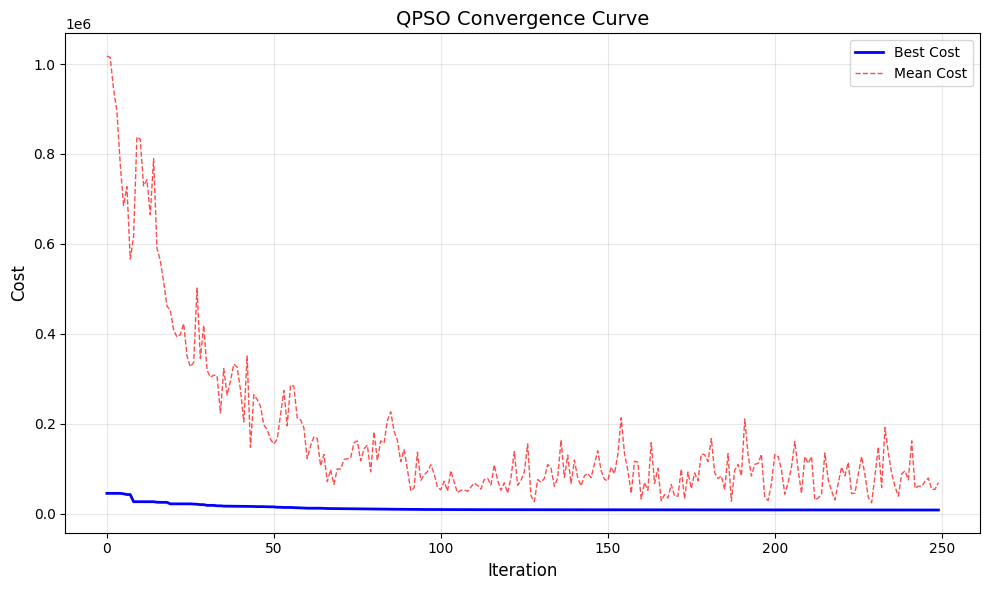

  ✓ Registered path for Drone 2 (10 waypoints)

✅ Drone 2 planning complete
   Path length: 2601.98m
   Waypoints: 10
   Altitude: 45.0m (mean)

🚁 PLANNING DRONE 3
Start Position:     [850 850  45]
Goal Position:      [-850 -850   45]
Assigned Altitude:  45.0m (band: 40.0-50.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2404m → +5 waypoints
Obstacles:          20 in corridor
Density:            0.000021
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 3
   Altitude band: 40.0-50.0m (center: 45.0m)

🚁 Multi-Drone Route Planning - Drone 3
Start Position:    [850. 850.  45.]
Goal Position:     [-850. -850.   45.]
Altitude Band:     40.0-50.0m (center: 45.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1050, 1050] Y:[-1050, 1050]

Iter     Best Cost       Mean Cost       St

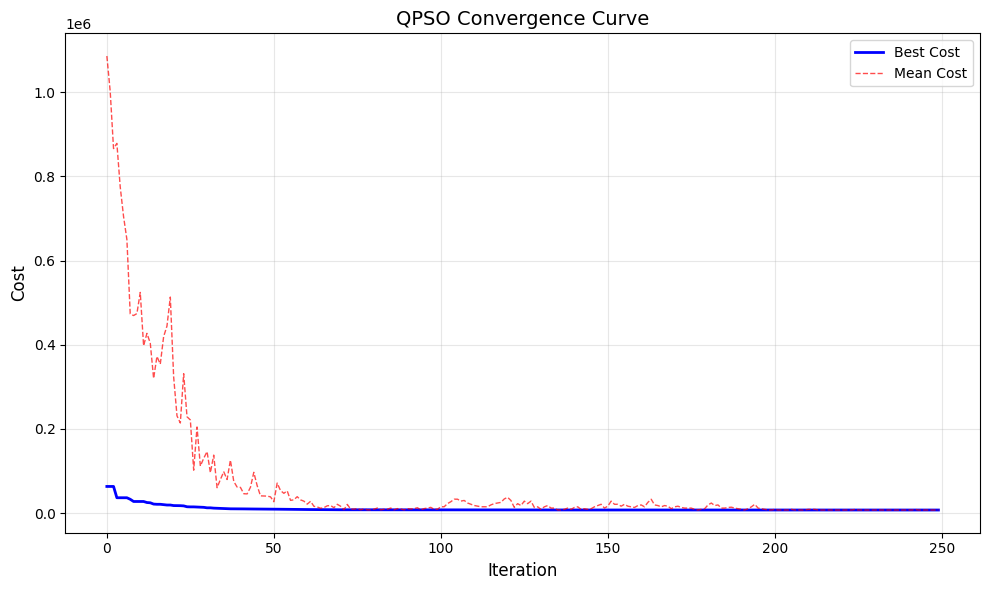

  ✓ Registered path for Drone 3 (11 waypoints)

✅ Drone 3 planning complete
   Path length: 2518.67m
   Waypoints: 11
   Altitude: 45.0m (mean)

✅ ALL DRONES PLANNED SUCCESSFULLY

📊 MULTI-DRONE PLANNING SUMMARY

Drone 0:
  Altitude Band:    35.0-45.0m
  Path Length:      2357.2m
  Waypoints:        11
  Mean Altitude:    40.0m
  Altitude Range:   40.0-40.0m

Drone 1:
  Altitude Band:    35.0-45.0m
  Path Length:      2001.4m
  Waypoints:        10
  Mean Altitude:    40.0m
  Altitude Range:   40.0-40.0m

Drone 2:
  Altitude Band:    40.0-50.0m
  Path Length:      2602.0m
  Waypoints:        10
  Mean Altitude:    45.0m
  Altitude Range:   45.0-45.0m

Drone 3:
  Altitude Band:    40.0-50.0m
  Path Length:      2518.7m
  Waypoints:        11
  Mean Altitude:    45.0m
  Altitude Range:   44.9-45.0m


  ✓ Saved: multi_drone_paths.npz (NumPy .npz compressed format)

✅ All drone paths planned successfully!

🎨 Visualizing...


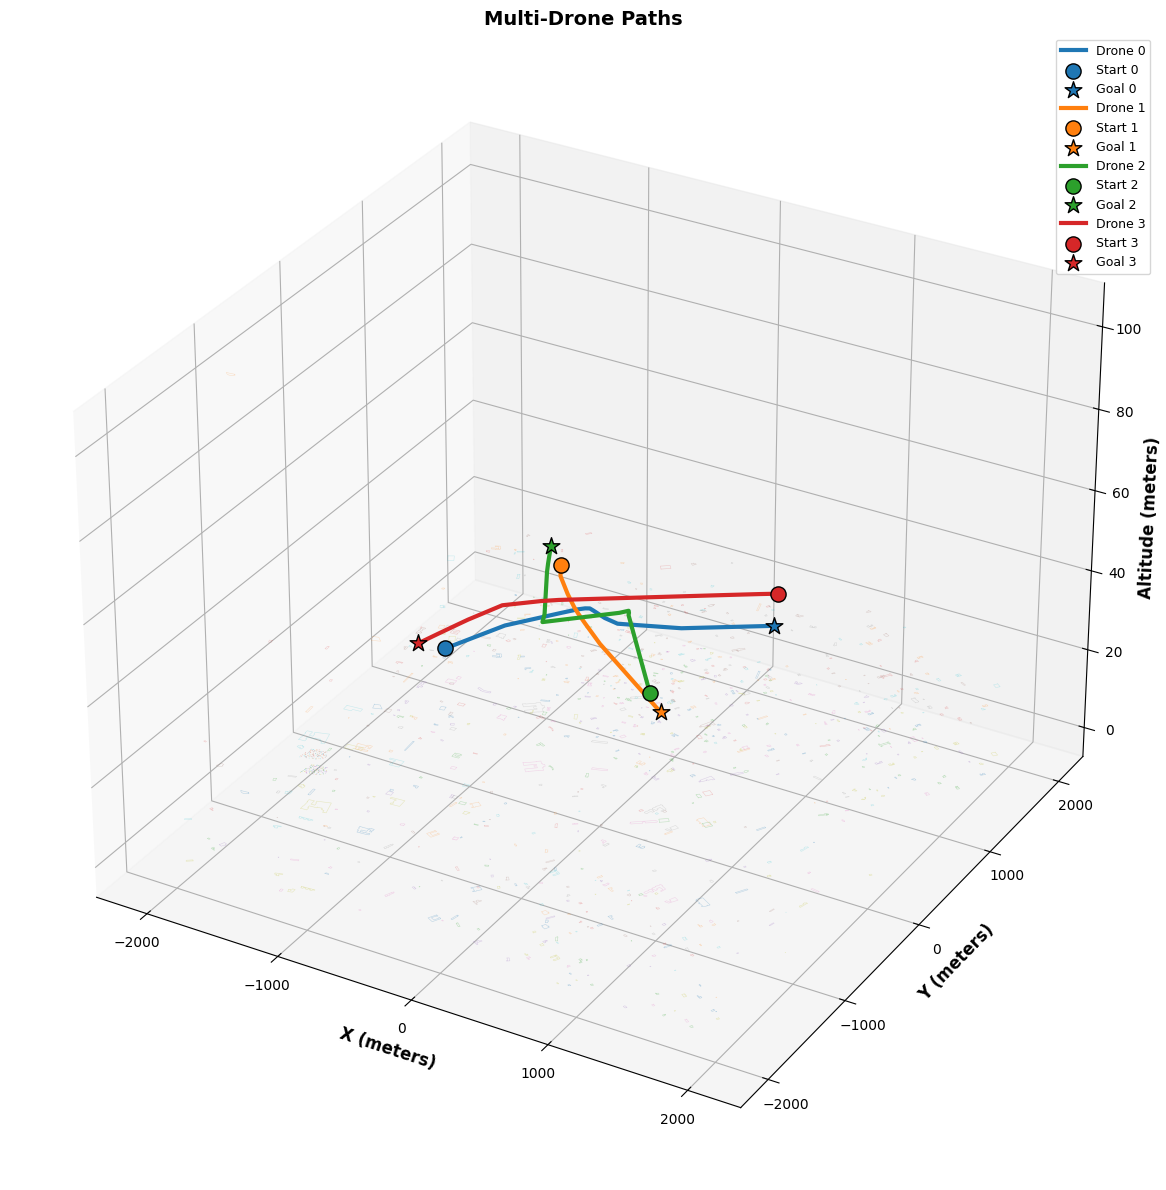

✓ Visualization complete

💾 Exporting paths...
  ✓ Saved: results/Scenario_8_Diagonal_WindDrift_Conflict/drone_0_path.csv
  ✓ Saved: results/Scenario_8_Diagonal_WindDrift_Conflict/drone_1_path.csv
  ✓ Saved: results/Scenario_8_Diagonal_WindDrift_Conflict/drone_2_path.csv
  ✓ Saved: results/Scenario_8_Diagonal_WindDrift_Conflict/drone_3_path.csv
✓ All paths exported

📊 SUMMARY — Scenario_8_Diagonal_WindDrift_Conflict

Drone 0: Path=2357.2m | Detour=+10.1% | Altitude=40.0m

Drone 1: Path=2001.4m | Detour=+0.8% | Altitude=40.0m

Drone 2: Path=2602.0m | Detour=+31.1% | Altitude=45.0m

Drone 3: Path=2518.7m | Detour=+4.8% | Altitude=45.0m

Total Distance: 9479.2m | Avg Path: 2369.8m
Waypoints: 42 | Avg: 10.5

🔍 Checking for minimum inter-drone distances...
  Drone 0 ↔ 1: 35.1m ✅ SAFE
  Drone 0 ↔ 2: 116.5m ✅ SAFE
  Drone 0 ↔ 3: 17.6m ✅ SAFE
  Drone 1 ↔ 2: 69.4m ✅ SAFE
  Drone 1 ↔ 3: 152.8m ✅ SAFE
  Drone 2 ↔ 3: 172.0m ✅ SAFE

🎉 Scenario Complete: Scenario_8_Diagonal_WindDrift_Conflict
📁 Resu

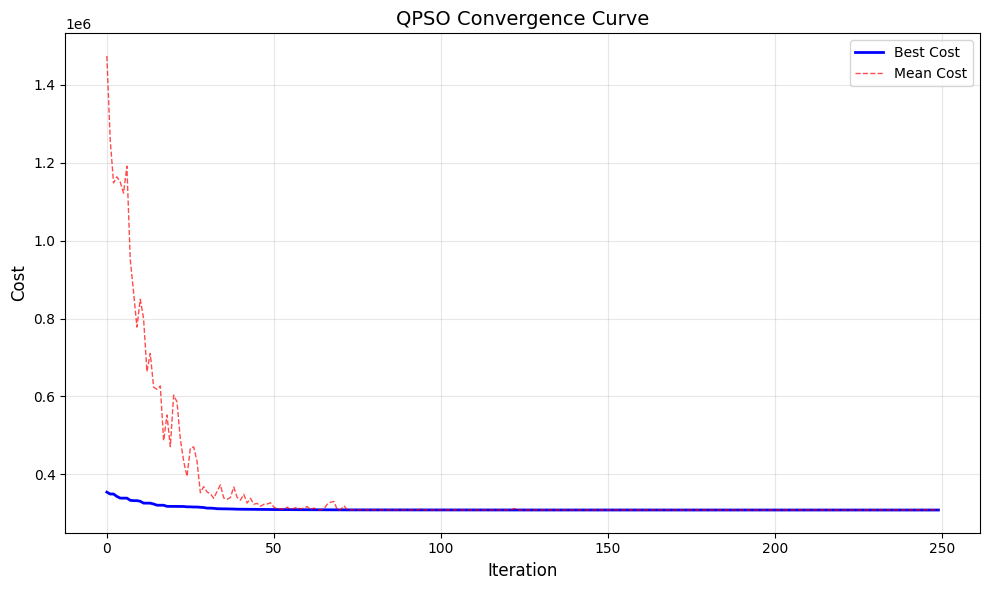

  ✓ Registered path for Drone 0 (11 waypoints)

✅ Drone 0 planning complete
   Path length: 2556.65m
   Waypoints: 11
   Altitude: 40.1m (mean)

🚁 PLANNING DRONE 1
Start Position:     [-850  850   40]
Goal Position:      [ 850 -850   40]
Assigned Altitude:  40.0m (band: 35.0-45.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2404m → +5 waypoints
Obstacles:          10 in corridor
Density:            0.000010
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 1
   Altitude band: 35.0-45.0m (center: 40.0m)

🚁 Multi-Drone Route Planning - Drone 1
Start Position:    [-850.  850.   40.]
Goal Position:     [ 850. -850.   40.]
Altitude Band:     35.0-45.0m (center: 40.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1050, 1050] Y:[-1050, 1050]

Iter     Best Cost       Mean Cost   

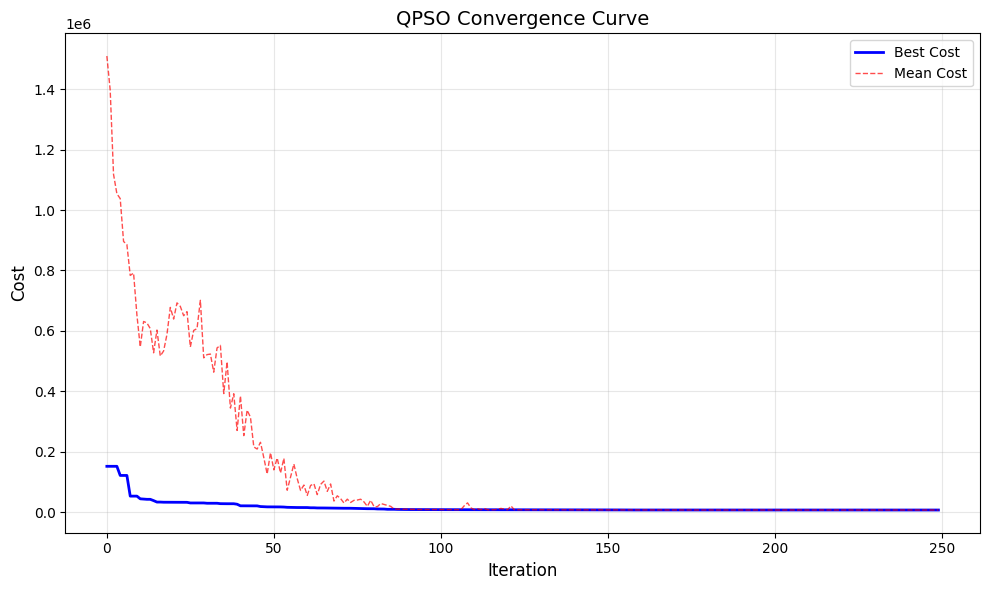

  ✓ Registered path for Drone 1 (11 waypoints)

✅ Drone 1 planning complete
   Path length: 2436.42m
   Waypoints: 11
   Altitude: 40.1m (mean)

🚁 PLANNING DRONE 2
Start Position:     [ 850 -850   40]
Goal Position:      [-850  850   40]
Assigned Altitude:  40.0m (band: 35.0-45.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2404m → +5 waypoints
Obstacles:          10 in corridor
Density:            0.000010
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 2
   Altitude band: 35.0-45.0m (center: 40.0m)

🚁 Multi-Drone Route Planning - Drone 2
Start Position:    [ 850. -850.   40.]
Goal Position:     [-850.  850.   40.]
Altitude Band:     35.0-45.0m (center: 40.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1050, 1050] Y:[-1050, 1050]

Iter     Best Cost       Mean Cost   

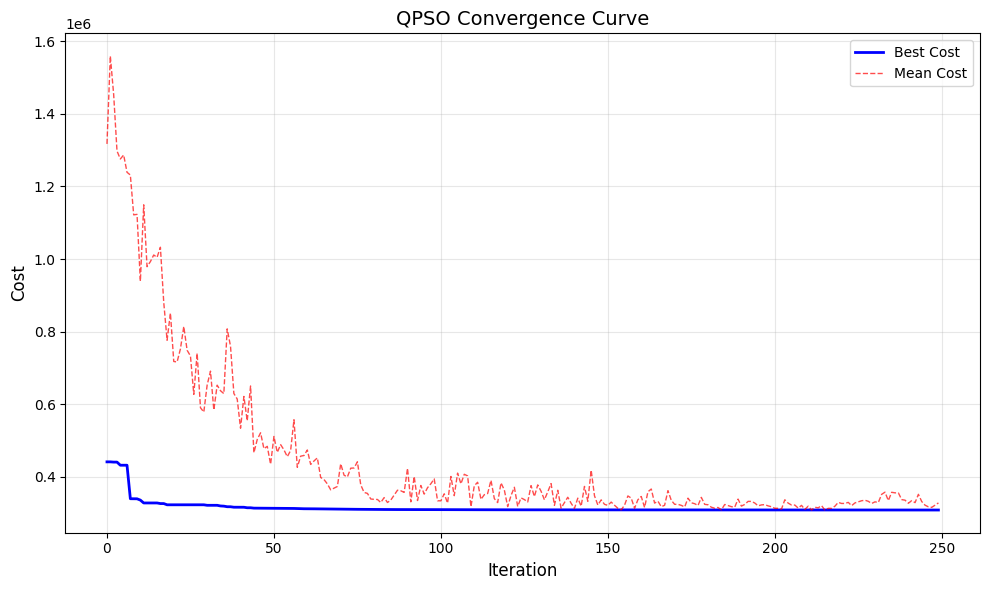

  ✓ Registered path for Drone 2 (11 waypoints)

✅ Drone 2 planning complete
   Path length: 2530.78m
   Waypoints: 11
   Altitude: 40.0m (mean)

🚁 PLANNING DRONE 3
Start Position:     [850 850  40]
Goal Position:      [-850 -850   40]
Assigned Altitude:  40.0m (band: 35.0-45.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2404m → +5 waypoints
Obstacles:          20 in corridor
Density:            0.000021
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 3
   Altitude band: 35.0-45.0m (center: 40.0m)

🚁 Multi-Drone Route Planning - Drone 3
Start Position:    [850. 850.  40.]
Goal Position:     [-850. -850.   40.]
Altitude Band:     35.0-45.0m (center: 40.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1050, 1050] Y:[-1050, 1050]

Iter     Best Cost       Mean Cost       St

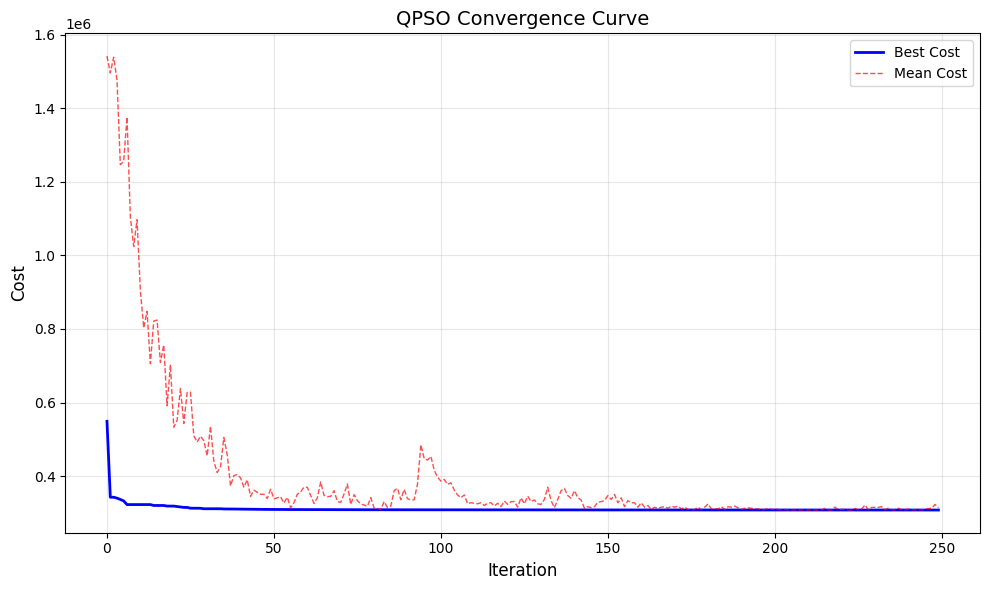

  ✓ Registered path for Drone 3 (11 waypoints)

✅ Drone 3 planning complete
   Path length: 2621.01m
   Waypoints: 11
   Altitude: 40.0m (mean)

✅ ALL DRONES PLANNED SUCCESSFULLY

📊 MULTI-DRONE PLANNING SUMMARY

Drone 0:
  Altitude Band:    35.0-45.0m
  Path Length:      2556.6m
  Waypoints:        11
  Mean Altitude:    40.1m
  Altitude Range:   40.0-40.7m

Drone 1:
  Altitude Band:    35.0-45.0m
  Path Length:      2436.4m
  Waypoints:        11
  Mean Altitude:    40.1m
  Altitude Range:   40.0-40.3m

Drone 2:
  Altitude Band:    35.0-45.0m
  Path Length:      2530.8m
  Waypoints:        11
  Mean Altitude:    40.0m
  Altitude Range:   40.0-40.1m

Drone 3:
  Altitude Band:    35.0-45.0m
  Path Length:      2621.0m
  Waypoints:        11
  Mean Altitude:    40.0m
  Altitude Range:   40.0-40.0m


  ✓ Saved: multi_drone_paths.npz (NumPy .npz compressed format)

✅ All drone paths planned successfully!

🎨 Visualizing...


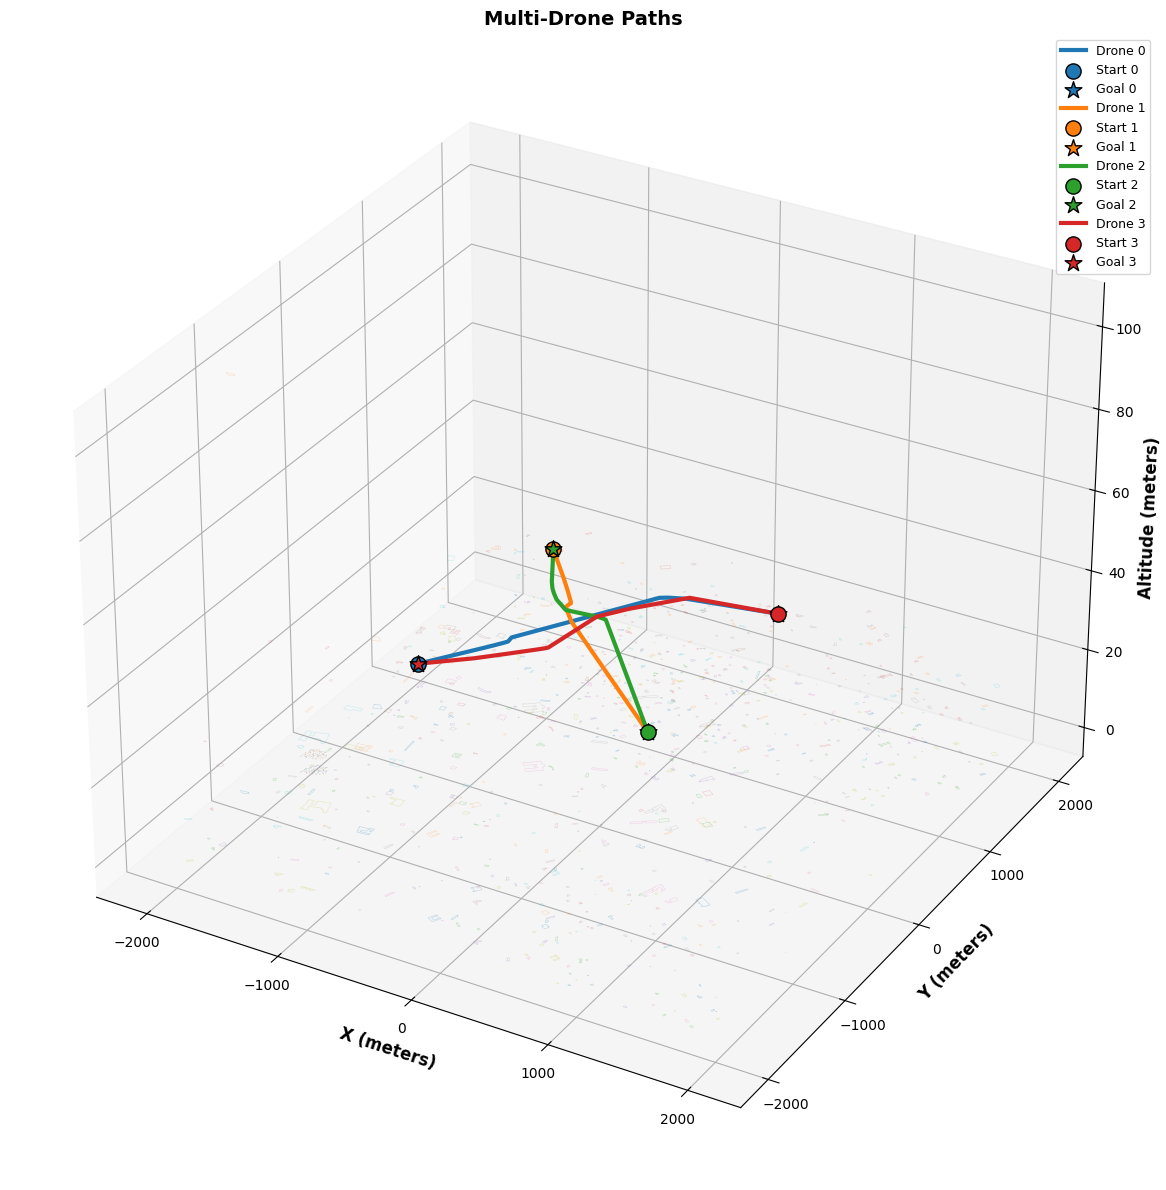

✓ Visualization complete

💾 Exporting paths...
  ✓ Saved: results/Scenario_9_Chain_Avoidance_Reaction/drone_0_path.csv
  ✓ Saved: results/Scenario_9_Chain_Avoidance_Reaction/drone_1_path.csv
  ✓ Saved: results/Scenario_9_Chain_Avoidance_Reaction/drone_2_path.csv
  ✓ Saved: results/Scenario_9_Chain_Avoidance_Reaction/drone_3_path.csv
✓ All paths exported

📊 SUMMARY — Scenario_9_Chain_Avoidance_Reaction

Drone 0: Path=2556.6m | Detour=+6.3% | Altitude=40.0m

Drone 1: Path=2436.4m | Detour=+1.3% | Altitude=40.0m

Drone 2: Path=2530.8m | Detour=+5.3% | Altitude=40.0m

Drone 3: Path=2621.0m | Detour=+9.0% | Altitude=40.0m

Total Distance: 10144.9m | Avg Path: 2536.2m
Waypoints: 44 | Avg: 11.0

🔍 Checking for minimum inter-drone distances...
  Drone 0 ↔ 1: 449.8m ✅ SAFE
  Drone 0 ↔ 2: 439.3m ✅ SAFE
  Drone 0 ↔ 3: 0.0m ⚠️ WARNING
  Drone 1 ↔ 2: 0.0m ⚠️ WARNING
  Drone 1 ↔ 3: 152.0m ✅ SAFE
  Drone 2 ↔ 3: 12.0m ✅ SAFE

🎉 Scenario Complete: Scenario_9_Chain_Avoidance_Reaction
📁 Results saved in:

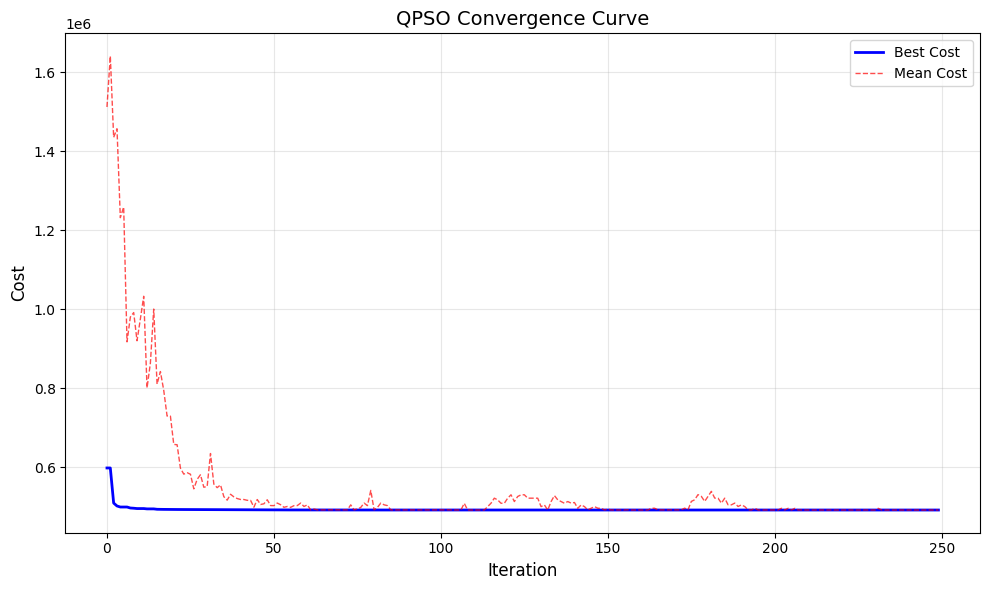

  ✓ Registered path for Drone 0 (8 waypoints)

✅ Drone 0 planning complete
   Path length: 750.03m
   Waypoints: 8
   Altitude: 70.4m (mean)

🚁 PLANNING DRONE 1
Start Position:     [500 500  50]
Goal Position:      [-100  100   50]
Assigned Altitude:  50.0m (band: 45.0-55.0m)

🔢 Dynamic Waypoint Calculation
Distance:           721m → +2 waypoints
Obstacles:          27 in corridor
Density:            0.000094
Complexity:         0.15 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    6


🚁 Planner initialized for Drone 1
   Altitude band: 45.0-55.0m (center: 50.0m)

🚁 Multi-Drone Route Planning - Drone 1
Start Position:    [500. 500.  50.]
Goal Position:     [-100.  100.   50.]
Altitude Band:     45.0-55.0m (center: 50.0m)
Waypoints:         6
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-300, 700] Y:[-100, 700]

Iter     Best Cost       Mean Cost       Std Cost  

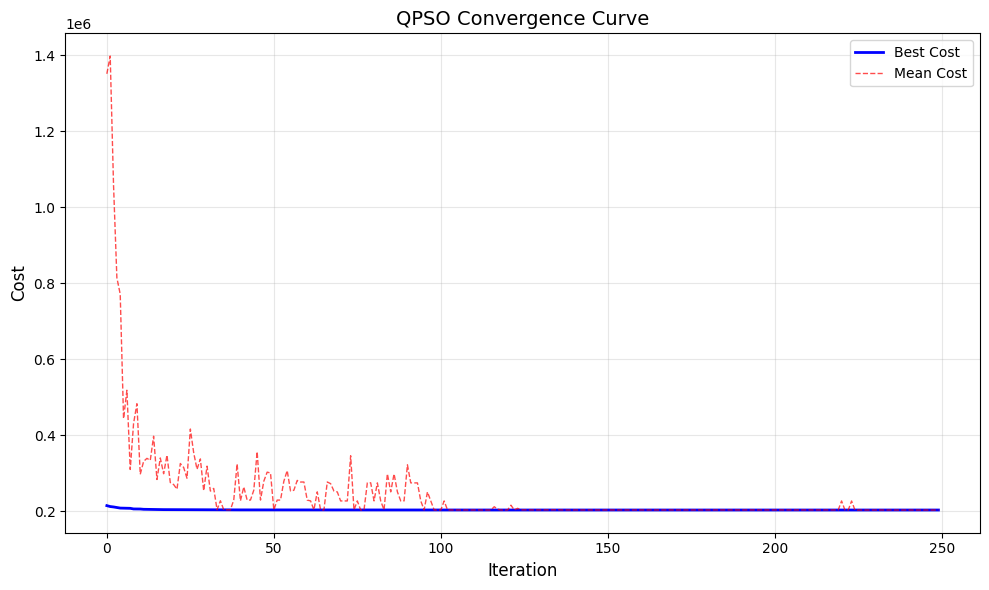

  ✓ Registered path for Drone 1 (8 waypoints)

✅ Drone 1 planning complete
   Path length: 997.16m
   Waypoints: 8
   Altitude: 50.0m (mean)

🚁 PLANNING DRONE 2
Start Position:     [-700  700   40]
Goal Position:      [ 700 -700   40]
Assigned Altitude:  40.0m (band: 35.0-45.0m)

🔢 Dynamic Waypoint Calculation
Distance:           1980m → +4 waypoints
Obstacles:          12 in corridor
Density:            0.000015
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    8


🚁 Planner initialized for Drone 2
   Altitude band: 35.0-45.0m (center: 40.0m)

🚁 Multi-Drone Route Planning - Drone 2
Start Position:    [-700.  700.   40.]
Goal Position:     [ 700. -700.   40.]
Altitude Band:     35.0-45.0m (center: 40.0m)
Waypoints:         8
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-900, 900] Y:[-900, 900]

Iter     Best Cost       Mean Cost       Std

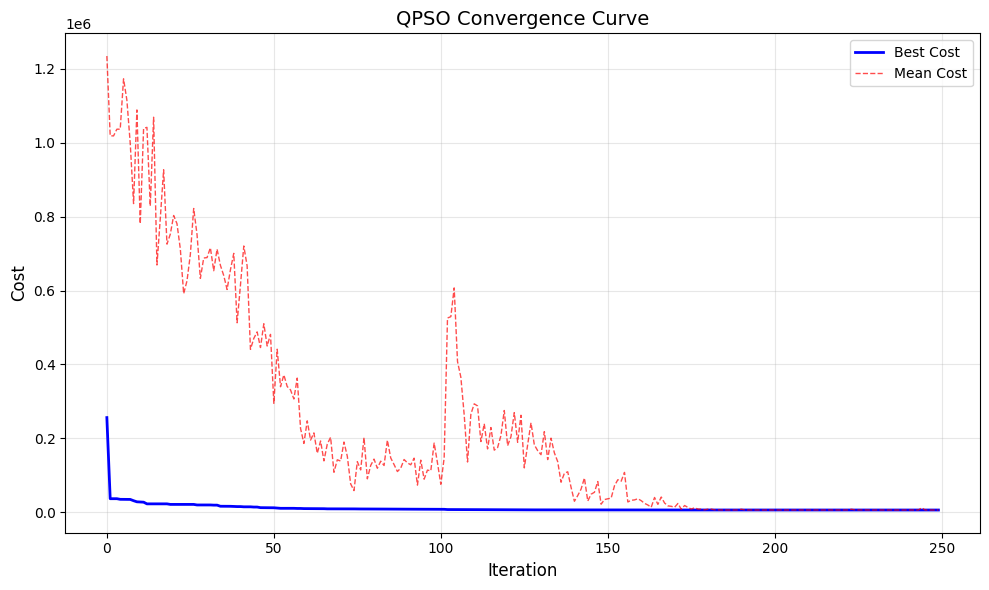

  ✓ Registered path for Drone 2 (10 waypoints)

✅ Drone 2 planning complete
   Path length: 2013.10m
   Waypoints: 10
   Altitude: 40.0m (mean)

🚁 PLANNING DRONE 3
Start Position:     [ 800 -800   40]
Goal Position:      [-800  800   40]
Assigned Altitude:  40.0m (band: 35.0-45.0m)

🔢 Dynamic Waypoint Calculation
Distance:           2263m → +5 waypoints
Obstacles:          11 in corridor
Density:            0.000012
Complexity:         0.10 → +0 waypoints
────────────────────────────────────────────────────────────
Final Waypoints:    9


🚁 Planner initialized for Drone 3
   Altitude band: 35.0-45.0m (center: 40.0m)

🚁 Multi-Drone Route Planning - Drone 3
Start Position:    [ 800. -800.   40.]
Goal Position:     [-800.  800.   40.]
Altitude Band:     35.0-45.0m (center: 40.0m)
Waypoints:         9
Strategy:          Direct routing + Multi-drone avoidance
Other Drones:      4 (avoiding their paths)
Search Corridor:   X:[-1000, 1000] Y:[-1000, 1000]

Iter     Best Cost       Mean Cost   

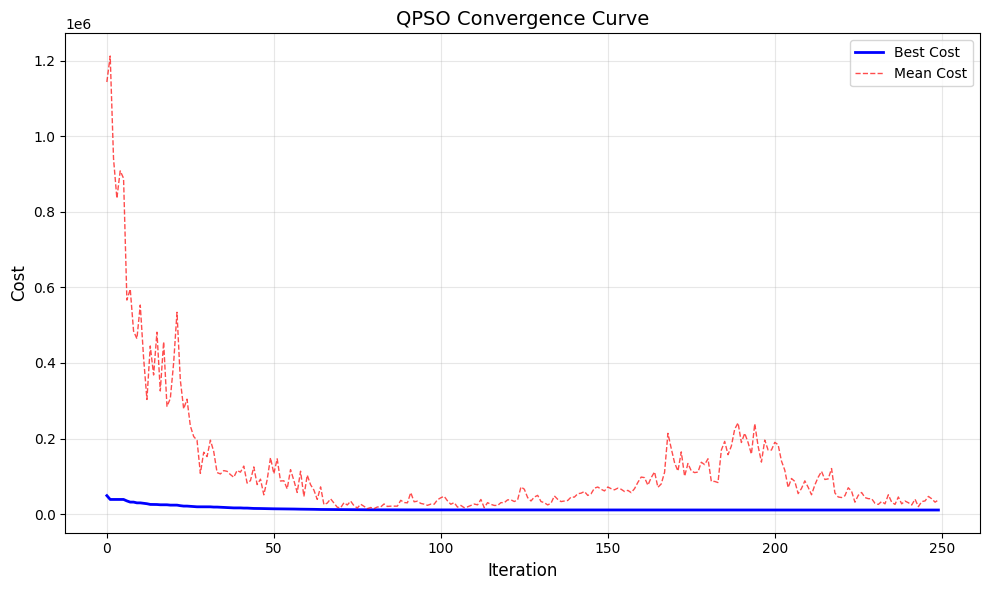

  ✓ Registered path for Drone 3 (11 waypoints)

✅ Drone 3 planning complete
   Path length: 3225.36m
   Waypoints: 11
   Altitude: 40.1m (mean)

✅ ALL DRONES PLANNED SUCCESSFULLY

📊 MULTI-DRONE PLANNING SUMMARY

Drone 0:
  Altitude Band:    75.0-85.0m
  Path Length:      750.0m
  Waypoints:        8
  Mean Altitude:    70.4m
  Altitude Range:   0.0-83.3m

Drone 1:
  Altitude Band:    45.0-55.0m
  Path Length:      997.2m
  Waypoints:        8
  Mean Altitude:    50.0m
  Altitude Range:   50.0-50.0m

Drone 2:
  Altitude Band:    35.0-45.0m
  Path Length:      2013.1m
  Waypoints:        10
  Mean Altitude:    40.0m
  Altitude Range:   40.0-40.1m

Drone 3:
  Altitude Band:    35.0-45.0m
  Path Length:      3225.4m
  Waypoints:        11
  Mean Altitude:    40.1m
  Altitude Range:   40.0-40.2m


  ✓ Saved: multi_drone_paths.npz (NumPy .npz compressed format)

✅ All drone paths planned successfully!

🎨 Visualizing...


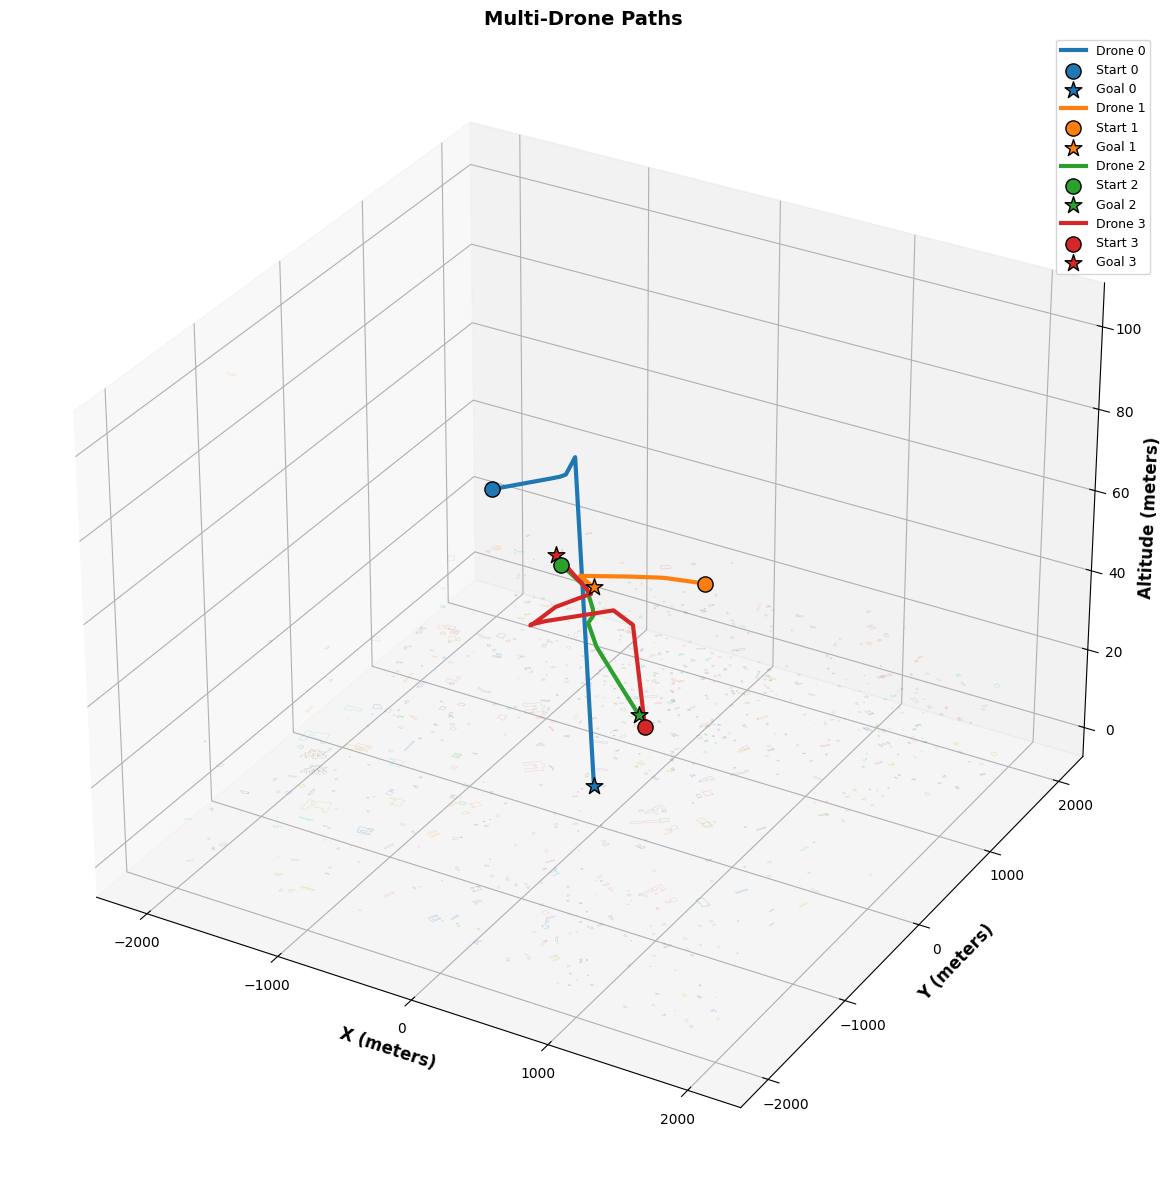

✓ Visualization complete

💾 Exporting paths...
  ✓ Saved: results/Scenario_10_LandingZone_Conflict/drone_0_path.csv
  ✓ Saved: results/Scenario_10_LandingZone_Conflict/drone_1_path.csv
  ✓ Saved: results/Scenario_10_LandingZone_Conflict/drone_2_path.csv
  ✓ Saved: results/Scenario_10_LandingZone_Conflict/drone_3_path.csv
✓ All paths exported

📊 SUMMARY — Scenario_10_LandingZone_Conflict

Drone 0: Path=750.0m | Detour=+3.4% | Altitude=80.0m

Drone 1: Path=997.2m | Detour=+38.3% | Altitude=50.0m

Drone 2: Path=2013.1m | Detour=+1.7% | Altitude=40.0m

Drone 3: Path=3225.4m | Detour=+42.5% | Altitude=40.0m

Total Distance: 6985.7m | Avg Path: 1746.4m
Waypoints: 37 | Avg: 9.2

🔍 Checking for minimum inter-drone distances...
  Drone 0 ↔ 1: 50.0m ✅ SAFE
  Drone 0 ↔ 2: 80.6m ✅ SAFE
  Drone 0 ↔ 3: 248.7m ✅ SAFE
  Drone 1 ↔ 2: 70.6m ✅ SAFE
  Drone 1 ↔ 3: 108.6m ✅ SAFE
  Drone 2 ↔ 3: 80.7m ✅ SAFE

🎉 Scenario Complete: Scenario_10_LandingZone_Conflict
📁 Results saved in: results/Scenario_10_Landin

In [ ]:
import pandas as pd
import numpy as np
import os

# ======================================================================
# DEFINE 10 SCENARIOS
# ======================================================================

scenarios_main = {
    "Scenario_11": [
        {'start': np.array([-800, -600, 40]), 'goal': np.array([900, 800, 40])},
        {'start': np.array([-700, 700, 40]),  'goal': np.array([800, -700, 40])},
        {'start': np.array([850, -850, 40]),  'goal': np.array([-850, 850, 40])},
        {'start': np.array([800, 800, 40]),   'goal': np.array([-800, -800, 40])},
        {'start': np.array([800, 800, 50]),   'goal': np.array([-800, -800, 50])},
    ],
    
}

# ======================================================================
# RUN ALL SCENARIOS
# ======================================================================

for scenario_name, drone_configs in scenarios_main.items():
    print("\n" + "="*80)
    print(f"🚁 MULTI-DRONE PATH PLANNING — {scenario_name}")
    print("="*80 + "\n")

    # Create output directory for this scenario
    os.makedirs(f"results/{scenario_name}", exist_ok=True)

    # STEP 1: Define and print configuration
    print("📋 Defining drone missions...")
    print(f"✓ Configured {len(drone_configs)} drone missions")
    for i, config in enumerate(drone_configs):
        print(f"  Drone {i}: {config['start'][:2]} → {config['goal'][:2]}")

    # STEP 2: Initialize Coordinator
    print("\n🎯 Initializing Multi-Drone Coordinator...")
    coordinator = MultiDroneCoordinator(berlin_env, drone_configs)
    print("✓ Coordinator ready")

    # STEP 3: Execute Coordinated Planning
    print("\n🚀 Starting coordinated path planning...\n")
    all_paths = coordinator.plan_all_paths(n_particles=50, max_iters=250)
    print("\n✅ All drone paths planned successfully!\n")

    # STEP 4: Visualization
    print("🎨 Visualizing...")
    coordinator.visualize_all()
    print("✓ Visualization complete\n")

    # STEP 5: Export Paths
    print("💾 Exporting paths...")
    for drone_id, path in all_paths.items():
        df = pd.DataFrame(path, columns=['X_meters', 'Y_meters', 'Altitude_meters'])
        df['Waypoint'] = range(len(path))
        df['Drone_ID'] = drone_id
        df['Waypoint_Type'] = ['Start'] + ['Intermediate']*(len(path)-2) + ['Goal']
        filename = f"results/{scenario_name}/drone_{drone_id}_path.csv"
        df.to_csv(filename, index=False)
        print(f"  ✓ Saved: {filename}")

    combined_data = []
    for drone_id, path in all_paths.items():
        for i, p in enumerate(path):
            combined_data.append({
                'Drone_ID': drone_id,
                'Waypoint': i,
                'X_meters': p[0],
                'Y_meters': p[1],
                'Altitude_meters': p[2],
                'Waypoint_Type': 'Start' if i == 0 else ('Goal' if i == len(path)-1 else 'Intermediate')
            })

    combined_df = pd.DataFrame(combined_data)
    combined_df.to_csv(f"results/{scenario_name}/all_drones_combined.csv", index=False)
    np.save(f"results/{scenario_name}/multi_drone_paths.npy", all_paths)
    print("✓ All paths exported\n")

    # STEP 6: Summary
    print("="*80)
    print(f"📊 SUMMARY — {scenario_name}")
    print("="*80)

    total_distance, total_waypoints = 0, 0
    for drone_id in range(len(drone_configs)):
        path = all_paths[drone_id]
        altitude_info = coordinator.altitude_manager.get_altitude_info(drone_id)
        path_length = sum(np.linalg.norm(path[i+1] - path[i]) for i in range(len(path)-1))
        straight_distance = np.linalg.norm(path[-1] - path[0])
        detour = ((path_length / straight_distance) - 1.0) * 100
        total_distance += path_length
        total_waypoints += len(path)
        print(f"\nDrone {drone_id}: Path={path_length:.1f}m | Detour=+{detour:.1f}% | "
              f"Altitude={altitude_info['center']:.1f}m")

    print(f"\nTotal Distance: {total_distance:.1f}m | Avg Path: {total_distance/len(drone_configs):.1f}m")
    print(f"Waypoints: {total_waypoints} | Avg: {total_waypoints/len(drone_configs):.1f}\n")

    # STEP 7: Collision Verification
    print("🔍 Checking for minimum inter-drone distances...")
    min_distances = {}
    for i in range(len(drone_configs)):
        for j in range(i+1, len(drone_configs)):
            path_i, path_j = all_paths[i], all_paths[j]
            min_dist = min(np.linalg.norm(pi - pj) for pi in path_i for pj in path_j)
            min_distances[f"Drone {i} ↔ {j}"] = min_dist

    for pair, dist in min_distances.items():
        status = "✅ SAFE" if dist >= berlin_env.drone_safety_radius else "⚠️ WARNING"
        print(f"  {pair}: {dist:.1f}m {status}")

    print("\n🎉 Scenario Complete:", scenario_name)
    print("📁 Results saved in:", f"results/{scenario_name}/")
    print("="*80 + "\n")


In [ ]:
import numpy as np
import pandas as pd
import os

class PathAccuracyAnalyzer:
    """
    Multi-Drone Path Accuracy Analyzer — Optimized for Jupyter + Scenario Integration
    -------------------------------------------------------------------------------
    Works directly with:
        - berlin_env (environment)
        - all_paths (dict of drone_id -> np.array of [x,y,z])
        - altitude_manager (from coordinator)
    
    Evaluates:
        - Path Efficiency
        - Altitude Band Compliance
        - Collision-Free Score
        - Smoothness Score
        - Energy Efficiency
        - Inter-Drone Safety
    """

    def __init__(self, env, all_paths, altitude_manager, scenario_name=None, save_dir="results"):
        self.env = env
        self.all_paths = {int(k): np.array(v) for k, v in all_paths.items()}
        self.altitude_manager = altitude_manager
        self.scenario_name = scenario_name
        self.save_dir = save_dir

        os.makedirs(save_dir, exist_ok=True)

    # ============================================================
    # MAIN ENTRY POINT
    # ============================================================
    def analyze_all(self, export_csv=True):
        print("\n" + "="*100)
        title = f"📊 PATH ACCURACY ANALYSIS - {self.scenario_name or 'Unnamed Scenario'}"
        print(title)
        print("="*100 + "\n")

        results = {}

        for drone_id, path in sorted(self.all_paths.items()):
            print(f"\n{'─'*80}")
            print(f"🚁 DRONE {drone_id} ANALYSIS")
            print(f"{'─'*80}")
            metrics = self._analyze_single_path(drone_id, path)
            results[drone_id] = metrics
            self._print_metrics(drone_id, metrics)

        self._system_analysis(results)

        # Export CSV per scenario
        if export_csv:
            filename = os.path.join(self.save_dir, f"{self.scenario_name or 'scenario'}_accuracy_report.csv")
            self._export_csv(results, filename)
        return results

    # ============================================================
    # PER-DRONE METRICS
    # ============================================================
    def _analyze_single_path(self, drone_id, path):
        info = self.altitude_manager.get_altitude_info(drone_id)
        path = np.array(path)

        metrics = {
            "path_efficiency": self._path_efficiency(path),
            "altitude_compliance": self._altitude_compliance(path, info),
            "collision_free_score": self._collision_score(path, drone_id),
            "smoothness_score": self._smoothness(path),
            "energy_efficiency": self._energy(path),
        }

        metrics["overall_accuracy"] = self._weighted_score(metrics)
        return metrics

    # ============================================================
    # METRIC DEFINITIONS
    # ============================================================
    def _path_efficiency(self, path):
        if len(path) < 2:
            return {"score": 0.0, "detour_percent": 0.0}
        straight = np.linalg.norm(path[-1] - path[0])
        actual = sum(np.linalg.norm(path[i+1] - path[i]) for i in range(len(path)-1))
        efficiency = (straight / actual) * 100 if actual > 0 else 0
        detour = ((actual / straight) - 1) * 100 if straight > 0 else 0
        return {"score": efficiency, "detour_percent": detour}

    def _altitude_compliance(self, path, info):
        if len(path) == 0:
            return {"score": 0.0, "within": 0, "total": 0}
        alts = path[:, 2]
        within = np.sum((alts >= info["min"]) & (alts <= info["max"]))
        compliance = (within / len(alts)) * 100
        return {"score": compliance, "within": within, "total": len(alts)}

    def _collision_score(self, path, drone_id):
        b_col, d_col = 0, 0
        for p in path:
            if hasattr(self.env, "is_collision") and self.env.is_collision(p):
                b_col += 1
            if hasattr(self.env, "is_drone_collision") and self.env.is_drone_collision(p, exclude_drone=drone_id):
                d_col += 1
        score = max(0, 100 - (b_col * 10) - (d_col * 15))
        return {"score": score, "building": b_col, "drone": d_col}

    def _smoothness(self, path):
        if len(path) < 3:
            return {"score": 100.0, "avg_angle": 0.0}
        angles = []
        for i in range(1, len(path)-1):
            v1 = path[i] - path[i-1]
            v2 = path[i+1] - path[i]
            if np.linalg.norm(v1) > 1e-6 and np.linalg.norm(v2) > 1e-6:
                cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))
                angles.append(np.degrees(np.arccos(np.clip(cos_angle, -1, 1))))
        avg = np.mean(angles)
        score = np.clip(100 - (avg / 1.8), 0, 100)
        return {"score": score, "avg_angle": avg}

    def _energy(self, path):
        if len(path) < 2:
            return {"score": 100.0}
        vertical_changes = np.abs(np.diff(path[:, 2]))
        total_vertical = np.sum(vertical_changes)
        score = np.clip(100 - (total_vertical / 10), 0, 100)
        return {"score": score, "vertical_travel": total_vertical}

    # ============================================================
    # OVERALL WEIGHTED SCORE
    # ============================================================
    def _weighted_score(self, m):
        w = {"collision_free_score": 0.30, "altitude_compliance": 0.25, "path_efficiency": 0.20,
             "smoothness_score": 0.15, "energy_efficiency": 0.10}
        return (m["collision_free_score"]["score"] * w["collision_free_score"] +
                m["altitude_compliance"]["score"] * w["altitude_compliance"] +
                m["path_efficiency"]["score"] * w["path_efficiency"] +
                m["smoothness_score"]["score"] * w["smoothness_score"] +
                m["energy_efficiency"]["score"] * w["energy_efficiency"])

    # ============================================================
    # REPORTING + SYSTEM LEVEL
    # ============================================================
    def _print_metrics(self, drone_id, m):
        print(f"1️⃣ Efficiency: {m['path_efficiency']['score']:.2f}% (Detour: +{m['path_efficiency']['detour_percent']:.1f}%)")
        print(f"2️⃣ Altitude: {m['altitude_compliance']['score']:.2f}% within band")
        print(f"3️⃣ Collision-Free: {m['collision_free_score']['score']:.2f}% "
              f"(Bld: {m['collision_free_score']['building']}, Drone: {m['collision_free_score']['drone']})")
        print(f"4️⃣ Smoothness: {m['smoothness_score']['score']:.2f}% (Avg Turn: {m['smoothness_score']['avg_angle']:.1f}°)")
        print(f"5️⃣ Energy: {m['energy_efficiency']['score']:.2f}% (Vertical Δ={m['energy_efficiency']['vertical_travel']:.1f}m)")
        print(f"📊 Overall Accuracy: {m['overall_accuracy']:.2f}%\n")

    def _system_analysis(self, results):
        print("\n" + "="*100)
        print("🌐 SYSTEM-WIDE ANALYSIS")
        print("="*100)
        avg_score = np.mean([r["overall_accuracy"] for r in results.values()])
        print(f"\nOVERALL SYSTEM SCORE: {avg_score:.2f}%")

        dists = self._inter_drone_distances()
        print("\n🛡️ INTER-DRONE SAFETY:")
        for k, v in dists.items():
            safe = "✅" if v >= self.env.drone_safety_radius else "⚠️"
            print(f"  {k}: {v:.1f}m {safe}")

    def _inter_drone_distances(self):
        ids = sorted(self.all_paths.keys())
        min_d = {}
        for i in range(len(ids)):
            for j in range(i+1, len(ids)):
                p_i, p_j = self.all_paths[ids[i]], self.all_paths[ids[j]]
                min_dist = min(np.linalg.norm(a - b) for a in p_i for b in p_j)
                min_d[f"D{ids[i]}↔D{ids[j]}"] = min_dist
        return min_d

    def _export_csv(self, results, filename):
        df = pd.DataFrame([{
            "Drone_ID": d,
            "Overall_Accuracy": r["overall_accuracy"],
            "Efficiency": r["path_efficiency"]["score"],
            "Altitude": r["altitude_compliance"]["score"],
            "Collision_Free": r["collision_free_score"]["score"],
            "Smoothness": r["smoothness_score"]["score"],
            "Energy": r["energy_efficiency"]["score"]
        } for d, r in results.items()])
        df.to_csv(filename, index=False)
        print(f"\n✓ Accuracy Report Exported: {filename}")

    def export_to_csv(self, results, filename="path_accuracy_report.csv"):
        """
        Export analyzed results (dict or list of dicts) to CSV.
        Returns:
            pandas.DataFrame
        """
        import pandas as pd
        import os

        os.makedirs(os.path.dirname(filename), exist_ok=True)

        # Convert to DataFrame
        if isinstance(results, dict):
            df = pd.DataFrame([results])
        elif isinstance(results, list):
            df = pd.DataFrame(results)
        else:
            raise TypeError("Results must be a dict or list of dicts.")

        # Save to CSV
        df.to_csv(filename, index=False)
        print(f"✅ Path accuracy report saved → {filename}")

        return df
    

print("✓ PathAccuracyAnalyzer (optimized) loaded successfully")


✓ PathAccuracyAnalyzer (optimized) loaded successfully


In [ ]:
# ==============================================================================
# STEP 8 (UPDATED): PATH ACCURACY ANALYSIS FOR ALL SCENARIOS
# ==============================================================================

import os
import numpy as np

print("\n🧮 Running Path Accuracy Analysis for all scenarios...")

export_to_csv = True

# Ensure results folder exists
os.makedirs("results", exist_ok=True)

# Loop through each scenario
for scenario_name, drone_configs in scenarios_main.items():
    scenario_dir = f"results/{scenario_name}"
    npy_path = os.path.join(scenario_dir, "multi_drone_paths.npy")

    # Skip scenarios without planned paths
    if not os.path.exists(npy_path):
        print(f"\n⚠️  Skipping {scenario_name}: no 'multi_drone_paths.npy' found.")
        continue

    print("\n" + "="*80)
    print(f"🧭 PATH ACCURACY ANALYSIS — {scenario_name}")
    print("="*80)

    # Load paths
    all_paths = np.load(npy_path, allow_pickle=True).item()

    # Define report output path
    report_path = os.path.join(scenario_dir, "multi_drone_accuracy_report.csv")

    # Initialize analyzer
    analyzer = PathAccuracyAnalyzer(
        berlin_env,
        all_paths,
        coordinator.altitude_manager,
        scenario_name=scenario_name,
        save_dir=scenario_dir
    )

    # Run analysis
    results = analyzer.analyze_all()

    # Export report if enabled
    if export_to_csv:
        try:
            df = analyzer.export_to_csv(results, filename=report_path)
            print(f"📈 Saved accuracy report → {report_path}")
        except AttributeError:
            # Fallback if export_to_csv method missing
            import pandas as pd
            df = pd.DataFrame(results)
            df.to_csv(report_path, index=False)
            print(f"📈 (Fallback) Saved accuracy report → {report_path}")

    print(f"✅ Completed Path Accuracy Analysis for: {scenario_name}")
    print("="*80 + "\n")

print("\n✅ All scenarios analyzed successfully!")
print("📁 Check 'results/<scenario_name>/multi_drone_accuracy_report.csv' for reports.")



🧮 Running Path Accuracy Analysis for all scenarios...

🧭 PATH ACCURACY ANALYSIS — Scenario_1_HeadOn_Central_Crossing

📊 PATH ACCURACY ANALYSIS - Scenario_1_HeadOn_Central_Crossing


────────────────────────────────────────────────────────────────────────────────
🚁 DRONE 0 ANALYSIS
────────────────────────────────────────────────────────────────────────────────
1️⃣ Efficiency: 98.98% (Detour: +1.0%)
2️⃣ Altitude: 0.00% within band
3️⃣ Collision-Free: 100.00% (Bld: 0, Drone: 0)
4️⃣ Smoothness: 97.43% (Avg Turn: 4.6°)
5️⃣ Energy: 99.98% (Vertical Δ=0.2m)
📊 Overall Accuracy: 74.41%


────────────────────────────────────────────────────────────────────────────────
🚁 DRONE 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────
1️⃣ Efficiency: 82.17% (Detour: +21.7%)
2️⃣ Altitude: 0.00% within band
3️⃣ Collision-Free: 85.00% (Bld: 0, Drone: 1)
4️⃣ Smoothness: 87.71% (Avg Turn: 22.1°)
5️⃣ Energy: 100.00% (Vertical Δ=0.0m)
📊 Overall Accuracy: 65.09%


─────

In [ ]:
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from shapely.geometry import Polygon, MultiPolygon

# ============================================================
# 1️⃣  MULTI-DRONE PLOTLY VISUALIZER CLASS
# ============================================================

class MultiDronePlotly:
    """
    Interactive 3D visualization with Plotly
    - Rotate, zoom, pan
    - Toggle drones on/off
    - Color-coded paths
    - Building rendering (Polygon / MultiPolygon supported)
    """

    def __init__(self, env, all_paths, altitude_manager):
        self.env = env
        self.all_paths = {int(k): np.array(v) for k, v in all_paths.items()}
        self.altitude_manager = altitude_manager

    def create_figure(self):
        fig = go.Figure()

        # Add buildings if available
        buildings_gdf = getattr(self.env, 'buildings_gdf', None)
        sample_rate = 1
        if buildings_gdf is not None and len(buildings_gdf) > 0:
            sample_rate = max(1, len(buildings_gdf) // 300)
            for idx, row in buildings_gdf[::sample_rate].iterrows():
                geom = row.get('local_geom', None)
                height = float(row.get('height', 0.0))
                if geom is None:
                    continue

                polys = []
                if isinstance(geom, Polygon):
                    polys = [geom]
                elif isinstance(geom, MultiPolygon):
                    polys = list(geom.geoms)
                else:
                    continue

                main_poly = max(polys, key=lambda p: p.area)
                coords = np.array(main_poly.exterior.coords)
                x, y = coords[:, 0], coords[:, 1]

                fig.add_trace(go.Scatter3d(x=x, y=y, z=[0]*len(x), mode='lines',
                                           line=dict(color='black', width=1), opacity=0.35, showlegend=False))
                fig.add_trace(go.Scatter3d(x=x, y=y, z=[height]*len(x), mode='lines',
                                           line=dict(color='black', width=1), opacity=0.25, showlegend=False))

                for xi, yi in zip(x, y):
                    fig.add_trace(go.Scatter3d(x=[xi, xi], y=[yi, yi], z=[0, height], mode='lines',
                                               line=dict(color='black', width=0.5), opacity=0.15, showlegend=False))

        # Drone paths
        base_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']

        for drone_id, path in self.all_paths.items():
            if path.size == 0 or path.ndim != 2 or path.shape[1] < 3:
                print(f"Skipping Drone {drone_id}: invalid path shape {path.shape}")
                continue

            color = base_colors[int(drone_id) % len(base_colors)]
            alt_info = self.altitude_manager.get_altitude_info(drone_id) or {'center': 0}

            # Main path
            fig.add_trace(go.Scatter3d(
                x=path[:, 0], y=path[:, 1], z=path[:, 2],
                mode='lines+markers',
                name=f"Drone {drone_id} ({alt_info['center']:.0f}m)",
                line=dict(color=color, width=6),
                marker=dict(size=4, color=color),
                hovertemplate=(
                    f"<b>Drone {drone_id}</b><br>"
                    "X: %{x:.1f}m<br>"
                    "Y: %{y:.1f}m<br>"
                    "Alt: %{z:.1f}m<extra></extra>"
                )
            ))

            # Start + Goal markers
            fig.add_trace(go.Scatter3d(
                x=[path[0, 0]], y=[path[0, 1]], z=[path[0, 2]],
                mode='markers', marker=dict(size=12, color=color, symbol='circle',
                                            line=dict(color='white', width=2)),
                name=f"D{drone_id} Start", showlegend=False
            ))
            fig.add_trace(go.Scatter3d(
                x=[path[-1, 0]], y=[path[-1, 1]], z=[path[-1, 2]],
                mode='markers', marker=dict(size=14, color=color, symbol='square',
                                            line=dict(color='white', width=2)),
                name=f"D{drone_id} Goal", showlegend=False
            ))

        fig.update_layout(
            title='Multi-Drone Path Planning - Berlin',
            scene=dict(
                xaxis_title='X (m)', yaxis_title='Y (m)', zaxis_title='Altitude (m)',
                camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
            ),
            width=1400, height=900, showlegend=True,
            legend=dict(x=0.02, y=0.98)
        )
        return fig

    def save(self, filename='berlin_4_drones_interactive.html'):
        fig = self.create_figure()
        fig.write_html(filename)
        print(f"✅ Saved interactive visualization: {filename}")

    def show(self):
        fig = self.create_figure()
        fig.show()
        return fig

print("✅ MultiDronePlotly class loaded successfully")


# ============================================================
# 2️⃣  SCENARIO RUNNER — integrate visualization
# ============================================================

def run_all_scenarios(scenarios_main, berlin_env, MultiDroneCoordinator):
    for scenario_name, drone_configs in scenarios_main.items():
        print("\n" + "="*80)
        print(f"🚁 MULTI-DRONE PATH PLANNING — {scenario_name}")
        print("="*80 + "\n")

        os.makedirs(f"results/{scenario_name}", exist_ok=True)

        print("📋 Defining drone missions...")
        print(f"✓ Configured {len(drone_configs)} drone missions")

        # Initialize Coordinator
        print("\n🎯 Initializing Multi-Drone Coordinator...")
        coordinator = MultiDroneCoordinator(berlin_env, drone_configs)
        print("✓ Coordinator ready")

        # Run path planning
        print("\n🚀 Starting coordinated path planning...\n")
        all_paths = coordinator.plan_all_paths(n_particles=50, max_iters=250)
        print("\n✅ All drone paths planned successfully!\n")

        # ✅ VISUALIZE USING PLOTLY
        print("🎨 Creating interactive visualization...")
        viz = MultiDronePlotly(berlin_env, all_paths, coordinator.altitude_manager)
        viz_file = f"results/{scenario_name}/interactive.html"
        viz.save(viz_file)
        print(f"✓ Visualization saved to {viz_file}\n")

        # Export paths to CSV
        print("💾 Exporting paths...")
        for drone_id, path in all_paths.items():
            df = pd.DataFrame(path, columns=['X_meters', 'Y_meters', 'Altitude_meters'])
            df['Waypoint'] = range(len(path))
            df['Drone_ID'] = drone_id
            df['Waypoint_Type'] = ['Start'] + ['Intermediate']*(len(path)-2) + ['Goal']
            filename = f"results/{scenario_name}/drone_{drone_id}_path.csv"
            df.to_csv(filename, index=False)
            print(f"  ✓ Saved: {filename}")

        # Combined file
        combined_data = []
        for drone_id, path in all_paths.items():
            for i, p in enumerate(path):
                combined_data.append({
                    'Drone_ID': drone_id,
                    'Waypoint': i,
                    'X_meters': p[0],
                    'Y_meters': p[1],
                    'Altitude_meters': p[2],
                    'Waypoint_Type': 'Start' if i == 0 else ('Goal' if i == len(path)-1 else 'Intermediate')
                })

        combined_df = pd.DataFrame(combined_data)
        combined_df.to_csv(f"results/{scenario_name}/all_drones_combined.csv", index=False)
        print("✓ All paths exported\n")

        print("🎉 Scenario Complete:", scenario_name)
        print("="*80 + "\n")


✅ MultiDronePlotly class loaded successfully


In [ ]:
# ==============================================================================
# CELL 12 (UPDATED): CREATE INTERACTIVE 3D VISUALIZATIONS FOR ALL SCENARIOS
# ==============================================================================

import os

print("\n🎨 Creating interactive 3D visualizations for all scenarios...")

# Ensure main results directory exists
os.makedirs("results", exist_ok=True)

# Loop through all scenarios
for scenario_name, drone_configs in scenarios_main.items():
    scenario_dir = f"results/{scenario_name}"

    # Skip if paths not available
    if not os.path.exists(scenario_dir):
        print(f"\n⚠️  Skipping {scenario_name}: No result folder found.")
        continue

    # Load previously saved multi-drone paths (.npy)
    npy_path = os.path.join(scenario_dir, "multi_drone_paths.npy")
    if not os.path.exists(npy_path):
        print(f"\n⚠️  Skipping {scenario_name}: No 'multi_drone_paths.npy' file found.")
        continue

    all_paths = np.load(npy_path, allow_pickle=True).item()

    print("\n" + "="*80)
    print(f"🎨 Generating interactive 3D visualization for {scenario_name}")
    print("="*80)

    # Create output directory (safety)
    os.makedirs(scenario_dir, exist_ok=True)

    # Create viewer instance
    multi_viewer = MultiDronePlotly(
        env=berlin_env,
        all_paths=all_paths,
        altitude_manager=coordinator.altitude_manager
    )

    # Save visualization file
    output_html = os.path.join(scenario_dir, f"{scenario_name}_interactive.html")
    multi_viewer.save(output_html)

    print(f"✅ Visualization saved → {output_html}")
    print("   Open in browser to explore interactively (rotate, zoom, toggle drones).")

print("\n✅ All scenario visualizations generated successfully!")
print("📁 Check the 'results/<scenario_name>/' folders for individual HTML files.")



🎨 Creating interactive 3D visualizations for all scenarios...

🎨 Generating interactive 3D visualization for Scenario_1_HeadOn_Central_Crossing
✅ Saved interactive visualization: results/Scenario_1_HeadOn_Central_Crossing\Scenario_1_HeadOn_Central_Crossing_interactive.html
✅ Visualization saved → results/Scenario_1_HeadOn_Central_Crossing\Scenario_1_HeadOn_Central_Crossing_interactive.html
   Open in browser to explore interactively (rotate, zoom, toggle drones).

🎨 Generating interactive 3D visualization for Scenario_2_Altitude_Convergence_Conflict
✅ Saved interactive visualization: results/Scenario_2_Altitude_Convergence_Conflict\Scenario_2_Altitude_Convergence_Conflict_interactive.html
✅ Visualization saved → results/Scenario_2_Altitude_Convergence_Conflict\Scenario_2_Altitude_Convergence_Conflict_interactive.html
   Open in browser to explore interactively (rotate, zoom, toggle drones).

🎨 Generating interactive 3D visualization for Scenario_3_Offset_Crossing_Close_Miss
✅ Saved in

In [ ]:
# ==============================================================================
# CELL 13 (UPDATED): EXPORT MULTI-DRONE SCENES FOR THREE.JS WEB VIEWER — ALL SCENARIOS
# ==============================================================================

import os
import numpy as np

print("\n🌍 Exporting all scenarios for Three.js Web Visualization...")

# Ensure the main results folder exists
os.makedirs("results", exist_ok=True)

# Loop through every scenario
for scenario_name, drone_configs in scenarios_main.items():
    scenario_dir = f"results/{scenario_name}"
    npy_path = os.path.join(scenario_dir, "multi_drone_paths.npy")

    # --------------------------------------------------------------------------
    # Skip scenarios without saved data
    # --------------------------------------------------------------------------
    if not os.path.exists(npy_path):
        print(f"\n⚠️  Skipping {scenario_name}: 'multi_drone_paths.npy' not found.")
        continue

    # Load precomputed paths
    all_paths = np.load(npy_path, allow_pickle=True).item()

    # Define Three.js output directory
    output_dir = os.path.join(scenario_dir, "threejs")
    os.makedirs(output_dir, exist_ok=True)

    print("\n" + "=" * 80)
    print(f"🌍 Exporting for Three.js Web Visualization — {scenario_name}")
    print("=" * 80)

    # Call your existing export function
    scene_data = export_multi_drone_threejs(
        env=berlin_env,
        all_paths=all_paths,
        altitude_manager=coordinator.altitude_manager,
        output_folder=output_dir
    )

    print(f"\n✅ Three.js export complete for: {scenario_name}")
    print(f"📁 JSON saved → {output_dir}/data/multi_drone_scene.json")
    print("   ➜ Copy presentation HTML/CSS/JS files into this folder to visualize.\n")

print("\n✅ All scenarios exported successfully!")
print("📁 Check 'results/<scenario_name>/threejs/data/' for exported JSON files.")
print("   ➜ Then open each scenario’s folder with your Three.js web viewer (index.html).")



🌍 Exporting all scenarios for Three.js Web Visualization...

🌍 Exporting for Three.js Web Visualization — Scenario_1_HeadOn_Central_Crossing
🏙️ Exported 507 representative buildings

🚁 Exporting drone flight paths...
  ✓ Drone 0: 11 waypoints, 2225.0m, center 80.0m
  ✓ Drone 1: 11 waypoints, 2496.9m, center 50.0m
  ✓ Drone 2: 11 waypoints, 2575.3m, center 40.0m
  ✓ Drone 3: 11 waypoints, 2458.1m, center 40.0m

✅ Three.js export complete!
📁 Scene data saved to: results/Scenario_1_HeadOn_Central_Crossing\threejs/data/multi_drone_scene.json
🏢 Buildings: 507 | 🚁 Drones: 4
📊 Total waypoints: 44

✅ Three.js export complete for: Scenario_1_HeadOn_Central_Crossing
📁 JSON saved → results/Scenario_1_HeadOn_Central_Crossing\threejs/data/multi_drone_scene.json
   ➜ Copy presentation HTML/CSS/JS files into this folder to visualize.


🌍 Exporting for Three.js Web Visualization — Scenario_2_Altitude_Convergence_Conflict
🏙️ Exported 507 representative buildings

🚁 Exporting drone flight paths...
  ✓ 

In [ ]:
# ==============================================================================
# CELL 14 (UPDATED): EXPORT FOR THREE.JS WEB VIEWER — ALL SCENARIOS
# ==============================================================================

import os
import numpy as np
import pandas as pd

EXPORT_TO_CSV = True           # Keep CSV export enabled for analysis
EXPORT_TO_JSON = True          # Toggle JSON export for web visualization

if EXPORT_TO_JSON:
    print("\n🌐 Exporting all scenarios for Three.js web viewer...")

    os.makedirs("results", exist_ok=True)

    for scenario_name, drone_configs in scenarios_main.items():
        scenario_dir = f"results/{scenario_name}"
        npy_path = os.path.join(scenario_dir, "multi_drone_paths.npy")

        # ----------------------------------------------------------------------
        # Skip scenarios that haven’t been planned yet
        # ----------------------------------------------------------------------
        if not os.path.exists(npy_path):
            print(f"\n⚠️  Skipping {scenario_name}: no 'multi_drone_paths.npy' found.")
            continue

        # Load precomputed paths
        all_paths = np.load(npy_path, allow_pickle=True).item()
        output_dir = os.path.join(scenario_dir, "berlin-presentation")
        os.makedirs(output_dir, exist_ok=True)

        print("\n" + "=" * 80)
        print(f"🌍 Exporting for Three.js Web Viewer — {scenario_name}")
        print("=" * 80)

        # Run Three.js exporter
        threejs_data = export_multi_drone_threejs(
            env=berlin_env,
            all_paths=all_paths,
            altitude_manager=coordinator.altitude_manager,
            output_folder=output_dir
        )

        # ----------------------------------------------------------------------
        # Optional: Export per-drone CSVs for analysis
        # ----------------------------------------------------------------------
        if EXPORT_TO_CSV:
            print("\n💾 Exporting drone paths to CSV for verification...")
            data_dir = os.path.join(output_dir, "data")
            os.makedirs(data_dir, exist_ok=True)

            for drone_id, path in all_paths.items():
                df = pd.DataFrame(path, columns=['X_meters', 'Y_meters', 'Altitude_meters'])
                df['Waypoint'] = range(len(path))
                df['Drone_ID'] = drone_id
                df['Waypoint_Type'] = ['Start'] + ['Intermediate'] * (len(path) - 2) + ['Goal']
                csv_path = os.path.join(data_dir, f"drone_{drone_id}_path.csv")
                df.to_csv(csv_path, index=False)
                print(f"  ✓ Saved {csv_path}")

        print(f"\n✅ Three.js export complete for: {scenario_name}")
        print(f"   📁 Export folder: {output_dir}")
        print("   Next steps:")
        print("   1️⃣  Copy your Three.js web presentation files (HTML/CSS/JS) into this folder.")
        print("   2️⃣  Open 'index.html' in your browser.")
        print("   3️⃣  Explore the interactive 3D visualization 🚁🌆")

    print("\n✅ All scenarios exported successfully!")
    print("📁 Check 'results/<scenario_name>/berlin-presentation/data/' for JSON + CSV files.")
    print("   ➜ Then open each scenario folder with your Three.js viewer (index.html).")

else:
    print("\n⏭️  JSON export disabled in configuration — skipping Three.js export.")



🌐 Exporting all scenarios for Three.js web viewer...

🌍 Exporting for Three.js Web Viewer — Scenario_1_HeadOn_Central_Crossing
🏙️ Exported 507 representative buildings

🚁 Exporting drone flight paths...
  ✓ Drone 0: 11 waypoints, 2225.0m, center 80.0m
  ✓ Drone 1: 11 waypoints, 2496.9m, center 50.0m
  ✓ Drone 2: 11 waypoints, 2575.3m, center 40.0m
  ✓ Drone 3: 11 waypoints, 2458.1m, center 40.0m

✅ Three.js export complete!
📁 Scene data saved to: results/Scenario_1_HeadOn_Central_Crossing\berlin-presentation/data/multi_drone_scene.json
🏢 Buildings: 507 | 🚁 Drones: 4
📊 Total waypoints: 44

💾 Exporting drone paths to CSV for verification...
  ✓ Saved results/Scenario_1_HeadOn_Central_Crossing\berlin-presentation\data\drone_0_path.csv
  ✓ Saved results/Scenario_1_HeadOn_Central_Crossing\berlin-presentation\data\drone_1_path.csv
  ✓ Saved results/Scenario_1_HeadOn_Central_Crossing\berlin-presentation\data\drone_2_path.csv
  ✓ Saved results/Scenario_1_HeadOn_Central_Crossing\berlin-present

In [ ]:
# ==============================================================================
# CELL 15 (UPDATED): RESULTS SUMMARY FOR ALL SCENARIOS
# ==============================================================================

import os
import numpy as np

print("\n" + "="*80)
print("📊 RESULTS SUMMARY FOR ALL SCENARIOS")
print("="*80 + "\n")

# Check results folder
os.makedirs("results", exist_ok=True)

# Loop through all scenarios
for scenario_name, drone_configs in scenarios_main.items():
    scenario_dir = f"results/{scenario_name}"
    npy_path = os.path.join(scenario_dir, "multi_drone_paths.npy")

    if not os.path.exists(npy_path):
        print(f"⚠️  Skipping {scenario_name}: no 'multi_drone_paths.npy' file found.\n")
        continue

    print("\n" + "="*80)
    print(f"📊 SCENARIO SUMMARY — {scenario_name}")
    print("="*80 + "\n")

    # --------------------------------------------------------------------------
    # Load data
    # --------------------------------------------------------------------------
    all_paths = np.load(npy_path, allow_pickle=True).item()
    drone_items = sorted(all_paths.items(), key=lambda kv: int(kv[0]))
    all_paths = {int(k): np.array(v, dtype=float) for k, v in drone_items}
    drone_ids = sorted(all_paths.keys())

    if len(drone_ids) == 0:
        print("❌ No drone paths found for this scenario.")
        continue

    total_distance = 0.0
    total_waypoints = 0
    efficiencies = []

    # --------------------------------------------------------------------------
    # PATH QUALITY SUMMARY
    # --------------------------------------------------------------------------
    print("### Path Quality\n")
    print(f"{'Drone':<6} {'Sym':<3} {'Alt(m)':<8} {'Length(m)':<12} {'Efficiency':<12} {'Grade':<6}")
    print("─" * 70)

    symbols = ['🔴', '🔵', '🟢', '🟠', '🟣', '⚫', '🔶', '🔷']

    for idx, drone_id in enumerate(drone_ids):
        path = all_paths[drone_id]
        altitude_info = coordinator.altitude_manager.get_altitude_info(drone_id) or {'center': 0.0}

        if path.size == 0 or path.ndim != 2 or path.shape[1] < 3:
            print(f"{drone_id:<6} {symbols[idx % len(symbols)]:<3} {'-':<8} {'INVALID PATH':<12} {'-':<12} {'-':<6}")
            continue

        path_length = float(sum(np.linalg.norm(path[i + 1] - path[i]) for i in range(len(path) - 1)))
        straight_dist = float(np.linalg.norm(path[-1] - path[0])) if len(path) > 1 else 0.0
        efficiency = (straight_dist / path_length * 100.0) if path_length > 1e-9 else 0.0

        # Grade logic
        if efficiency >= 92: grade = "A+"
        elif efficiency >= 88: grade = "A"
        elif efficiency >= 82: grade = "B+"
        else: grade = "B"

        alt_center = float(altitude_info.get('center', 0.0))
        symbol = symbols[idx % len(symbols)]
        print(f"{drone_id:<6} {symbol:<3} {alt_center:>7.0f}m   {path_length:>8.0f}m   {efficiency:>8.2f}%    {grade}")

        total_distance += path_length
        total_waypoints += len(path)
        efficiencies.append(efficiency)

    print("─" * 70)
    avg_efficiency = float(np.mean(efficiencies)) if efficiencies else 0.0
    print(f"{'Average':<6} {'-':<3} {'-':<8} {total_distance:>8.0f}m   {avg_efficiency:>8.2f}%")

    # --------------------------------------------------------------------------
    # SYSTEM PERFORMANCE
    # --------------------------------------------------------------------------
    print("\n### System Performance\n")
    print(f"✅ Total Drones:        {len(drone_ids)}")
    print(f"✅ Total Distance:      {total_distance:.0f} m")
    print(f"✅ Total Waypoints:     {total_waypoints}")
    print(f"✅ Average Efficiency:  {avg_efficiency:.2f}%")

    # --------------------------------------------------------------------------
    # SAFETY VERIFICATION
    # --------------------------------------------------------------------------
    print("\n### Safety Verification\n")
    min_distances = []
    for i_idx in range(len(drone_ids)):
        for j_idx in range(i_idx + 1, len(drone_ids)):
            i, j = drone_ids[i_idx], drone_ids[j_idx]
            path_i, path_j = all_paths[i], all_paths[j]
            min_dist = float('inf')
            for pi in path_i:
                for pj in path_j:
                    d = float(np.linalg.norm(pi - pj))
                    if d < min_dist:
                        min_dist = d
            if np.isfinite(min_dist):
                min_distances.append(min_dist)
            print(f"Min separation D{i} ↔ D{j}: {min_dist:.1f} m")

    if min_distances:
        min_sep = float(np.min(min_distances))
        req = float(getattr(berlin_env, 'drone_safety_radius', 0.0))
        status = "✅ SAFE" if min_sep >= req else "⚠️ WARNING"
        print(f"\nMinimum global separation: {min_sep:.1f} m  (Required ≥ {req:.1f} m) → {status}")
    else:
        print("No inter-drone distance data available.")

    # --------------------------------------------------------------------------
    # ALTITUDE COMPLIANCE
    # --------------------------------------------------------------------------
    print("\n### Altitude Compliance\n")
    for drone_id in drone_ids:
        path = all_paths[drone_id]
        altitude_info = coordinator.altitude_manager.get_altitude_info(drone_id) or {'min': 0.0, 'max': 0.0}
        altitudes = path[:, 2]
        within_band = np.sum((altitudes >= altitude_info.get('min', 0)) & (altitudes <= altitude_info.get('max', 0)))
        compliance = (within_band / len(altitudes)) * 100.0 if len(altitudes) else 0.0
        print(f"Drone {drone_id}: {compliance:>5.1f}% within {altitude_info.get('min', 0):.0f}–{altitude_info.get('max', 0):.0f} m band")

    print("\n✅ Scenario summary complete:", scenario_name)
    print("📁 Results located in:", scenario_dir)
    print("="*80 + "\n")

print("✅ ALL SCENARIO SUMMARIES COMPLETED SUCCESSFULLY!")
print("="*80)



📊 RESULTS SUMMARY FOR ALL SCENARIOS


📊 SCENARIO SUMMARY — Scenario_1_HeadOn_Central_Crossing

### Path Quality

Drone  Sym Alt(m)   Length(m)    Efficiency   Grade 
──────────────────────────────────────────────────────────────────────
0      🔴        80m       2225m      98.98%    A+
1      🔵        50m       2497m      82.17%    B+
2      🟢        40m       2575m      93.35%    A+
3      🟠        40m       2458m      92.05%    A+
──────────────────────────────────────────────────────────────────────
Average -   -            9755m      91.64%

### System Performance

✅ Total Drones:        4
✅ Total Distance:      9755 m
✅ Total Waypoints:     44
✅ Average Efficiency:  91.64%

### Safety Verification

Min separation D0 ↔ D1: 56.3 m
Min separation D0 ↔ D2: 428.7 m
Min separation D0 ↔ D3: 40.9 m
Min separation D1 ↔ D2: 15.1 m
Min separation D1 ↔ D3: 146.6 m
Min separation D2 ↔ D3: 506.2 m

Minimum global separation: 15.1 m  (Required ≥ 10.0 m) → ✅ SAFE

### Altitude Compliance

Drone 